# Instalation of packages

In [1]:
! python --version

Python 3.11.4


In [2]:
! which python

/home/jovyan/.conda/bin/python


In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
import os

print(os.getcwd())

current_directory = os.getcwd()
print(f"\nAktualna ścieżka: {current_directory}")

# Wylistuj zawartość katalogu
entries = os.listdir(current_directory)
for entry in entries:
    print(entry)

/home/jovyan

Aktualna ścieżka: /home/jovyan
somerville+happiness+survey.zip
.conda
.jupyter
slow
bi8e-5vw8.csv
first-used.json
MushroomDataset
.ipython
example.json
.profile
SomervilleHappinessSurvey2015.csv
secondary+mushroom+dataset.zip.1
.wget-hsts
uniform_random_50.csv
somerville+happiness+survey.zip.2
.nv
.bash_logout
.bash_history
.ipynb_checkpoints
.npm
.local
.config
MushroomDataset.zip
auxiliary_mushrooms.py
shared
.bashrc
printing.txt
auxiliary_somerville.py
.ssh
fast
food_specifications.csv
.cache
fibbonaci_50.csv
.keras
figures
README.txt
somerville+happiness+survey.zip.1
nations.txt
secondary+mushroom+dataset.zip
lux
SportsAchivements.csv
temp.txt
.RapidMiner
Somerville_Happiness_Survey_Responses.zip
Somerville_Happiness_Survey_Responses.csv


In [ ]:
# ! cd fast & & git clone https: // github.com/sbobek/inxai.git
# ! cd fast/inxai & & git switch time-series & & git pull --all

# SHAP & LIME

In [ ]:
# ! pip install --upgrade shap
# ! pip install lime

# Other

In [ ]:
# ! pip install --upgrade ipywidgets jupyter tqdm

In [5]:
from tqdm.notebook import tqdm

tqdm().pandas()

0it [00:00, ?it/s]

# Iris data

In [ ]:
# ! pip install numpy
# ! pip install torch
# ! pip install seaborn
# ! pip install tabulate

# ! sudo apt-get install graphviz
# ! pip install graphviz

# ! pip install joblib
# ! pip install dill
# ! pip install --upgrade pandas

In [6]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np

np.int = int  # Fix deprecated

from numpy import argmax, sqrt

import pickle
from joblib import load
import dill

from sklearn import datasets
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.tree import _tree, DecisionTreeClassifier, export_text, plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import kruskal, kstest, shapiro, skewnorm
from scipy.spatial import distance

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns
import copy

import graphviz
from IPython.display import SVG

from typing import Iterator, Optional
import random

from collections import Counter

import shap

import contextlib
import io

from typing import Callable, List, Tuple, Union

from itertools import combinations
from lime.lime_tabular import LimeTabularExplainer

DATA_DIRECTORY = 'fast/inxai/examples/jgama/serialised'


## AUXILIARY ###

def save_to_pickle(obj, filename, directory=DATA_DIRECTORY):
    """
    Save an object to a pickle file.

    Parameters:
    - obj: Object to save
    - filename: Name of the pickle file
    - directory: Directory to save the pickle file (default is DATA_DIRECTORY)

    Returns:
    - None
    """
    filepath = os.path.join(directory, filename)

    # Check if the object is a pandas DataFrame
    if isinstance(obj, pd.DataFrame):
        obj.to_pickle(filepath)
    else:
        with open(filepath, 'wb') as f:
            pickle.dump(obj, f)

    print(f"Saved to {filepath}")


def load_from_pickle(filename, directory=DATA_DIRECTORY):
    """
    Load an object from a pickle file using pandas, pickle, or joblib as a fallback.

    Parameters:
    - filename: Name of the pickle file
    - directory: Directory where the pickle file is located (default is DATA_DIRECTORY)

    Returns:
    - Object loaded from the pickle file
    """
    filepath = os.path.join(directory, filename)

    try:
        import pandas as pd
        obj = pd.read_pickle(filepath)
    except Exception as e:  # Catch any exception from pandas
        print(f"Failed to load pickle with pandas due to: {e}")
        try:
            with open(filepath, 'rb') as f:
                obj = pickle.load(f)
        except Exception as e:  # Catch any exception from standard pickle
            print(f"Failed to load pickle with standard pickle due to: {e}")
            try:
                obj = load(filepath)  # Try with joblib
            except Exception as e:
                print(f"Failed to load pickle with joblib due to: {e}")
                try:
                    obj = dill.load(filepath)  # Try with joblib
                except Exception as e:
                    print(f"Failed to load pickle with dill due to: {e}")

                    raise e  # Re-raise the exception if all methods fail

    return obj


def get_stats(df: pd.DataFrame, by: str):
    grouped = df.groupby(by)
    summary_stats = grouped.agg(['count', 'mean', 'std', 'min', 'max'])
    return summary_stats


## MODEL ###

class IrisAutoencoder3(nn.Module):
    def __init__(self):
        super(IrisAutoencoder3, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 8),  # Increase complexity by adding more neurons
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(8, 4),
            nn.ReLU(True),
            nn.Linear(4, 2),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(True),
            nn.Linear(4, 8),
            nn.ReLU(True),
            nn.Dropout(0.2),
            nn.Linear(8, 4),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def print_loss(X_tensor: torch.Tensor, model: nn.Module, label: str = '') -> None:
    _criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        output = model(X_tensor)
        loss = _criterion(output, X_tensor)

    print(f"[{label}] test Loss= {loss.item()}")


def get_losses(X_tensor: torch.Tensor, model: nn.Module, label: str = '') -> Tuple[List[float], float]:
    losses = []
    _criterion = nn.MSELoss()
    with torch.no_grad():
        for sample in X_tensor:
            output = model(sample)
            loss = _criterion(output, sample)
            losses.append(loss.item())

    # Choose a cutoff value
    cutoff = sum(losses) / len(losses)
    if label:
        print("[", label, '] Cutoff Loss:', cutoff)
    else:
        print('Cutoff Loss:', cutoff)

    return losses, cutoff


## CLASSIFIER ###

def find_best_threshold(losses_normal: List[float], losses_anomaly_1: List[float], normal_label: str,
                        anomaly_label: str) -> float:
    # Create histograms for both distributions
    hist_normal, bins_normal = np.histogram(losses_normal, bins=100, density=True)
    hist_anomaly_1, bins_anomaly_1 = np.histogram(losses_anomaly_1, bins=100, density=True)

    best_score = -np.inf
    best_threshold = None

    # Compute quality measures for each threshold
    for i in range(1, len(bins_normal)):
        threshold = bins_normal[i]
        score = sum(hist_normal[j] for j in range(i)) + sum(hist_anomaly_1[j] for j in range(i, len(hist_anomaly_1)))

        if score > best_score:
            best_score = score
            best_threshold = threshold

    # Visualization using the provided plot code
    plt.figure(figsize=(12, 8))
    plt.hist(losses_normal, bins=30, label=normal_label)
    plt.hist(losses_anomaly_1, bins=30, label=anomaly_label)
    plt.axvline(best_threshold, color='r', linestyle='dashed', linewidth=2,
                label=f'Best Threshold: {best_threshold:.2f}')
    plt.title('Distribution of Losses')
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.legend()  # Display the labels
    plt.show()

    return best_threshold


def assess_gaussianity_and_percentile(data: List[float], percentile: float = 0.75) -> Tuple[float, str]:
    """
    Assesses the gaussianity of the provided data and returns the value of the desired percentile.
    
    Parameters:
    - data: List of data points.
    - percentile: Desired percentile to compute. Defaults to 0.75.

    Returns:
    - Tuple of (value at desired percentile, assessment of gaussianity).
    """

    # Compute the desired percentile
    percentile_value = np.percentile(data, percentile * 100)

    # Perform the Shapiro-Wilk test for normality
    stat, p = shapiro(data)

    if p > 0.05:
        assessment = "Data can be considered Gaussian (fail to reject H0)."
    else:
        assessment = "Data does not look Gaussian (reject H0)."

    return percentile_value, assessment


## TREE ###

def unscale_data(scaled_data: Union[np.ndarray, torch.Tensor, pd.DataFrame], a_scaler: StandardScaler) -> pd.DataFrame:
    """Unscale data that has been previously scaled with a StandardScaler.

    Args:
        scaled_data (Union[np.ndarray, torch.Tensor, pd.DataFrame]): The scaled data. Can be a numpy array, Torch tensor or a pandas DataFrame.
        a_scaler (StandardScaler): The StandardScaler instance that was used to scale the data.

    Returns:
        pd.DataFrame: The unscaled data as a pandas DataFrame.
    """
    # If the data is a DataFrame, convert it to a numpy array
    if isinstance(scaled_data, pd.DataFrame):
        print("Got pd.DataFrame")
        scaled_data = scaled_data.to_numpy()
    # If the data is a Torch tensor, convert it to a numpy array
    elif isinstance(scaled_data, torch.Tensor):
        print("Got torch.Tensor")
        scaled_data = scaled_data.numpy()
    else:
        print(f"Got {type(scaled_data)}")

    # Use the inverse_transform method to unscale the data
    unscaled_data = a_scaler.inverse_transform(scaled_data)

    # Convert the unscaled data to a DataFrame
    unscaled_df = pd.DataFrame(unscaled_data, columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
                                                       'petal width (cm)'])
    print(unscaled_df.info())

    return unscaled_df


def plot_decision_areas(df: pd.DataFrame, dimmension_1: str, dimmension_2: str, a_classifier) -> None:
    """
    Plot the decision areas for a given DecisionTreeClassifier on a scatter plot of two specified dimensions.
    
    Parameters:
    - df: DataFrame containing the data.
    - dimmension_1: First dimension (or feature) for the x-axis.
    - dimmension_2: Second dimension (or feature) for the y-axis.
    - classifier: The DecisionTreeClassifier object.
    """

    # Extract unique target values
    unique_targets = df['target'].unique()

    # Create a scatter plot for the given dimensions
    for target_value in unique_targets:
        subset = df[df['target'] == target_value]
        plt.scatter(subset[dimmension_1], subset[dimmension_2], label=f'class: {target_value}')

    # Extract the tree's decision thresholds
    thresholds = a_classifier.tree_.threshold
    features = a_classifier.tree_.feature
    feature_names = list(df.columns[:-1])  # Assuming last column is 'target'

    # Plot decision areas based on the decision thresholds of the classifier
    for feature, threshold in zip(features, thresholds):
        if feature_names[feature] == dimmension_1:
            plt.axvspan(df[dimmension_1].min(), threshold, facecolor='red', alpha=0.2)
        elif feature_names[feature] == dimmension_2:
            plt.axhspan(df[dimmension_2].min(), threshold, facecolor='red', alpha=0.2)

    plt.xlabel(dimmension_1)
    plt.ylabel(dimmension_2)
    plt.legend()
    plt.title(f'{dimmension_1} vs. {dimmension_2}')
    plt.show()


## SIMULATED TS ###

def simulate_time_series(N1: int, N2: int, N3: int, N123: int, N4: int, p: float,
                         X_normal: Union[np.ndarray, torch.Tensor, pd.DataFrame],
                         X_anomaly_1: Union[np.ndarray, torch.Tensor, pd.DataFrame],
                         X_anomaly_2: Union[np.ndarray, torch.Tensor, pd.DataFrame],
                         seed: Optional[int] = None) -> Iterator:
    """
    Simulate time series with changing distribution over time. The distribution changes in five phases:
    - During the first N1 samples, only normal samples are returned.
    - During the next N2 samples, the ratio of anomaly 1 samples gradually increases until it reaches 1.
    - During the next N123 samples, all three classes are present.
    - During the next N3 samples, the ratio of anomaly 2 samples gradually increases until it reaches 1.
    - During the last N4 samples, only anomaly 2 samples are returned.
    
    In each phase, the sample type is chosen randomly, with the probability of each type changing over time as described.

    [... rest of the documentation ...]
    """
    initial_seed = random.getstate()
    if seed is not None:
        random.seed(seed)

    i = 0
    j = 0
    k = 0
    l = 0
    m = 0

    # Generate N1 normal samples
    for i in range(N1):
        yield random.choice(X_normal), 'N', i + j + k + l + m

    # Generate N2 mixed normal and anomaly 1 samples
    for j in range(N2):
        anomaly_1_ratio = -p + j / N2
        if random.random() < anomaly_1_ratio:
            yield random.choice(X_anomaly_1), 'A1', i + j + k + l + m
        else:
            yield random.choice(X_normal), 'N', i + j + k + l + m

    # Generate N123 samples from all three classes
    for k in range(N123):
        norm_ratio = p - k / N123
        if random.random() < norm_ratio:
            yield random.choice(X_normal), 'N', i + j + k + l + m
        else:
            _cl = random.choice(['A1', 'A2'])
            if _cl == 'A1':
                yield random.choice(X_anomaly_1), 'A1', i + j + k + l + m
            else:
                yield random.choice(X_anomaly_2), 'A2', i + j + k + l + m

    # Generate N3 mixed anomaly 1 and anomaly 2 samples
    for l in range(N3):
        anomaly_2_ratio = l / N3
        if random.random() < anomaly_2_ratio:
            yield random.choice(X_anomaly_2), 'A2', i + j + k + l + m
        else:
            yield random.choice(X_anomaly_1), 'A1', i + j + k + l + m

    # Generate N4 anomaly 2 samples
    for m in range(N4):
        yield random.choice(X_anomaly_2), 'A2', i + j + k + l + m

    random.setstate(initial_seed)


def structured_list_to_dataframe(
        a_time_series: List[Tuple[Union[int, float], Union[List[float], np.ndarray]]]) -> pd.DataFrame:
    """
    Convert a structured list into a pandas DataFrame.
    
    Parameters:
    - a_time_series: List with structure containing iris features, sample type, and index.
    
    Returns:
    - DataFrame representation of the structured list.
    """

    # Extracting column names for iris dataset
    iris_features = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']

    # Preparing the list of dictionaries
    data_list = []
    for record in a_time_series:
        data_dict = {}
        for idx, feature in enumerate(iris_features):
            data_dict[feature] = record[0][idx]
        data_dict['sample_type'] = record[1]
        data_dict['index'] = record[2]
        data_list.append(data_dict)

    # Converting list of dictionaries to DataFrame
    df = pd.DataFrame(data_list)

    return df


## CLASSIFIER ON AUTOENCODER ###

class AnomalyClassifier(BaseEstimator, ClassifierMixin):
    """
    Takes into account Right-skew distribution ("Rozkład prawoskośny")
    """

    def __init__(self,
                 autoencoder_model: torch.nn.Module,
                 get_losses: Callable[[Union[np.ndarray, torch.Tensor, pd.DataFrame], torch.nn.Module], List[float]],
                 loss_threshold: float,
                 a_scaler) -> None:
        self.autoencoder_model = autoencoder_model
        self.get_losses = get_losses
        self.loss_threshold = loss_threshold
        self.scaler = a_scaler
        self.losses_normal = None
        self.skew_params = None
        self.ks_statistic = None
        self.ks_p_value = None
        self.cdf_threshold = None

    def fit(self, X: Union[np.ndarray, torch.Tensor, pd.DataFrame],
            y: Optional[np.ndarray] = None) -> "AnomalyClassifier":
        # Currently, the fit method doesn't do anything.
        return self

    def _data_to_tensor(self, X: Union[np.ndarray, torch.Tensor, pd.DataFrame]) -> torch.Tensor:
        # If X is a DataFrame, convert it to numpy array and scale
        if isinstance(X, pd.DataFrame):
            X = X.values
            # Standardize the input
            X = self.scaler.transform(X)

        # Convert X to Tensor if it's a numpy array
        if isinstance(X, np.ndarray):
            X = torch.FloatTensor(X)

        return X

    def initialise_predict_proba(self, X: Union[np.ndarray, torch.Tensor, pd.DataFrame]) -> "AnomalyClassifier":
        X = self._data_to_tensor(X)

        # Calculate losses
        self.losses_normal, _ = self.get_losses(X, self.autoencoder_model)
        print(
            f"losses min= {np.min(self.losses_normal)}, max= {np.max(self.losses_normal)}, threshold= {self.loss_threshold}")

        # Fitting a skewnorm distribution to our data
        self.skew_params = skewnorm.fit(self.losses_normal)
        # Using kstest to check the goodness of fit
        self.ks_statistic, self.ks_p_value = kstest(self.losses_normal, 'skewnorm', self.skew_params)
        print(f"KS Test Result: Statistic = {self.ks_statistic}, P-Value = {self.ks_p_value}")
        if self.ks_p_value < 0.05:
            print(f"Data does NOT seem to fit a skew-normal distribution (KS Test P-value = {self.ks_p_value:.5f}).")
        else:
            print(f"Data seems to fit a skew-normal distribution (KS Test P-value = {self.ks_p_value:.5f}).")

        # Calculate CDF for threshold value and store in the class attribute
        self.cdf_threshold = skewnorm.cdf(self.loss_threshold, *self.skew_params)

        # Create the histogram of the data
        plt.figure(figsize=(12, 8))
        plt.hist(self.losses_normal, bins=50, density=True, alpha=0.6, color='b', label='Observed Losses')
        # Plot the PDF of the skew-normal distribution we've fitted
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = skewnorm.pdf(x, *self.skew_params)
        plt.plot(x, p, 'k', linewidth=2, label='Fitted Skew-Normal PDF')
        # Plot the CDF of the skew-normal distribution we've fitted
        cdf = skewnorm.cdf(x, *self.skew_params)
        # Add a green dashed line for the CDF
        plt.plot(x, cdf, 'g--', linewidth=2, label='Fitted Skew-Normal CDF')
        # Add a vertical line at the loss_threshold
        plt.axvline(self.loss_threshold, color='magenta', linestyle='dashed', linewidth=2, label='Loss Threshold')
        title = f"Fit results: skew = {self.skew_params[0]:.4f}, loc = {self.skew_params[1]:.4f}, scale = {self.skew_params[2]:.4f}"
        plt.title(title)
        plt.legend()
        plt.show()

        return self

    def predict(self, X: Union[np.ndarray, torch.Tensor, pd.DataFrame]) -> np.ndarray:
        X = self._data_to_tensor(X)

        losses, _ = self.get_losses(X, self.autoencoder_model)
        return np.array([0.0 if l < self.loss_threshold else 1.0 for l in losses])

    def predict_proba(self, X: Union[np.ndarray, torch.Tensor, pd.DataFrame]) -> np.ndarray:
        X = self._data_to_tensor(X)

        losses, _ = self.get_losses(X, self.autoencoder_model)
        return self._loss_to_proba(losses)

    def _loss_to_proba(self, losses: List[float]) -> np.ndarray:
        """
        Convert losses to probabilities using the knowledge about the normal class distribution.
        """
        cdf_values = skewnorm.cdf(losses, *self.skew_params)

        probas = []
        for cdf_val, loss in zip(cdf_values, losses):
            if loss < self.loss_threshold:
                prob_norm = 0.5 + 0.5 * (self.cdf_threshold - cdf_val) / self.cdf_threshold
                prob_anomal = 1 - prob_norm
            else:
                prob_anomal = 0.5 + 0.5 * (cdf_val - self.cdf_threshold) / (1.0 - self.cdf_threshold)
                prob_norm = 1 - prob_anomal

            probas.append([prob_norm, prob_anomal])

        return np.array(probas)


## FEATURE IMPORTANCE'S: SHAP, LIME ###
def compute_feature_importance_v2_start(a_time_series_df, a_model, a_scaler, explainer_type="SHAP", window=100,
                                        slide=25):
    """
    Compute global feature importance values using a sliding window.
    
    Parameters:
    - time_series_df: The time series dataframe
    - model: Trained model for which we are computing the feature importance
    - a_scaler: scaler
    - explainer_type: Type of explainer to use ("SHAP" or "LIME" etc.)
    - window: Window size
    - slide: Slide size
    
    Returns:
    - DataFrame containing start, end, iteration, and feature importance values
    """

    feature_names = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']

    background_data = a_time_series_df[feature_names].iloc[:100]  # assumption: we use only first window
    background_data = a_scaler.transform(background_data)

    results = []

    print(f"explainer_type= {explainer_type}")
    if explainer_type == "SHAP":
        explainer = shap.KernelExplainer(a_model.predict, background_data, silent=True)
    elif explainer_type == "LIME":
        explainer = LimeTabularExplainer(background_data, feature_names=feature_names, class_names=[0, 1],
                                         mode='classification')  # Assuming binary classification
    else:
        raise ValueError(f"Unsupported explainer type: {explainer_type}")

    for start in range(0, len(a_time_series_df) - window + 1, slide):
        end = start + window

        data_window = a_time_series_df.iloc[start:end]
        X_window = data_window[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']]
        X_window = a_scaler.transform(X_window)

        if explainer_type == "SHAP":
            shap_values = explainer.shap_values(X_window, silent=True)
            mean_importances = np.abs(shap_values).mean(axis=0)

        elif explainer_type == "LIME":
            explanations = [explainer.explain_instance(instance, a_model.predict_proba, num_features=len(feature_names))
                            for instance in X_window]
            lime_importances = np.array(
                [[exp.local_exp[1][i][1] for i in range(len(feature_names))] for exp in explanations])
            mean_importances = np.abs(lime_importances).mean(axis=0)

        # add more explainers if needed

        results.append([start, end] + list(mean_importances))

    columns = ['start', 'end', 'sepal_length_cm_importance', 'sepal_width_cm_importance', 'petal_length_cm_importance',
               'petal_width_cm_importance']
    return pd.DataFrame(results, columns=columns)


def plot_importance(df_importance):
    plt.figure(figsize=(15, 10))

    for column in df_importance.columns[2:]:
        plt.plot(df_importance['start'], df_importance[column], label=column)

    plt.title('Feature Importances over Time')
    plt.xlabel('Time')
    plt.ylabel('Importance')
    plt.legend()
    plt.show()


## CHANGE POINTS IN TS EXPLANATIONS ###
def test_feature_importance_difference(df: pd.DataFrame, breakpoint: int, significance_level: float) -> Tuple[
    float, str]:
    """
    Test if there are significant differences in the feature importance values across predefined segments using the Kruskal-Wallis test.
    
    Parameters:
    - df: DataFrame containing feature importance data.
    - breakpoint: The point to split the data into segments.
    - significance_level: The level of significance for the test.
    
    Returns:
    - Tuple containing the p-value and the interpretation message.
    """

    # Split the data into predefined segments based on the breakpoint
    groups = [
        df.loc[df['start'] < breakpoint, 'sepal_length_cm_importance'].values,
        df.loc[(df['start'] >= breakpoint) & (df['start'] < 2 * breakpoint), 'sepal_length_cm_importance'].values,
        df.loc[(df['start'] >= 2 * breakpoint) & (df['start'] < 2.5 * breakpoint), 'sepal_length_cm_importance'].values,
        df.loc[df['start'] >= 2.5 * breakpoint, 'sepal_length_cm_importance'].values
    ]

    h_stat, p_val = kruskal(*groups)

    if p_val < significance_level:
        message = "There are statistically significant differences in the feature importance values across the segments."
    else:
        message = "No significant difference in the feature importance values across the segments."

    return p_val, message


def detect_change_points_isolation_forest(df_importance: pd.DataFrame, contamination: float,
                                          features_to_plot: List[str]) -> List[int]:
    """
    Detect change points in feature importance using Isolation Forest and visualize the results.
    
    Parameters:
    - df_importance: DataFrame containing feature importance for each window.
    - contamination: Proportion of outliers in the data set.
    - features_to_plot: List of feature names to be plotted.
    
    Returns:
    - None
    """

    # Prepare the data
    X = df_importance.values

    # Train the Isolation Forest model
    iso_forest = IsolationForest(
        contamination=contamination)  # contamination parameter defines the proportion of outliers
    anomaly_scores = iso_forest.fit_predict(X)

    # Change points are where anomaly_scores are -1 (outliers)
    change_points_iso_forest = np.where(anomaly_scores == -1)[0]

    print("Detected change points at:", change_points_iso_forest)

    if features_to_plot:
        # Visualization
        plt.figure(figsize=(20, 12))

        # Plot feature importance for selected features
        for feature in features_to_plot:
            plt.plot(df_importance[feature], label=f'Feature Importance for {feature}')

        # Mark change points
        for feature in features_to_plot:
            plt.scatter(change_points_iso_forest, df_importance[feature].iloc[change_points_iso_forest], marker='o',
                        label=f'Change Points for {feature}')
            plt.vlines(change_points_iso_forest, ymin=df_importance[feature].min(), ymax=df_importance[feature].max(),
                       colors='red', linestyles='dashed')

        plt.legend()
        plt.title('Feature Importance with Detected Change Points')
        plt.show()

    return change_points_iso_forest.tolist()


def detect_change_points_cumsum(data, threshold=1):
    """
    Detect change points using the CUMSUM method.
    
    Parameters:
    - data: Series or list of data points
    - threshold: Threshold value to detect change
    
    Returns:
    - List of indices where change points were detected
    """

    mean_val = np.mean(data)
    cusum = np.cumsum(data - mean_val)

    # Detect change points where the CUSUM value exceeds the threshold
    change_points = np.where(np.abs(cusum) > threshold)[0]

    return change_points


## INNER STABILITY ###

def compute_stability_in_windows_v5_choose_background(
        a_time_series_df: pd.DataFrame,
        a_df_importance_shap: pd.DataFrame,
        a_model: any,
        a_scaler: any,
        n_comparisons: int = 100,
        explainer_type: str = "SHAP",
        background_data_source: str = 'start') -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Compute stability of explanations in windows.
    
    Parameters:
    - a_time_series_df: The time series dataframe
    - a_df_importance_shap: DataFrame of computed importance values; only indexes are used
    - a_model: The trained model
    - a_scaler: The data scaler
    - n_comparisons: Number of pairs to compare for stability calculation
    - explainer_type: The type of explainer to use ("SHAP" or "LIME")
    - background_data_source: Source of the background data ('start' or 'current_window')
        
    Returns:
    - DataFrame of stability measures for each window
    - List of importance values for individual observations
    """
    if background_data_source in ('start', 'current_window', 'previous_window'):
        print(f"background_data_source= {background_data_source}")
    else:
        raise ValueError(
            f"Unsupported background data source type provided: {background_data_source}. Please choose 'start', 'current_window' or 'previous_window'.")

    stability_results = []
    individual_importance_values = []

    feature_names = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']

    background_data = a_time_series_df[feature_names].iloc[:100]  # assumption: we use only first window
    background_data = a_scaler.transform(background_data)

    print(f"explainer_type= {explainer_type}")
    if explainer_type == "SHAP":
        explainer = shap.KernelExplainer(a_model.predict, background_data, silent=True)
    elif explainer_type == "LIME":
        explainer = LimeTabularExplainer(background_data, feature_names=feature_names, class_names=[0, 1],
                                         mode='classification')
    else:
        raise ValueError(f"Unsupported explainer type provided: {explainer_type}. Please choose 'SHAP' or 'LIME'.")

    previous_window = None  # Initialize a variable to store the previous window
    for idx, row in a_df_importance_shap.iterrows():
        start, end = int(row['start']), int(row['end'])
    
        # Print the size of the first window
        if idx == 0:
            print(f"Size of the first window: {end - start}")
    
        data_window = a_time_series_df.iloc[start:end]
        X_window = data_window[feature_names]
        X_window_scaled = a_scaler.transform(X_window)
    
        # Determine the background data based on the source
        if background_data_source == 'current_window':
            background_data = a_scaler.transform(X_window)
        elif background_data_source == 'previous_window':
            # Use the previous window if available, otherwise use the current window
            background_data = previous_window if previous_window is not None else a_scaler.transform(X_window)
        # else:
        #     raise ValueError("Invalid background_data_source")
    
        # Update the previous window for the next iteration
        previous_window = a_scaler.transform(X_window)
    
        # Initialize the explainer based on the explainer type
        if explainer_type == "SHAP":
            explainer = shap.KernelExplainer(a_model.predict, background_data, silent=True)
        elif explainer_type == "LIME":
            explainer = LimeTabularExplainer(background_data, feature_names=feature_names, class_names=[0, 1],
                                             mode='classification')
            
        importance_values_for_window = []

        if explainer_type == "SHAP":
            for i in range(X_window_scaled.shape[0]):
                importance_i = explainer.shap_values(X_window_scaled[i].reshape(1, -1), silent=True)
                importance_values_for_window.append(importance_i[0])
                individual_importance_values.append((start, end, start + i) + tuple(importance_i[0]))

        elif explainer_type == "LIME":
            explanations = [explainer.explain_instance(instance, a_model.predict_proba, num_features=len(feature_names))
                            for instance in X_window_scaled]
            lime_importances = np.array(
                [[exp.local_exp[1][i][1] for i in range(len(feature_names))] for exp in explanations])
            importance_values_for_window.extend(lime_importances)
            for i, importance_values in enumerate(importance_values_for_window):
                individual_importance_values.append((start, end, start + i) + tuple(importance_values))
        # add more explainers

        observations_distance_sum = 0
        explanations_distance_sum = 0

        for _ in range(n_comparisons):
            i, j = np.random.choice(range(X_window_scaled.shape[0]), 2, replace=False)

            observation_distance = distance.euclidean(X_window_scaled[i], X_window_scaled[j])
            explanation_distance = distance.euclidean(importance_values_for_window[i], importance_values_for_window[j])

            observations_distance_sum += observation_distance
            explanations_distance_sum += explanation_distance

        stability_for_window = explanations_distance_sum / observations_distance_sum
        stability_results.append(
            (start, end, observations_distance_sum, explanations_distance_sum, stability_for_window))

    stability_columns = ['start', 'end', 'observations_distance_sum', 'explanations_distance_sum',
                         'stability_for_a_window']
    importance_columns = ['start', 'end', 'observation_number', 'sepal_length_cm_importance',
                          'sepal_width_cm_importance', 'petal_length_cm_importance', 'petal_width_cm_importance']

    return pd.DataFrame(stability_results, columns=stability_columns), pd.DataFrame(individual_importance_values,
                                                                                    columns=importance_columns)


def plot_stability(stability_df):
    # Tworzenie nowej figury i osi
    plt.figure(figsize=(12, 6))

    # Definiowanie danych
    x_axis = range(len(stability_df))
    y_axis = stability_df['stability_for_a_window']

    # Tworzenie wykresu
    plt.plot(x_axis, y_axis, marker='o', linestyle='-', color='b')

    # Dodawanie etykiet osi, tytułu i legenda
    plt.xlabel('Window Number')
    plt.ylabel('Stability')
    plt.title('Stability Over Time Windows')
    plt.legend(['Stability for a Window'])

    # Wyświetlanie wykresu
    plt.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


def get_decision_tree_similarities(tree1, tree2, X_background):
    _feature_names = list(X_background.columns)

    tree_sim__feature_importance = decision_tree_similarity(tree1, tree2, X_background=None,
                                                            feature_names=_feature_names, method='feature_importance')
    tree_sim__predictions = decision_tree_similarity(tree1, tree2, X_background=X_background,
                                                     feature_names=_feature_names, method='predictions')
    tree_sim__structure = decision_tree_similarity(tree1, tree2, X_background=None, feature_names=_feature_names,
                                                   method='structure')

    print(
        f"feature_importance= {tree_sim__feature_importance}, predictions= {tree_sim__predictions}, structure= {tree_sim__structure}")

    return tree_sim__feature_importance, tree_sim__predictions, tree_sim__structure


def plot_time_series_with_stability(
        a_time_series: List[Tuple[Union[int, float], Union[List[float], np.ndarray]]],
        a_k: int,
        a_stability_df: Optional[pd.DataFrame] = None,
        decision_trees: Optional[List] = None,
        X_background: Optional[pd.DataFrame] = None,
        smoothing_window: int = 1,
        detected_change_points: Optional[List[int]] = None
) -> None:
    """
    Plots the time series with the interpolated and optionally smoothed stability values.
    
    Parameters:
    - a_time_series: time series data.
    - a_k: Decides on smoothing the data for sample counts
    - a_stability_df: DataFrame containing the stability values for each window.
    - smoothing_window: The window size for moving average smoothing of stability values. Default is 1 (no smoothing).
    - detected_change_points: List of timestamps where detected change points exist. Default is None (no detected change points plotted).
    """

    a_sample_counts = [Counter(sample_type for _, sample_type, time in a_time_series[i:i + a_k]) for i in
                       range(0, len(a_time_series),
                             a_k)]  # List of dictionaries containing the counts of samples for each timestamp.
    a_timestamps = range(0, len(a_time_series), a_k)

    plt.figure(figsize=(20, 12))

    # Plotting the original lines
    plt.plot(a_timestamps, [count['N'] for count in a_sample_counts], label='Normal')
    plt.plot(a_timestamps, [count['A1'] for count in a_sample_counts], label='Anomaly 1')
    plt.plot(a_timestamps, [count['A2'] for count in a_sample_counts], label='Anomaly 2')

    max_N = max([count['N'] for count in a_sample_counts])

    # Handle stability values if provided
    if a_stability_df is not None:
        # Interpolate the stability values
        window_centers = (a_stability_df['start'] + a_stability_df['end']) / 2
        stability_values = a_stability_df['stability_for_a_window']

        # Using linear interpolation to get the stability values for each timestamp
        interpolated_stability = np.interp(a_timestamps, window_centers, stability_values)

        # Apply moving average smoothing if smoothing_window > 1
        if smoothing_window > 1:
            interpolated_stability = pd.Series(interpolated_stability).rolling(window=smoothing_window, center=True,
                                                                               min_periods=1).mean().to_numpy()

        # Plotting the interpolated stability
        plt.plot(a_timestamps, interpolated_stability * 10 * max_N, label='Stability (interpolated)', linestyle='--',
                 color='grey')

    # Add vertical lines
    N1_effective = (N1 + N2) / 2
    print(f"N1_effective= {N1_effective}")
    plt.axvline(x=N1_effective, color='r', linestyle='--')
    plt.axvline(x=N1 + N2, color='g', linestyle='--')
    plt.axvline(x=N1 + N2 + N123, color='b', linestyle='--')
    plt.axvline(x=N1 + N2 + N123 + N3, color='y', linestyle='--')  # Line for N3

    # Create custom lines for the legend
    custom_lines = [
        Line2D([0], [0], color='r', lw=2, linestyle='--'),
        Line2D([0], [0], color='g', lw=2, linestyle='--'),
        Line2D([0], [0], color='b', lw=2, linestyle='--'),
        Line2D([0], [0], color='y', lw=2, linestyle='--'),
    ]

    # If detected_change_points is provided, add vertical lines for these points
    if detected_change_points is not None:
        for pt in detected_change_points:
            plt.axvline(x=pt, color='magenta', linestyle=':')
        # Adding a custom line for the legend
        custom_lines.append(Line2D([0], [0], color='magenta', lw=2, linestyle=':'))

    # Handle decision tree similarities if provided
    if decision_trees is not None:
        tree_sims_feature_importance = []
        tree_sims_predictions = []
        tree_sims_structure = []
        centers = []

        for i in range(len(decision_trees) - 1):
            _start = decision_trees[i][0]
            _end = decision_trees[i][1]
            _center = (_end + _start) / 3

            tree1 = decision_trees[i][3]
            tree2 = decision_trees[i + 1][3]

            sim_feature_importance, sim_predictions, sim_structure = get_decision_tree_similarities(tree1, tree2,
                                                                                                    X_background)
            tree_sims_feature_importance.append(sim_feature_importance)
            tree_sims_predictions.append(sim_predictions)
            tree_sims_structure.append(sim_structure)
            centers.append(_center)

        interpolated_feature_importance = np.interp(a_timestamps, centers, tree_sims_feature_importance)
        interpolated_predictions = np.interp(a_timestamps, centers, tree_sims_predictions)
        interpolated_structure = np.interp(a_timestamps, centers, tree_sims_structure)

        plt.plot(a_timestamps, interpolated_feature_importance * 10, label='Similarity (Feature Importance)',
                 linestyle='--', color='cyan')
        plt.plot(a_timestamps, interpolated_predictions * 10, label='Similarity (Predictions)', linestyle='--',
                 color='purple')
        plt.plot(a_timestamps, interpolated_structure * 10, label='Similarity (Structure)', linestyle='--',
                 color='orange')
        custom_lines.append(Line2D([0], [0], color='cyan', lw=2, linestyle='--'))
        custom_lines.append(Line2D([0], [0], color='purple', lw=2, linestyle='--'))
        custom_lines.append(Line2D([0], [0], color='orange', lw=2, linestyle='--'))

        # Create legends
    legend1 = plt.legend([line1, line2, line3], ['Normal', 'Anomaly 1', 'Anomaly 2'], loc="upper left")

    legend_labels = [
        'End of N1 (1.5k)',
        'End of N2 (1.5k)',
        'End of N123 (3.0k)',
        'End of N3 (2.0k)'
    ]
    if detected_change_points is not None:
        legend_labels.append('Detected Change Points')

    if decision_trees is not None:
        legend_labels.append('Similarity: Feature Importance')
        legend_labels.append('Similarity: Predictions')
        legend_labels.append('Similarity: Structure')

    legend2 = plt.legend(custom_lines, legend_labels, loc="upper right")

    plt.xlabel('Time')
    plt.ylabel('Sample Count')
    plt.title('Sample Type over Time with Stability')
    # Add the first legend manually to the current Axes
    plt.gca().add_artist(legend1)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


## OUTER STABILITY ###

def compare_explainer_between_windows(explainer_df: pd.DataFrame, window1: Tuple, window2: Tuple) -> pd.DataFrame:
    """
    Compare SHAP values for common observations between two windows.

    Parameters:
    - explainer_df: DataFrame containing SHAP values for every observation, could be interpolated
    - window1: Tuple representing the first window (start, end)
    - window2: Tuple representing the second window (start, end)
    
    Returns:
    - DataFrame with differences in SHAP values for common observations
    """
    # Extract data for each window
    data_window1 = explainer_df[(explainer_df['start'] == window1[0]) & (explainer_df['end'] == window1[1])]
    data_window2 = explainer_df[(explainer_df['start'] == window2[0]) & (explainer_df['end'] == window2[1])]

    # Find common observations
    common_obs = set(data_window1['observation_number']).intersection(set(data_window2['observation_number']))

    # Filter data for common observations
    common_data_window1 = data_window1[data_window1['observation_number'].isin(common_obs)]
    common_data_window2 = data_window2[data_window2['observation_number'].isin(common_obs)]

    # Calculate SHAP differences
    merged_data = pd.merge(common_data_window1, common_data_window2, on='observation_number', suffixes=('_w1', '_w2'))
    for column in ['sepal_length_cm_importance', 'sepal_width_cm_importance', 'petal_length_cm_importance',
                   'petal_width_cm_importance']:
        merged_data[f'{column}_diff'] = np.abs(merged_data[f'{column}_w1'] - merged_data[f'{column}_w2'])

    return merged_data


def aggregate_explainer_differences(interpolated_explainer_df: pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate SHAP differences for all windows.

    Parameters:
    - interpolated_explainer_df: DataFrame containing interpolated SHAP values
    
    Returns:
    - DataFrame with aggregated SHAP differences for each window
    """
    all_windows = interpolated_explainer_df[['start', 'end']].drop_duplicates().values.tolist()
    all_diffs = []

    for i in range(len(all_windows)):
        for j in range(i + 1, len(all_windows)):
            window1 = all_windows[i]
            window2 = all_windows[j]

            # Calculate SHAP differences using the previously defined function
            difference_df = compare_explainer_between_windows(interpolated_explainer_df, tuple(window1), tuple(window2))

            # Calculate mean differences for each feature and overall
            mean_diffs = difference_df[
                ['sepal_length_cm_importance_diff', 'sepal_width_cm_importance_diff', 'petal_length_cm_importance_diff',
                 'petal_width_cm_importance_diff']].mean()
            overall_mean_diff = mean_diffs.mean()

            all_diffs.append(
                (window1[0], window1[1], window2[0], window2[1]) + tuple(mean_diffs) + (overall_mean_diff,))

    columns = ['start_w1', 'end_w1', 'start_w2', 'end_w2', 'sepal_length_cm_mean_diff', 'sepal_width_cm_mean_diff',
               'petal_length_cm_mean_diff', 'petal_width_cm_mean_diff', 'overall_mean_diff']
    return pd.DataFrame(all_diffs, columns=columns)


def plot_explainer_differences(aggregated_diffs_df: pd.DataFrame):
    """
    Plot the aggregated SHAP differences as a scatter plot.

    Parameters:
    - aggregated_diffs_df: DataFrame with aggregated SHAP differences for each window
    """
    plt.figure(figsize=(14, 8))

    # Taking midpoint of windows for x-axis
    x = (aggregated_diffs_df['start_w1'] + aggregated_diffs_df['end_w1']) / 2
    y = aggregated_diffs_df['overall_mean_diff']

    plt.scatter(x, y, c='blue', label='Mean SHAP Difference', alpha=0.6)
    plt.xlabel('Midpoint of Window 1')
    plt.ylabel('Mean SHAP Difference')
    plt.title('Aggregated SHAP Differences Between Windows')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_time_series_with_difference(
        a_time_series: List[Tuple[Union[int, float], Union[List[float], np.ndarray]]],
        a_k: int,
        a_aggregated_diffs_df: pd.DataFrame,
        smoothing_window: int = 1
) -> None:
    """
    Plots the time series with the interpolated and optionally smoothed aggregated SHAP differences.
    
    Parameters:
    - a_time_series: time series data.
    - a_k: Decides on smoothing the data for sample counts
    - a_aggregated_diffs_df: DataFrame containing the aggregated SHAP differences.
    - smoothing_window: The window size for moving average smoothing of aggregated SHAP differences. Default is 1 (no smoothing).
    """

    a_sample_counts = [Counter(sample_type for _, sample_type, time in a_time_series[i:i + a_k]) for i in
                       range(0, len(a_time_series), a_k)]
    a_timestamps = range(0, len(a_time_series), a_k)

    # Interpolate the aggregated differences
    window_centers_diff = (a_aggregated_diffs_df['start_w1'] + a_aggregated_diffs_df['end_w1']) / 2
    shap_diff_values = 1000 * a_aggregated_diffs_df['overall_mean_diff']

    # Apply moving average smoothing if smoothing_window > 1
    if smoothing_window > 1:
        shap_diff_values = pd.Series(shap_diff_values).rolling(window=smoothing_window, center=True,
                                                               min_periods=1).mean().to_numpy()

    fig, ax1 = plt.subplots(figsize=(20, 12))

    # Plotting the original lines on ax1
    ax1.plot(a_timestamps, [count['N'] for count in a_sample_counts], label='Normal')
    ax1.plot(a_timestamps, [count['A1'] for count in a_sample_counts], label='Anomaly 1')
    ax1.plot(a_timestamps, [count['A2'] for count in a_sample_counts], label='Anomaly 2')
    ax1.set_xlabel('Midpoint of Window 1')
    ax1.set_ylabel('Sample Count')
    ax1.legend(loc="upper left")

    # Plotting the smoothed SHAP differences on the same axis
    ax1.plot(window_centers_diff, shap_diff_values, label='SHAP Difference (interpolated and smoothed)', linestyle='-.',
             color='black')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


## Comparing decision trees ###
# Comparing decision trees can be approached in several ways, depending on what we mean by "similarity" or "stability":
# 
# [structure] -> 1. Tree Structure Similarity: Examine the similarity of the structure of the two trees. This means checking if nodes are split using the same features and similar thresholds. This is the most direct form of comparison but can be cumbersome and sensitive to slight changes.
# Traverse both trees node by node and compare if the same features are used for splitting and if the thresholds are approximately similar. This will give a similarity ratio based on matched nodes.
# 
# 2. Leaf Node Comparison: Compare the outcomes at the leaf nodes of both trees. If both trees classify instances similarly at their terminal nodes, they might be considered similar.
# 
# [predictions] -> 3. Similarity via Predictions on a Test Set: Use a test set or background data to generate predictions from both trees. The similarity of their predictions can be measured using metrics such as accuracy, F1 score, etc. This method doesn't directly compare the trees but their outcomes.
# 
# [feature_importance] -> 4. Feature Importance Similarity: Measure the importance of features in both trees. If both trees deem the same features as highly important, they may be considered similar.
# Compute the cosine similarity between the feature importance vectors of the two trees. Cosine similarity returns a value between 0 (completely dissimilar) and 1 (completely similar), which will represent our similarity measure.

def traverse_tree(tree, feature_names: list) -> list:
    """Utility function to traverse the decision tree and return tree structure."""
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

    def recurse(node: int, depth: int) -> list:
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            left = recurse(tree_.children_left[node], depth + 1)
            right = recurse(tree_.children_right[node], depth + 1)
            return [(name, threshold, depth)] + left + right
        else:
            return []

    return recurse(0, 1)


def decision_tree_similarity(
        tree1: DecisionTreeClassifier,
        tree2: DecisionTreeClassifier,
        X_background: Optional[pd.DataFrame],
        feature_names: Optional[List[str]],
        method: str = 'predictions') -> float:
    """
    Compute the similarity between two decision trees.
    
    Parameters:
    - tree1: The first decision tree
    - tree2: The second decision tree
    - X_background: The background data for making predictions (used in 'predictions' method)
    - method: The method to use for comparison ('predictions', 'structure', 'feature_importance')
      - predictions: Similarity via Predictions on a Test Set: Use a test set or background data to generate predictions from both trees. The similarity of their predictions can be measured using metrics such as accuracy (used here), F1 score, etc. This method doesn't directly compare the trees but their outcomes. # FIDELITY
      - structure: Tree Structure Similarity: Examine the similarity of the structure of the two trees. This means checking if nodes are split using the same features and similar thresholds. This is the most direct form of comparison but can be cumbersome and sensitive to slight changes. Traverse both trees node by node and compare if the same features are used for splitting and if the thresholds are approximately similar. This will give a similarity ratio based on matched nodes. 
      - feature_importance: Feature Importance Similarity: Measure the importance of features in both trees. If both trees deem the same features as highly important, they may be considered similar. Compute the cosine similarity between the feature importance vectors of the two trees. Cosine similarity returns a value between 0 (completely dissimilar) and 1 (completely similar), which will represent our similarity measure. 
    
    Returns:
    - Similarity measure
    """

    _feature_names = feature_names or list(X_background.columns)

    if method == 'predictions':
        predictions_tree1 = tree1.predict(X_background)
        predictions_tree2 = tree2.predict(X_background)

        # ensemble_predictions = []
        matching_predictions = 0
        for p1, p2 in zip(predictions_tree1, predictions_tree2):
            if p1 == p2:
                # ensemble_predictions.append(p1)
                matching_predictions += 1
            else:
                # ensemble_predictions.append(y_background.mode().iloc[0, 0])
                pass

        # Convert y_background to numpy array for accuracy computation
        # y_background_array = y_background.values.ravel()
        # similarity_score = accuracy_score(y_background_array, ensemble_predictions)
        similarity_score = matching_predictions / len(predictions_tree1)

    elif method == 'structure':
        structure1 = set(traverse_tree(tree1, _feature_names))
        structure2 = set(traverse_tree(tree2, _feature_names))

        common_elements = structure1.intersection(structure2)
        total_elements = structure1.union(structure2)
        total_elements_len = len(total_elements)

        if total_elements_len > 0:
            similarity_score = len(common_elements) / total_elements_len
        else:
            print(f"Got empty structures!")
            similarity_score = 0.0

    elif method == 'feature_importance':
        importance1 = tree1.feature_importances_.reshape(1, -1)
        importance2 = tree2.feature_importances_.reshape(1, -1)

        similarity_score = cosine_similarity(importance1, importance2)[0][0]

    else:
        raise ValueError("Invalid method provided. Choose between 'predictions', 'structure', or 'feature_importance'.")

    return similarity_score


## XXXXXX ###


## LOAD IRIS ###
iris = datasets.load_iris()
print(iris.keys())

iris_df = pd.DataFrame(
    data=np.c_[iris['data'], iris['target']],
    columns=iris['feature_names'] + ['target']
)
iris_df

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                  5.1               3.5                1.4               0.2   
1                  4.9               3.0                1.4               0.2   
2                  4.7               3.2                1.3               0.2   
3                  4.6               3.1                1.5               0.2   
4                  5.0               3.6                1.4               0.2   
..                 ...               ...                ...               ...   
145                6.7               3.0                5.2               2.3   
146                6.3               2.5                5.0               1.9   
147                6.5               3.0                5.2               2.0   
148                6.2               3.4                5.4               2.3   
149                5.9               3.0                5.1               1.8   

     target  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
..      ...  
145     2.0  
146     2.0  
147     2.0  
148     2.0  
149     2.0  

[150 rows x 5 columns]

In [7]:
iris_df['species'] = iris_df['target'].apply(
    lambda x: 'setosa' if x == 0 else ('versicolor' if x == 1 else 'virginica'))
iris_df['species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: species, dtype: int64

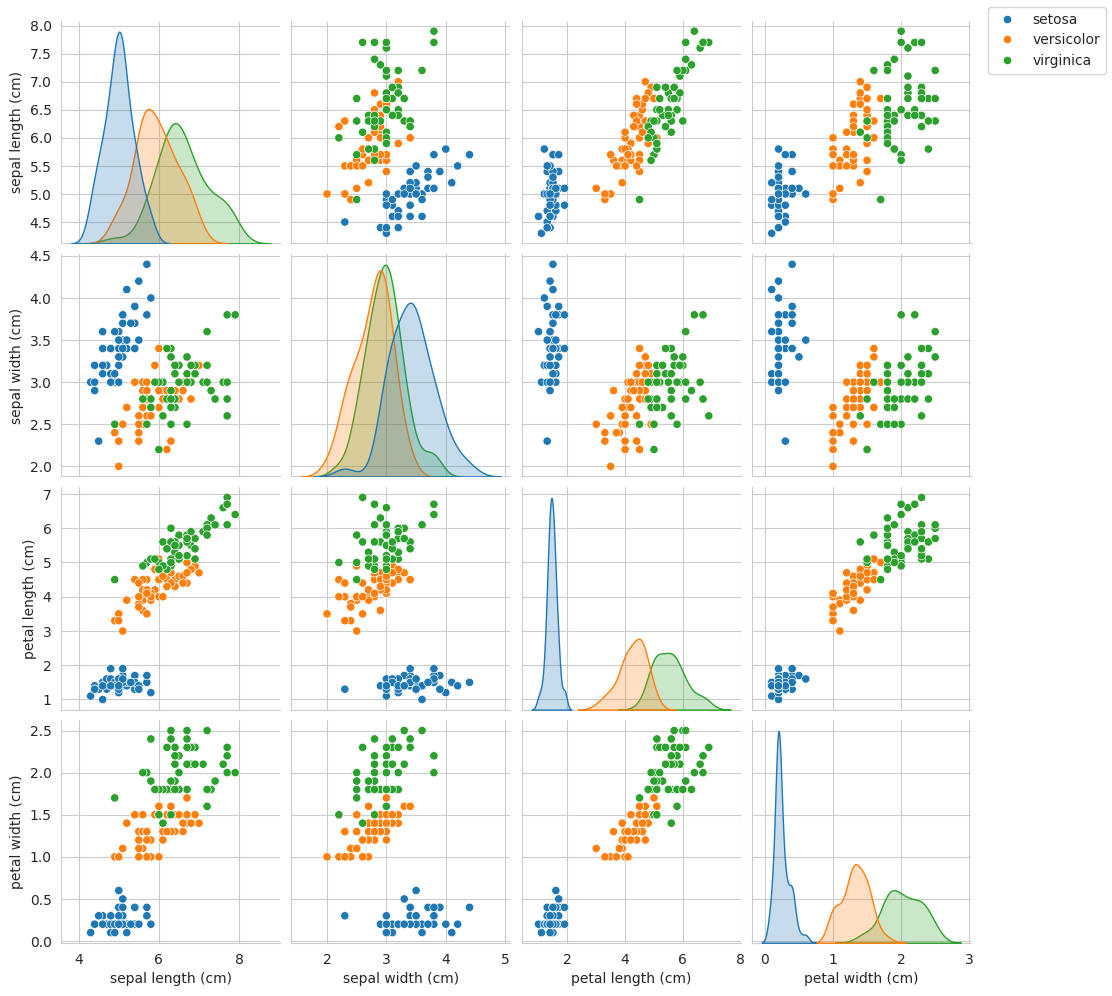

In [8]:
# Plot the pairwise relationships in the dataset
sns_plot = sns.pairplot(iris_df, vars=iris['feature_names'], hue="species")

# Move the legend on top of the plot
handles = sns_plot._legend_data.values()
labels = sns_plot._legend_data.keys()
sns_plot._legend.remove()
sns_plot.fig.legend(handles=handles, labels=labels, loc='upper right', ncol=1)
sns_plot._legend.set_bbox_to_anchor((0.9, 0.6))  # adjust the values as needed

plt.show()

## 1. "noise injection" / "noisy data augmentation".

In [9]:
NORMAL_CLASS = 'versicolor'
ANOMALY_CLASSES = ['setosa', 'virginica']
ANOMALY_CLASS_1 = ANOMALY_CLASSES[0]
ANOMALY_CLASS_2 = ANOMALY_CLASSES[1]
print(f"ANOMALY_CLASS_1 is {ANOMALY_CLASS_1}")
print(f"ANOMALY_CLASS_2 is {ANOMALY_CLASS_2}")

ANOMALY_CLASS_1 is setosa
ANOMALY_CLASS_2 is virginica


In [10]:
N = 1_000
np.random.seed(2023)
gauss_df = pd.DataFrame(np.resize(np.random.normal(loc=0.0, scale=.1, size=N * 4), (N, 4)))
gauss_df  # N(0,1) leads to negative values

0         1         2         3
0    0.071167 -0.032448 -0.100187  0.023625
1   -0.010216 -0.114129  0.265441  0.144061
2    0.009890 -0.312153 -0.107652 -0.032568
3   -0.103550 -0.042632 -0.102936 -0.052177
4   -0.042276 -0.009924 -0.138026  0.030190
..        ...       ...       ...       ...
995  0.060113 -0.086595  0.070180 -0.024466
996  0.043743  0.046175 -0.239791  0.084241
997  0.227978 -0.051998 -0.055464  0.066933
998  0.036602  0.045278  0.123374 -0.014997
999  0.024197  0.078323 -0.019283 -0.026575

[1000 rows x 4 columns]

In [11]:
normal_gauss_df = iris_df[iris_df['species'] == NORMAL_CLASS].sample(n=N, replace=True, random_state=2023)
normal_gauss_df['sepal length (cm)'] += gauss_df[0].tolist()
normal_gauss_df['sepal width (cm)'] += gauss_df[1].tolist()
normal_gauss_df['petal length (cm)'] += gauss_df[2].tolist()
normal_gauss_df['petal width (cm)'] += gauss_df[3].tolist()
# get_stats(normal_gauss_df, 'species')

In [12]:
N2 = 1_000
np.random.seed(20232)
gauss_df_2 = pd.DataFrame(np.resize(np.random.normal(loc=0.0, scale=.1, size=N2 * 4), (N2, 4)))

anomaly_1_gauss_df_all = iris_df[iris_df['species'] == ANOMALY_CLASS_1].sample(n=N2, replace=True, random_state=20232)
anomaly_1_gauss_df_all['sepal length (cm)'] += gauss_df_2[0].tolist()
anomaly_1_gauss_df_all['sepal width (cm)'] += gauss_df_2[1].tolist()
anomaly_1_gauss_df_all['petal length (cm)'] += gauss_df_2[2].tolist()
anomaly_1_gauss_df_all['petal width (cm)'] += gauss_df_2[3].tolist()
# anomaly_1_gauss_df = anomaly_1_gauss_df_all.iloc[:int(N2 / 2)]
# anomaly_1_gauss_df_for_contrast_learn = anomaly_1_gauss_df_all.iloc[int(N2 / 2):]  # NOT USED
# print(get_stats(anomaly_1_gauss_df, 'species'))
# print(get_stats(anomaly_1_gauss_df_for_contrast_learn, 'species'))
filtered_df = anomaly_1_gauss_df_all[
    (anomaly_1_gauss_df_all['sepal length (cm)'] > 0) &
    (anomaly_1_gauss_df_all['sepal width (cm)'] > 0) &
    (anomaly_1_gauss_df_all['petal length (cm)'] > 0) &
    (anomaly_1_gauss_df_all['petal width (cm)'] > 0)
    ]
anomaly_1_gauss_df = filtered_df.sample(n=500, replace=False)

np.random.seed(20233)
gauss_df_3 = pd.DataFrame(np.resize(np.random.normal(loc=0.0, scale=.1, size=int(N2 * 4 / 2)), (int(N2 / 2), 4)))

anomaly_2_gauss_df = iris_df[iris_df['species'] == ANOMALY_CLASS_2].sample(n=int(N2 / 2), replace=True,
                                                                           random_state=20233)
anomaly_2_gauss_df['sepal length (cm)'] += gauss_df_3[0].tolist()
anomaly_2_gauss_df['sepal width (cm)'] += gauss_df_3[1].tolist()
anomaly_2_gauss_df['petal length (cm)'] += gauss_df_3[2].tolist()
anomaly_2_gauss_df['petal width (cm)'] += gauss_df_3[3].tolist()
# get_stats(anomaly_2_gauss_df, 'species')

In [13]:
get_stats(pd.concat([normal_gauss_df, anomaly_1_gauss_df, anomaly_2_gauss_df], ignore_index=True), 'species')

sepal length (cm)                                          \
                       count      mean       std       min       max   
species                                                                
setosa                   500  4.994412  0.357132  4.184452  5.961593   
versicolor              1000  5.959968  0.528242  4.745296  7.189235   
virginica                500  6.594520  0.655973  4.698630  8.063486   

           sepal width (cm)                                          ...  \
                      count      mean       std       min       max  ...   
species                                                              ...   
setosa                  500  3.436665  0.377704  2.096253  4.495183  ...   
versicolor             1000  2.775265  0.309474  1.896993  3.544235  ...   
virginica               500  2.960578  0.332619  2.058776  4.035601  ...   

           petal width (cm)                                         target  \
                      count      mean       std       min       max  count   
species                                                                      
setosa                  500  0.242041  0.131662  0.000288  0.670095    500   
versicolor             1000  1.326650  0.213250  0.725228  2.030140   1000   
virginica               500  2.014248  0.294404  1.235884  2.718885    500   

                                
           mean  std  min  max  
species                         
setosa      0.0  0.0  0.0  0.0  
versicolor  1.0  0.0  1.0  1.0  
virginica   2.0  0.0  2.0  2.0  

[3 rows x 25 columns]

### Create synthetic anomaly for contrastive learning

In [14]:
#  1. anomaly == normal + high gaus
#  2. anomaly == only gaus
#  3. anomaly == only uniform
# Using 3.:
N3 = 500
np.random.seed(20234)
uniform_df_3 = pd.DataFrame(np.random.uniform(low=0.0, high=10.0, size=(N3, 4)),
                            columns=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'])

## 2. Contrastive train autoencoder on normal and random data as contrast

In [15]:
normal_gauss_df_for_contrast_learn = normal_gauss_df.iloc[:int(N / 2)]
# print(f"anomaly_1_gauss_df_for_contrast_learn # = {len(anomaly_1_gauss_df_for_contrast_learn.index)}")
print(f"normal_gauss_df_for_contrast_learn # = {len(normal_gauss_df_for_contrast_learn.index)}")  # NOT USED
print(f"uniform_df_3 # = {len(uniform_df_3.index)}")

normal_gauss_df_for_contrast_learn # = 500
uniform_df_3 # = 500


In [16]:
# Normalization
# anomaly_df = anomaly_1_gauss_df_for_contrast_learn  # Not used
normal_train_df = normal_gauss_df_for_contrast_learn

# combined_df = pd.concat([anomaly_df, normal_df])

# scaler only for class Normal:
scaler = StandardScaler()
# scaler.fit(combined_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy())
scaler.fit(
    normal_train_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy())

# anomaly_scaled = scaler.transform(anomaly_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy())
anomaly_train_scaled = scaler.transform(uniform_df_3[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
                                                      'petal width (cm)']].to_numpy())  # WE USE INIFORM
normal_train_scaled = scaler.transform(
    normal_train_df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy())

anomaly_train_scaled_pt = torch.tensor(anomaly_train_scaled, dtype=torch.float32)
normal_train_scaled_pt = torch.tensor(normal_train_scaled, dtype=torch.float32)

### train model

In [ ]:
# Inicjalizacja modelu
# autoencoder = IrisAutoencoder3()
contrastive_model = IrisAutoencoder3()
# contrastive_model = ContrastiveModel(autoencoder)
contrastive_model.train()

# Criterion i optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=0.0001, weight_decay=1e-5)

num_epochs = 10_000
NO_IMPROVEMENT_IN_N_STEPS = 1_000

best_model_wts = copy.deepcopy(contrastive_model.state_dict())
best_loss = float('inf')
steps_without_improvement = 0

# Tworzenie pustych list do przechowywania wartości straty
loss_values = []

# Tworzenie DataLoaderów
anomaly_loader_1 = DataLoader(TensorDataset(anomaly_train_scaled_pt, torch.ones(anomaly_train_scaled_pt.shape[0])),
                              batch_size=32, shuffle=True)  # uniform_df_3
# anomaly_loader_2 = DataLoader(TensorDataset(anomaly_data, torch.ones(anomaly_data.shape[0])), batch_size=32, shuffle=True)
normal_loader_1 = DataLoader(TensorDataset(normal_train_scaled_pt, torch.zeros(normal_train_scaled_pt.shape[0])),
                             batch_size=32, shuffle=True)
normal_loader_2 = DataLoader(TensorDataset(normal_train_scaled_pt, torch.zeros(normal_train_scaled_pt.shape[0])),
                             batch_size=32, shuffle=True)

for epoch in range(num_epochs):
    for (normal_batch1, _), (normal_batch2, _), (anomaly_batch1, _) in zip(normal_loader_1, normal_loader_2,
                                                                           anomaly_loader_1):
        # In the context of contrastive learning, loss_negative is the loss that we want to minimize.
        # In this particular case, we want the representations of normal examples to be as close to zero as possible
        # (which is represented by torch.zeros(output_normal.shape[0], device=output_normal.device)).
        # criterion(output_normal, torch.zeros(output_normal.shape[0], device=output_normal.device)) calculates the mean square error (MSE)
        # between the model's output for normal examples (output_normal) and a vector of zeros (which has the same shape as output_normal).
        # In other words, it measures how close the model's output for normal examples is to zero.
        # The goal is to train the model to reduce this loss value, forcing the model to generate representations,
        # which are as close to zero as possible for normal examples.

        output_anomaly1 = contrastive_model(anomaly_batch1)
        output_normal1 = contrastive_model(normal_batch1)
        output_normal2 = contrastive_model(normal_batch2)

        # Positive Loss - Comparison of anomaly with normal
        loss_positive = criterion(output_anomaly1, output_normal1) + criterion(output_anomaly1, output_normal2)

        # Negative Loss - Comparison of normal with normal
        loss_negative = criterion(output_normal1, output_normal2)

        # loss = loss_positive + 1/loss_negative  # TODO Don't know why it yields best result
        loss = 1 / loss_positive + loss_negative
        loss_values.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_wts = copy.deepcopy(contrastive_model.state_dict())
            steps_without_improvement = 0
        else:
            steps_without_improvement += 1

        if steps_without_improvement >= NO_IMPROVEMENT_IN_N_STEPS:
            print(f'Stopping training due to lack of improvement in last {NO_IMPROVEMENT_IN_N_STEPS} steps.')
            break

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'epoch {epoch + 1}/{num_epochs}, loss={loss.item():.4f}')

    if steps_without_improvement >= NO_IMPROVEMENT_IN_N_STEPS:
        break

contrastive_model.load_state_dict(best_model_wts)

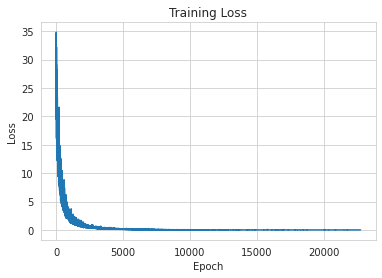

In [40]:
# After the training, plot the training loss values
plt.plot(loss_values)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [41]:
torch.save(contrastive_model.state_dict(), f'{DATA_DIRECTORY}/Iris_contrastive_model_versicolor_v9_noise_improved.pht')

### Load model

In [ ]:
### Download serialised model_iris
! cd fast/inxai/examples/jgama/serialised && wget https://github.com/sbobek/inxai/blob/time-series/examples/jgama/serialised/Iris_contrastive_model_versicolor_v9_noise_improved.pht

In [18]:
# There is some problem with loading the file, one need to upload it once again manually
# model_iris = ContrastiveModel(IrisAutoencoder3())

model_iris = IrisAutoencoder3()
model_iris.load_state_dict(torch.load(f'{DATA_DIRECTORY}/Iris_contrastive_model_versicolor_v9_noise_improved.pht'))

<All keys matched successfully>

In [19]:
model_iris.eval()

IrisAutoencoder3(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=4, out_features=2, bias=True)
    (6): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): ReLU(inplace=True)
  )
)

### 3. Test autoencoder, visualise losses and choose cutoff

In [20]:
X_normal = normal_gauss_df.iloc[int(N / 2):][
    ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X_anomaly_1 = anomaly_1_gauss_df[
    ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
X_anomaly_2 = anomaly_2_gauss_df[
    ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']].to_numpy()
print(f"X_normal # = {len(X_normal)}")
print(f"X_anomaly_1 # = {len(X_anomaly_1)}")
print(f"X_anomaly_2 # = {len(X_anomaly_2)}")

X_normal_scaled = scaler.transform(X_normal)
X_anomaly_1_scaled = scaler.transform(X_anomaly_1)
X_anomaly_2_scaled = scaler.transform(X_anomaly_2)

X_normal_scaled_pt = torch.FloatTensor(X_normal_scaled)
X_anomaly_1_scaled_pt = torch.FloatTensor(X_anomaly_1_scaled)
X_anomaly_2_scaled_pt = torch.FloatTensor(X_anomaly_2_scaled)

X_normal # = 500
X_anomaly_1 # = 500
X_anomaly_2 # = 500


In [21]:
print_loss(X_normal_scaled_pt, model_iris, f"Norm= {NORMAL_CLASS}")
print_loss(X_anomaly_1_scaled_pt, model_iris, f"Anomal1= {ANOMALY_CLASS_1}")
print_loss(X_anomaly_2_scaled_pt, model_iris, f"Anomal2= {ANOMALY_CLASS_2}")

[Norm= versicolor] test Loss= 0.9809625148773193
[Anomal1= setosa] test Loss= 17.665502548217773
[Anomal2= virginica] test Loss= 6.191577911376953


### MODEL for versicolor - plots are on the data not used for training nor fitting scaler

[ Norm= versicolor ] Cutoff Loss: 0.980962504453957
[ Anomal1= setosa ] Cutoff Loss: 17.66550172996521


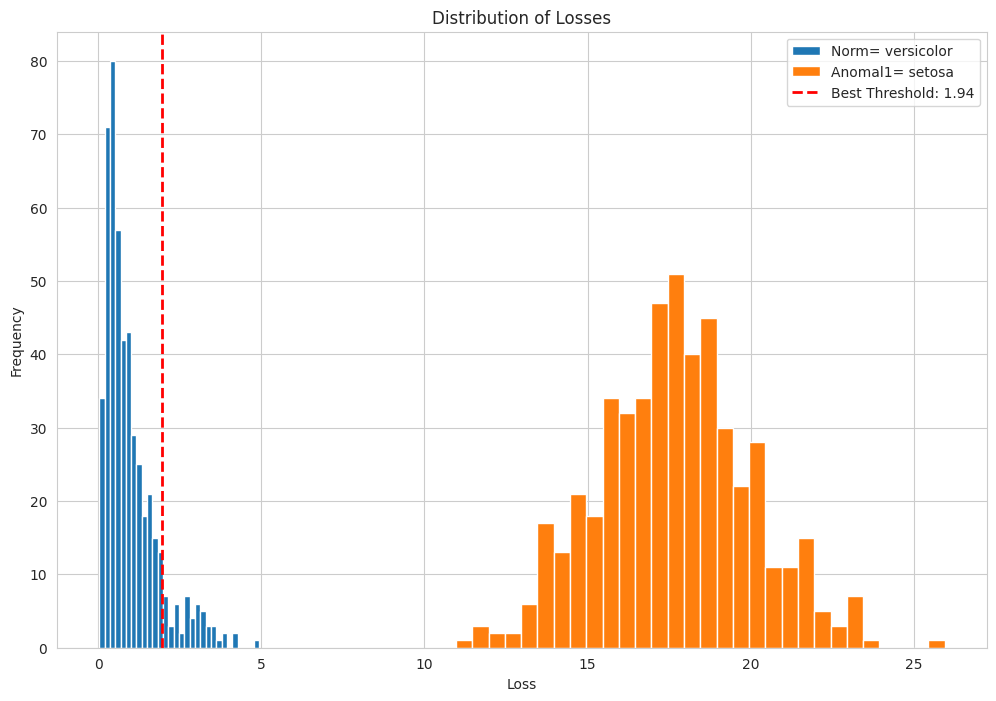

Best Threshold: 1.9442017428576945


In [22]:
losses_normal, cutoff_normal = get_losses(X_normal_scaled_pt, model_iris, f"Norm= {NORMAL_CLASS}")
losses_anomaly_1, cutoff_anomaly_1 = get_losses(X_anomaly_1_scaled_pt, model_iris, f"Anomal1= {ANOMALY_CLASS_1}")

# Example usage
threshold_1 = find_best_threshold(losses_normal, losses_anomaly_1, f"Norm= {NORMAL_CLASS}",
                                  f"Anomal1= {ANOMALY_CLASS_1}")
print("Best Threshold:", threshold_1)

[ Anomal2= virginica ] Cutoff Loss: 6.1915777842998505


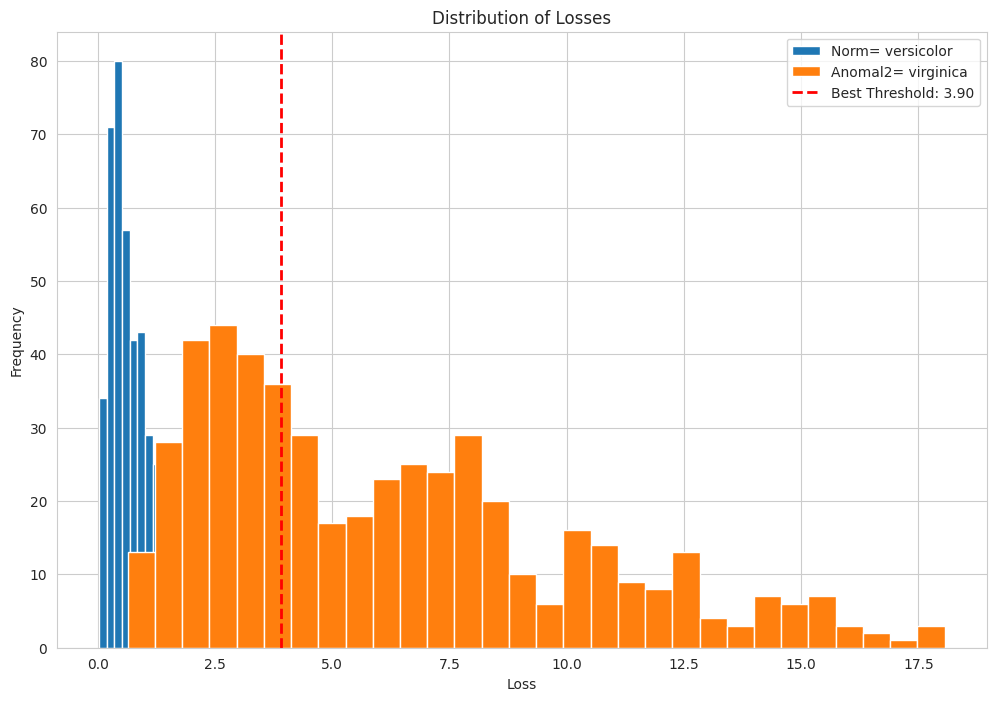

Best Threshold: 3.904478495568037


In [23]:
losses_anomaly_2, cutoff_anomaly_2 = get_losses(X_anomaly_2_scaled_pt, model_iris, f"Anomal2= {ANOMALY_CLASS_2}")

threshold_2 = find_best_threshold(losses_normal, losses_anomaly_2, f"Norm= {NORMAL_CLASS}",
                                  f"Anomal2= {ANOMALY_CLASS_2}")
print("Best Threshold:", threshold_2)

### Select treshold based ONLY on Normal data (test)

In [24]:
BEST_TRESHOLD_90, assessment = assess_gaussianity_and_percentile(losses_normal, 0.90)
print(f"Value at 90th percentile: {BEST_TRESHOLD_90:.2f}")
print(assessment)

Value at 90th percentile: 2.03
Data does not look Gaussian (reject H0).


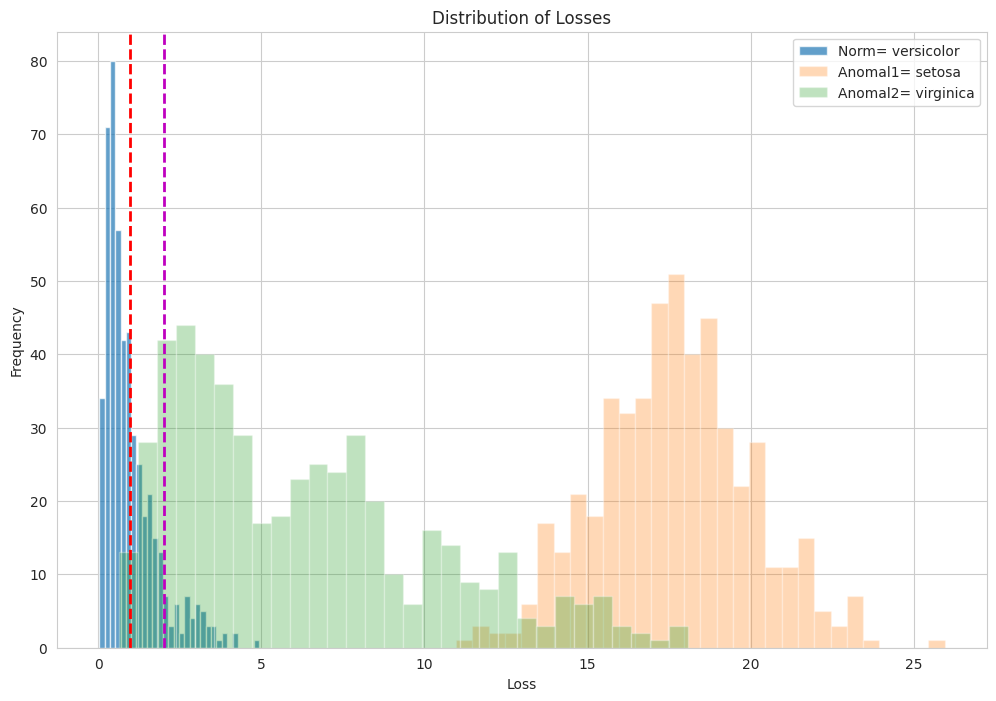

In [25]:
# Create a figure with defined size (width, height)
plt.figure(figsize=(12, 8))

plt.hist(losses_normal, bins=30, label=f"Norm= {NORMAL_CLASS}", alpha=0.7)
plt.hist(losses_anomaly_1, bins=30, label=f"Anomal1= {ANOMALY_CLASS_1}", alpha=0.3)
plt.hist(losses_anomaly_2, bins=30, label=f"Anomal2= {ANOMALY_CLASS_2}", alpha=0.3)
plt.axvline(cutoff_normal, color='r', linestyle='dashed', linewidth=2)
plt.axvline(BEST_TRESHOLD_90, color='m', linestyle='dashed', linewidth=2)  # check inter quartile range

plt.title('Distribution of Losses')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()  # add this to display the labels
plt.show()
# Anomal2 is slightly distinguished from Norm

In [26]:
# Concatenate to form the test set
X_test_scaled = np.concatenate((X_normal_scaled, X_anomaly_1_scaled))
y_test = np.concatenate((np.zeros(len(X_normal_scaled)), np.ones(len(X_anomaly_1_scaled))))

# Convert to tensors
X_test_scaled_pt = torch.FloatTensor(X_test_scaled)

Cutoff Loss: 9.323232117209583
Best Threshold=10.966359, G-Mean=1.000


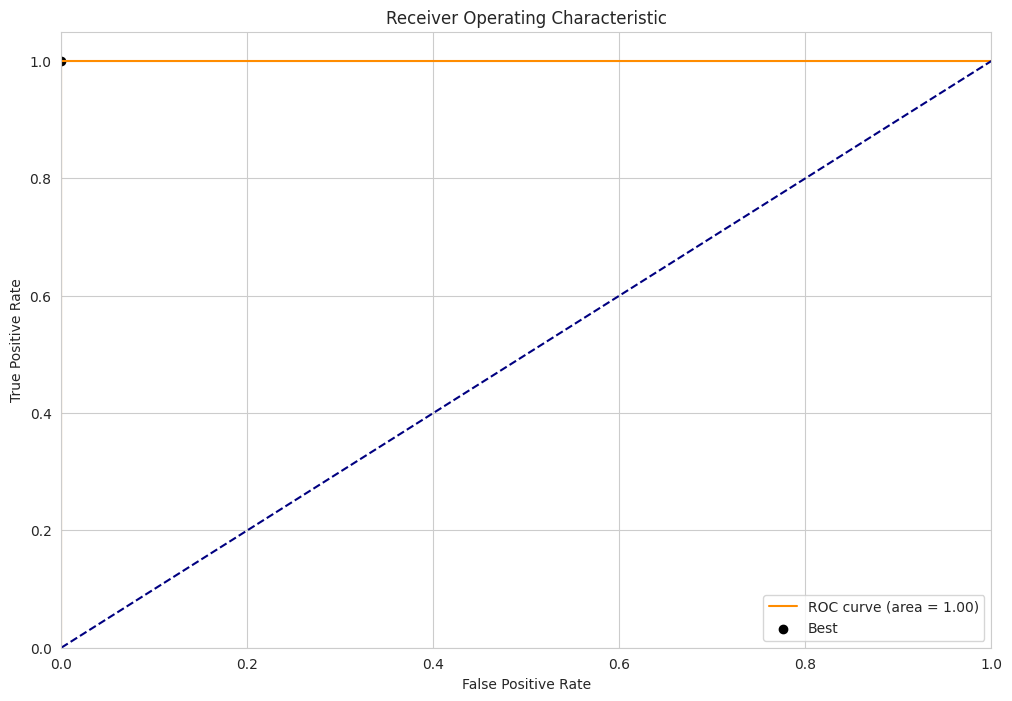

In [27]:
losses_2, _ = get_losses(X_test_scaled_pt, model_iris)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, losses_2, pos_label=1)
roc_auc = auc(fpr, tpr)
gmeans = sqrt(tpr * (1 - fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
BEST_TRESHOLD_ROC_1 = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (BEST_TRESHOLD_ROC_1, gmeans[ix]))

# Plot ROC curve
# Create a figure with defined size (width, height)
plt.figure(figsize=(12, 8))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

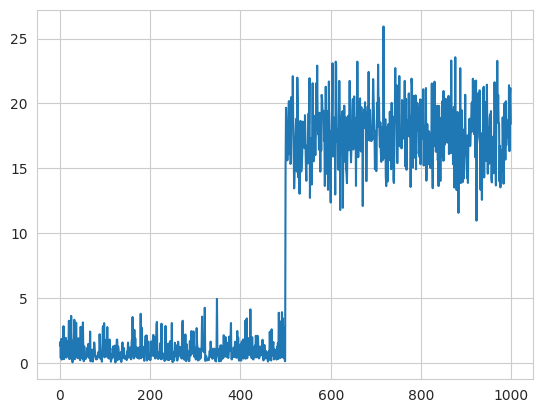

In [28]:
plt.plot(pd.DataFrame(losses_2))

### both two anomaly classes

In [29]:
# LOSS_THRESHOLD = BEST_TRESHOLD_ROC_1
LOSS_THRESHOLD = BEST_TRESHOLD_90
print(f"loss threshold set to {LOSS_THRESHOLD}")

y_test_pred = [0.0 if l < LOSS_THRESHOLD else 1.0 for l in losses_2]
y_test_pred_names = ['normal (versicolor)' if l < LOSS_THRESHOLD else 'anomaly' for l in losses_2]

confusion = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(accuracy_score(y_test, y_test_pred), len(y_test)))

loss threshold set to 2.028551530838014
Confusion Matrix

[[450  50]
 [  0 500]]

Accuracy: 0.95, samples=1000


Cutoff Loss: 8.279347339573006
Best Threshold=2.219201, G-Mean=0.922


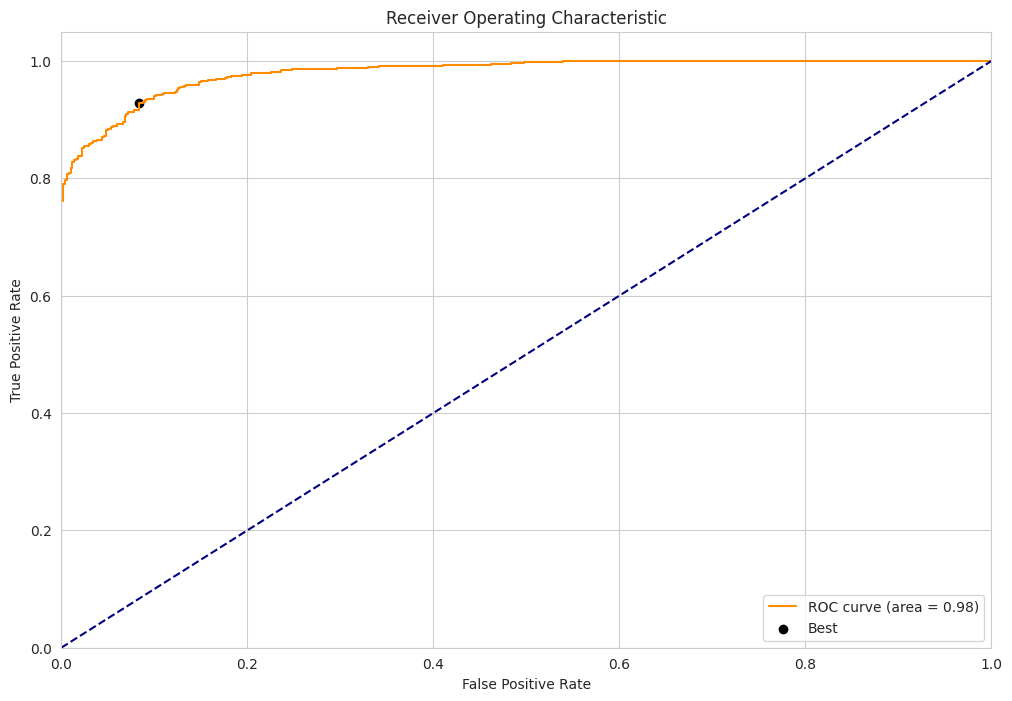

In [30]:
# Concatenate to form the test set
X_test_scaled_3 = np.concatenate((X_normal_scaled, X_anomaly_1_scaled, X_anomaly_2_scaled))
y_test_3 = np.concatenate((np.zeros(len(X_normal)), np.ones(len(X_anomaly_1)), np.ones(len(X_anomaly_2))))

# Convert to tensors
X_test_3_scaled_pt = torch.FloatTensor(X_test_scaled_3)

losses_3, _ = get_losses(X_test_3_scaled_pt, model_iris)  # Iris_contrastive_model_versicolor_v7.pht

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test_3, losses_3, pos_label=1)
roc_auc = auc(fpr, tpr)
gmeans = sqrt(tpr * (1 - fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
BEST_TRESHOLD_ALL_CLASSES = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (BEST_TRESHOLD_ALL_CLASSES, gmeans[ix]))

# Plot ROC curve
# Create a figure with defined size (width, height)
plt.figure(figsize=(12, 8))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [31]:
LOSS_THRESHOLD_3 = BEST_TRESHOLD_90
print(f"loss threshold set to {LOSS_THRESHOLD_3}")

y_test_3_pred = [0.0 if l < LOSS_THRESHOLD_3 else 1.0 for l in losses_3]
y_test_3_pred_names = ['normal (versicolor)' if l < LOSS_THRESHOLD_3 else 'anomaly' for l in losses_3]

confusion = confusion_matrix(y_test_3, y_test_3_pred)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(accuracy_score(y_test_3, y_test_3_pred), len(y_test_3)))

# If we have had access to anomaly2:
LOSS_THRESHOLD_3 = BEST_TRESHOLD_ALL_CLASSES
print(f"loss threshold set to {LOSS_THRESHOLD_3}")

y_test_3_pred_treshold_all = [0.0 if l < LOSS_THRESHOLD_3 else 1.0 for l in losses_3]
y_test_3_pred_names_treshold_all = ['normal (versicolor)' if l < LOSS_THRESHOLD_3 else 'anomaly' for l in losses_3]

confusion = confusion_matrix(y_test_3, y_test_3_pred_treshold_all)
print('Confusion Matrix\n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(accuracy_score(y_test_3, y_test_3_pred_treshold_all), len(y_test_3)))

loss threshold set to 2.028551530838014
Confusion Matrix

[[450  50]
 [ 60 940]]

Accuracy: 0.93, samples=1500

loss threshold set to 2.21920108795166
Confusion Matrix

[[458  42]
 [ 71 929]]

Accuracy: 0.92, samples=1500


# 4. Rule-based explainer

## 4.A. Explain reconstruction loss - DELETED

## 4.B. Explain class

## Ordinary DecisionTreeClassifier

### Back from scaled to original

In [32]:
X_test_3 = np.concatenate((X_normal, X_anomaly_1, X_anomaly_2))
X_test_3_unscaled_df = unscale_data(X_test_scaled_3, scaler)
(X_test_3_unscaled_df - X_test_3).tail()

Got <class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  1500 non-null   float64
 1   sepal width (cm)   1500 non-null   float64
 2   petal length (cm)  1500 non-null   float64
 3   petal width (cm)   1500 non-null   float64
dtypes: float64(4)
memory usage: 47.0 KB
None


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
1495                0.0               0.0                0.0               0.0
1496                0.0               0.0                0.0               0.0
1497                0.0               0.0                0.0               0.0
1498                0.0               0.0                0.0               0.0
1499                0.0               0.0                0.0               0.0

In [33]:
# for LUX, no spaces
_feature_names = [n.replace(' ', '_').replace('(', '').replace(')', '') for n in iris.feature_names]
print(_feature_names)
X_test_3_unscaled_df.columns = _feature_names

# test_3_df = pd.DataFrame(X_test_3, columns=_feature_names)  # DONE scaled
X_test_3_unscaled_df['target'] = [0 if y == 0.0 else 1 for y in y_test_3_pred]
# X_test_3_unscaled_df

['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']


In [34]:
statistics = X_test_3_unscaled_df[_feature_names].describe()
print(statistics)  # fixed: some columns < 0.0 ? 

       sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm
count      1500.000000     1500.000000      1500.000000     1500.000000
mean          5.854526        3.064236         3.768053        1.197675
std           0.842577        0.434293         1.772036        0.763641
min           4.184452        1.919080         0.836317        0.000288
25%           5.122610        2.784645         1.577658        0.333011
50%           5.825841        3.012873         4.346809        1.334718
75%           6.468189        3.334195         5.134343        1.827897
max           8.063486        4.495183         7.098614        2.718885


In [35]:
print(y_test_3_pred_names[:10])
print(y_test_3_pred[:10])

['normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'normal (versicolor)', 'anomaly', 'normal (versicolor)']
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [36]:
# we simulate that we only know normal and anomaly_1 ??
classifier = DecisionTreeClassifier(max_depth=3)
classifier = classifier.fit(X_test_3_unscaled_df[_feature_names], y_test_3_pred_names)

# Print the rules
rules_classifier = export_text(classifier, feature_names=_feature_names)
print(rules_classifier)

|--- petal_length_cm <= 3.47
|   |--- petal_length_cm <= 3.29
|   |   |--- class: anomaly
|   |--- petal_length_cm >  3.29
|   |   |--- sepal_width_cm <= 2.61
|   |   |   |--- class: anomaly
|   |   |--- sepal_width_cm >  2.61
|   |   |   |--- class: normal (versicolor)
|--- petal_length_cm >  3.47
|   |--- petal_width_cm <= 1.72
|   |   |--- petal_length_cm <= 5.49
|   |   |   |--- class: normal (versicolor)
|   |   |--- petal_length_cm >  5.49
|   |   |   |--- class: anomaly
|   |--- petal_width_cm >  1.72
|   |   |--- petal_length_cm <= 5.03
|   |   |   |--- class: anomaly
|   |   |--- petal_length_cm >  5.03
|   |   |   |--- class: anomaly


In [37]:
X_test_3_unscaled_df.info()
X_test_3_unscaled_df[['target']].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  1500 non-null   float64
 1   sepal_width_cm   1500 non-null   float64
 2   petal_length_cm  1500 non-null   float64
 3   petal_width_cm   1500 non-null   float64
 4   target           1500 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.7 KB


target
1         990
0         510
dtype: int64

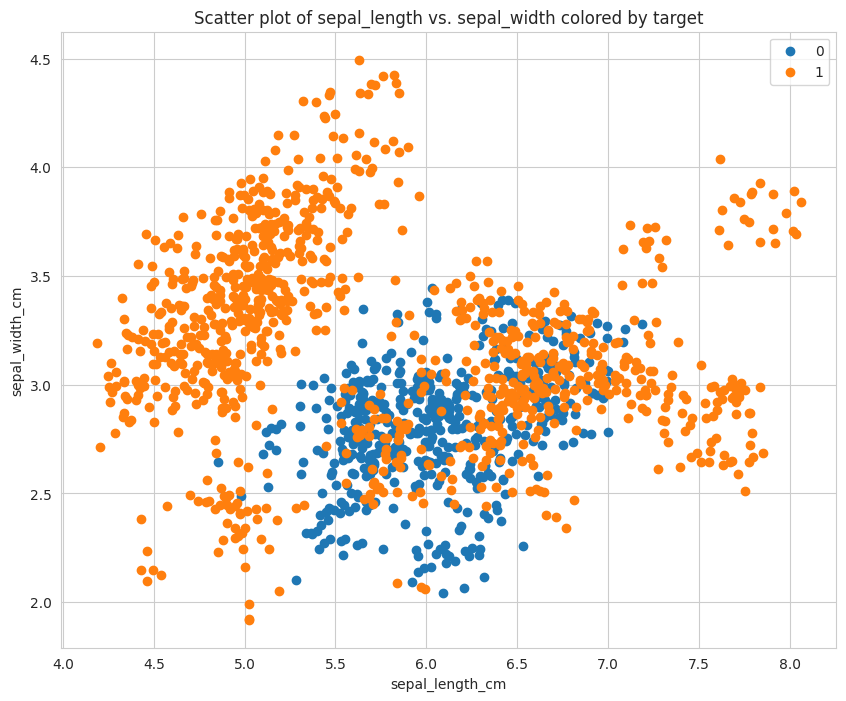

In [35]:
# Zakładając, że X_test_3_unscaled_df jest Twoim DataFrame:
df = X_test_3_unscaled_df

# Tworzenie wykresu
plt.figure(figsize=(10, 8))

for target_value in df['target'].unique():
    subset = df[df['target'] == target_value]
    plt.scatter(subset['sepal_length_cm'], subset['sepal_width_cm'], label=target_value)

plt.xlabel('sepal_length_cm')
plt.ylabel('sepal_width_cm')
plt.title('Scatter plot of sepal_length vs. sepal_width colored by target')
plt.legend()
plt.show()


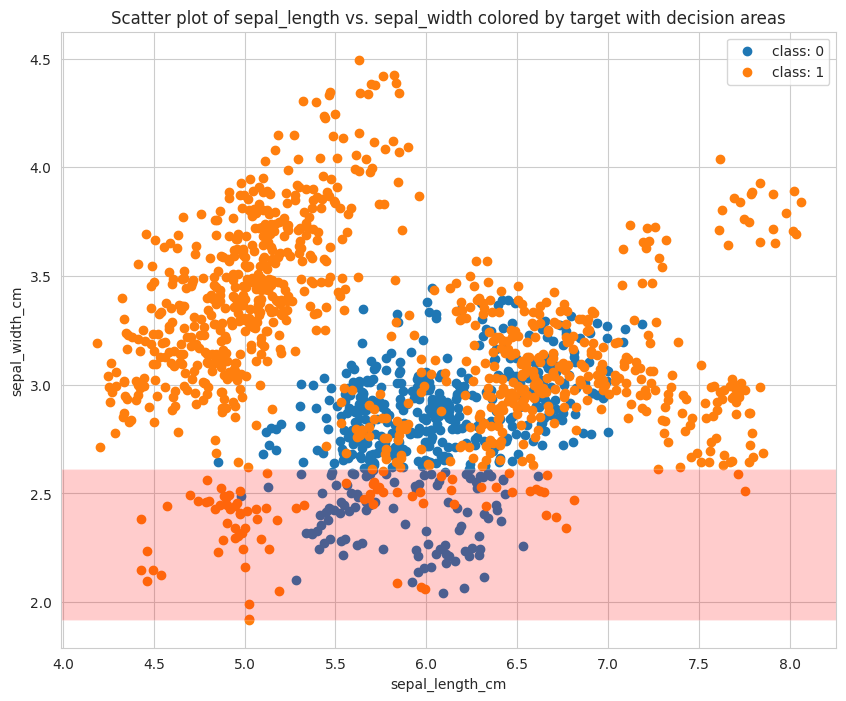

In [40]:
# Zakładając, że X_test_3_unscaled_df jest Twoim DataFrame:
df = X_test_3_unscaled_df

# Tworzenie wykresu
plt.figure(figsize=(10, 8))

for target_value in df['target'].unique():
    subset = df[df['target'] == target_value]
    plt.scatter(subset['sepal_length_cm'], subset['sepal_width_cm'], label=f'class: {target_value}')

# Dodanie obszarów reprezentujących reguły (tylko te związane z 'sepal_width_cm' są dodane)
# Zwróć uwagę, że używam całą przestrzeń 'sepal_length_cm' dla tych prostokątów, ponieważ reguły są niejednoznaczne dla tej cechy
plt.axhspan(df['sepal_width_cm'].min(), 2.61, facecolor='red', alpha=0.2)  # obszar dla sepal_width_cm <= 2.61

# Teraz jeśli chcemy dodatkowo podzielić ten obszar na podstawie 'petal_length_cm', można to zrobić, ale te reguły nie będą widoczne, ponieważ 'petal_length_cm' nie jest jednym z osi.

# Jeśli chcemy dodać więcej obszarów, możemy użyć tej samej metody axhspan lub axvspan

plt.xlabel('sepal_length_cm')
plt.ylabel('sepal_width_cm')
plt.title('Scatter plot of sepal_length vs. sepal_width colored by target with decision areas')
plt.legend()
plt.show()


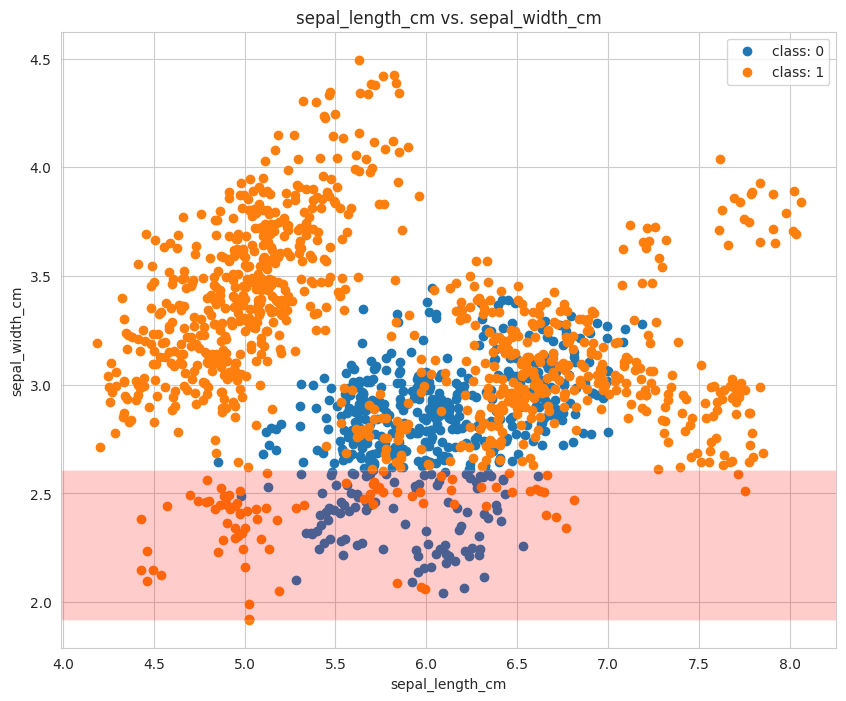

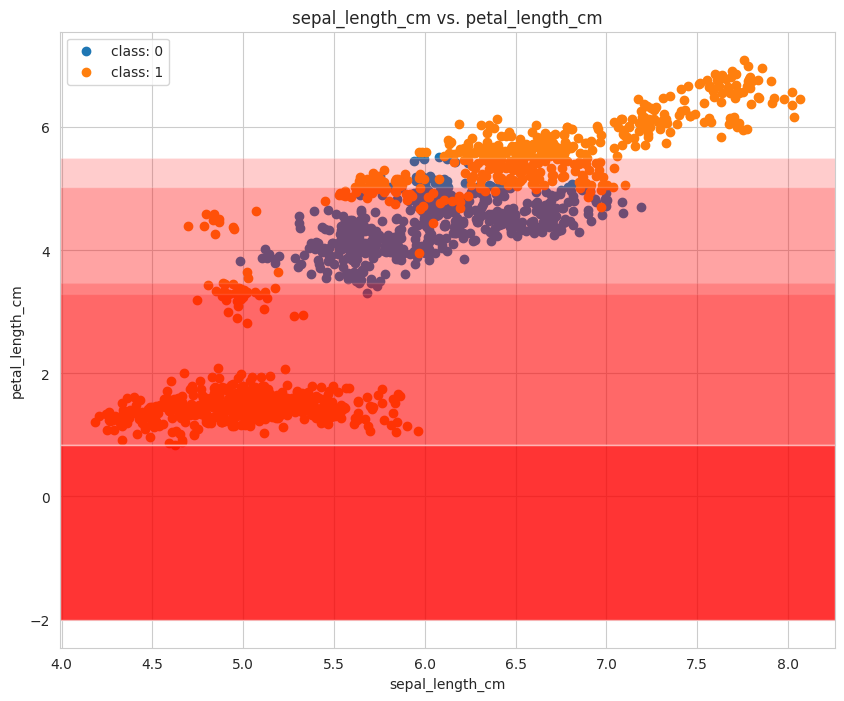

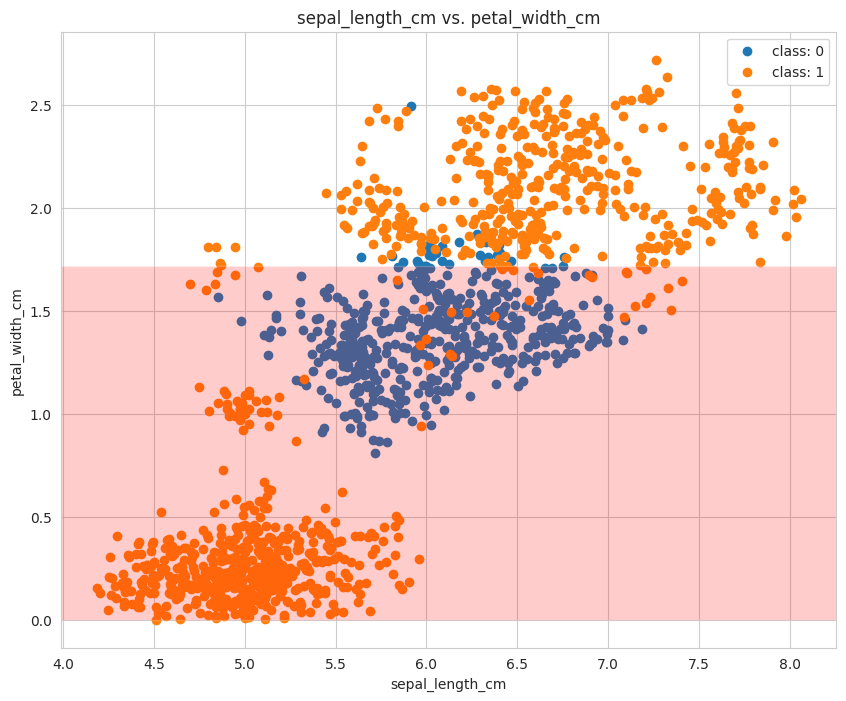

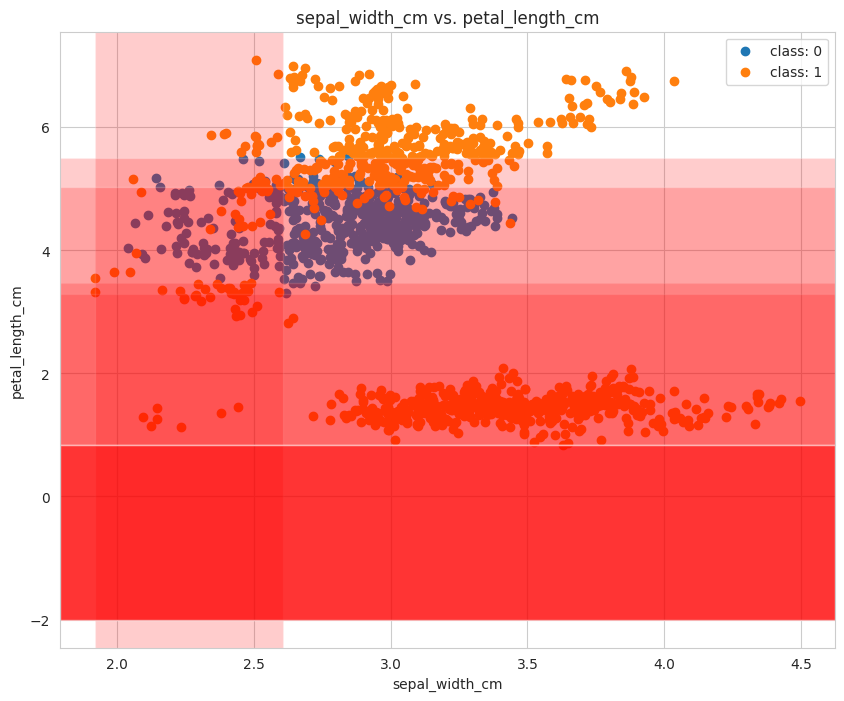

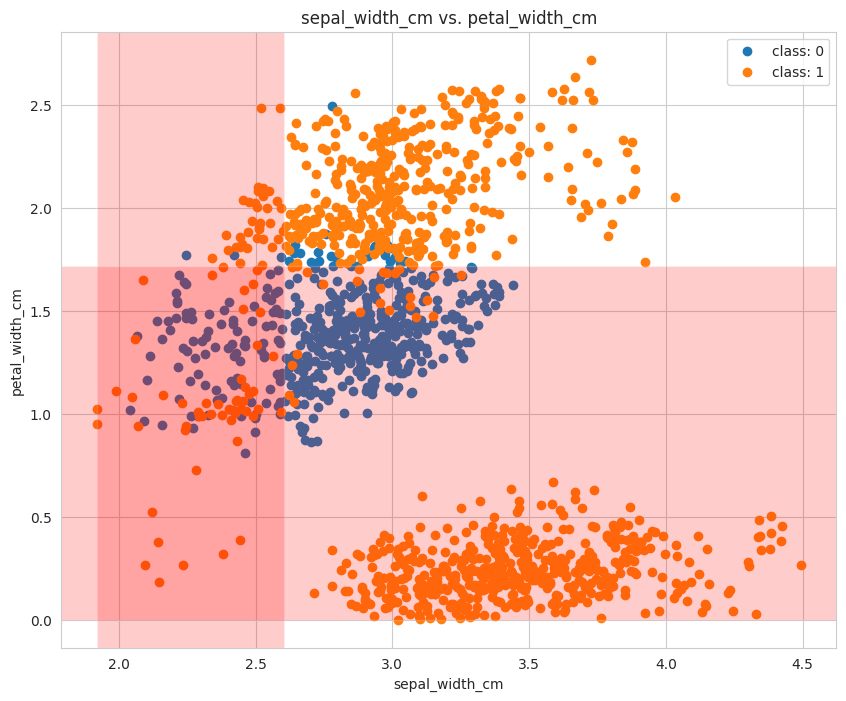

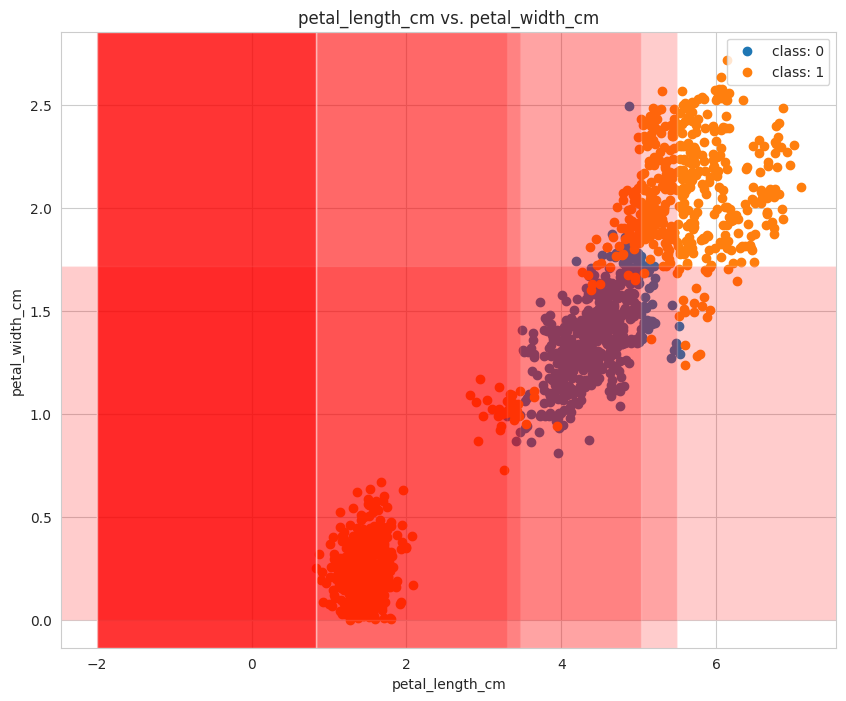

In [41]:
# Create a grid of scatter plots for all combinations of features
features = df.columns[:-1]  # Excluding the target column
for combo in combinations(features, 2):  # Taking all 2 combinations of features
    plt.figure(figsize=(10, 8))
    plot_decision_areas(df, combo[0], combo[1], classifier)


In [38]:
xai_classifier_y_test_3 = classifier.predict(
    X_test_3_unscaled_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']])

confusion = confusion_matrix(xai_classifier_y_test_3, y_test_3_pred_names)
print(
    'Confusion Matrix for Iris contrastive model on versicolor vs XAI DecisionTreeClassifier (this is on train for xai_classifier!) \n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(accuracy_score(xai_classifier_y_test_3, y_test_3_pred_names),
                                                len(xai_classifier_y_test_3)))

y_test_3_names = ['normal (versicolor)' if x == 0 else 'anomaly' for x in y_test_3]
confusion = confusion_matrix(y_test_3_names, xai_classifier_y_test_3)
print('Confusion Matrix for ground true vs XAI DecisionTreeClassifier \n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(accuracy_score(y_test_3_names, xai_classifier_y_test_3),
                                                len(xai_classifier_y_test_3)))

Confusion Matrix for Iris contrastive model on versicolor vs XAI DecisionTreeClassifier (this is on train for xai_classifier!) 

[[974  30]
 [ 16 480]]

Accuracy: 0.97, samples=1500

Confusion Matrix for ground true vs XAI DecisionTreeClassifier 

[[956  44]
 [ 48 452]]

Accuracy: 0.94, samples=1500


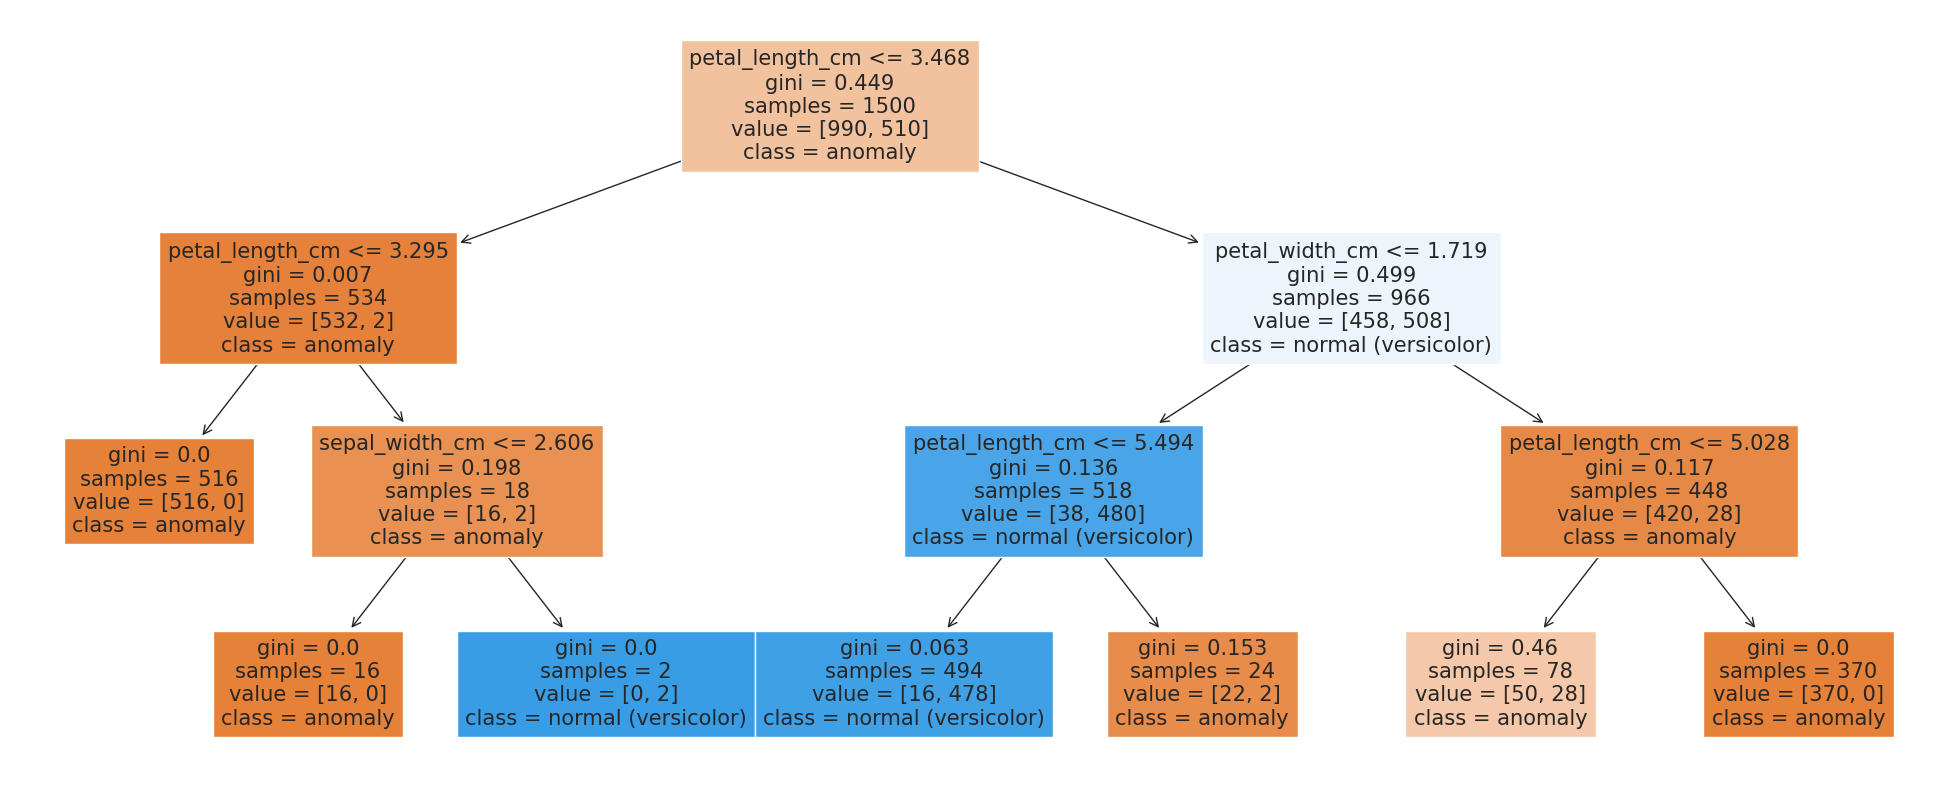

In [38]:
plt.figure(figsize=(25, 10))  # Set the figure size
plot_tree(classifier, feature_names=_feature_names, class_names=classifier.classes_, filled=True)
plt.show()

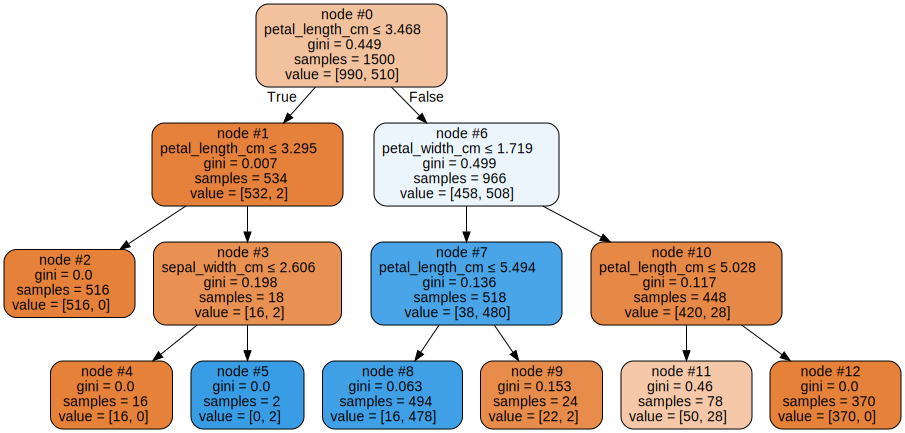

In [39]:
dot_data_3 = tree.export_graphviz(classifier, out_file=None,
                                  feature_names=_feature_names,
                                  filled=True, rounded=True,
                                  special_characters=True,
                                  node_ids=True)
# dot_data_3 = 'digraph Tree {size="10,10";' + dot_data_3[11:]

graph = graphviz.Source(dot_data_3, format='svg')
graph.render("figures/DecisionTreeClassifier_Iris_contrastive_model_versicolor_v7")

SVG(filename='figures/DecisionTreeClassifier_Iris_contrastive_model_versicolor_v7.svg')


# Simulate TS

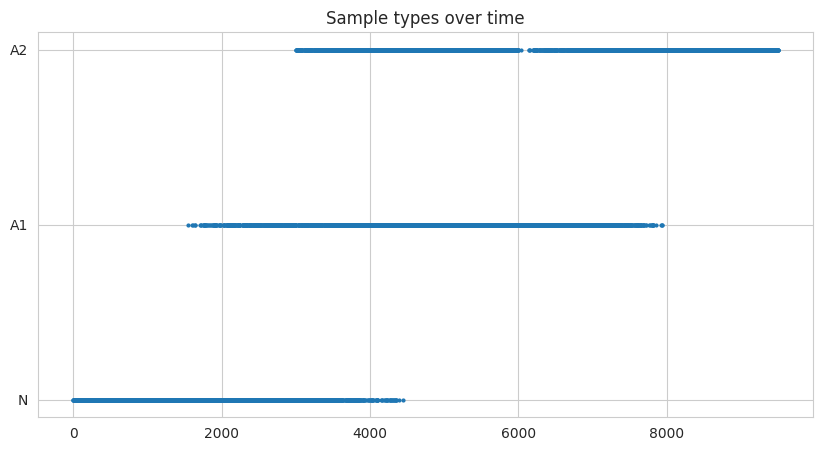

In [39]:
N1 = 0
N2 = 3000
N123 = 3000
N3 = 2000
N4 = 1500
p = 0.5

k = 50
time_series = list(simulate_time_series(N1, N2, N3, N123, N4, p, X_normal, X_anomaly_1, X_anomaly_2, seed=20235))
sample_counts = [Counter(sample_type for _, sample_type, time in time_series[i:i + k]) for i in
                 range(0, len(time_series), k)]
timestamps = range(0, len(time_series), k)

sample_types = []
for _, sample_type, timestamp in time_series:
    # print(timestamp)
    sample_types.append(sample_type)

plt.figure(figsize=(10, 5))
plt.plot(sample_types, 'o', markersize=2)
plt.title('Sample types over time')
plt.show()

N1_effective= 1500.0


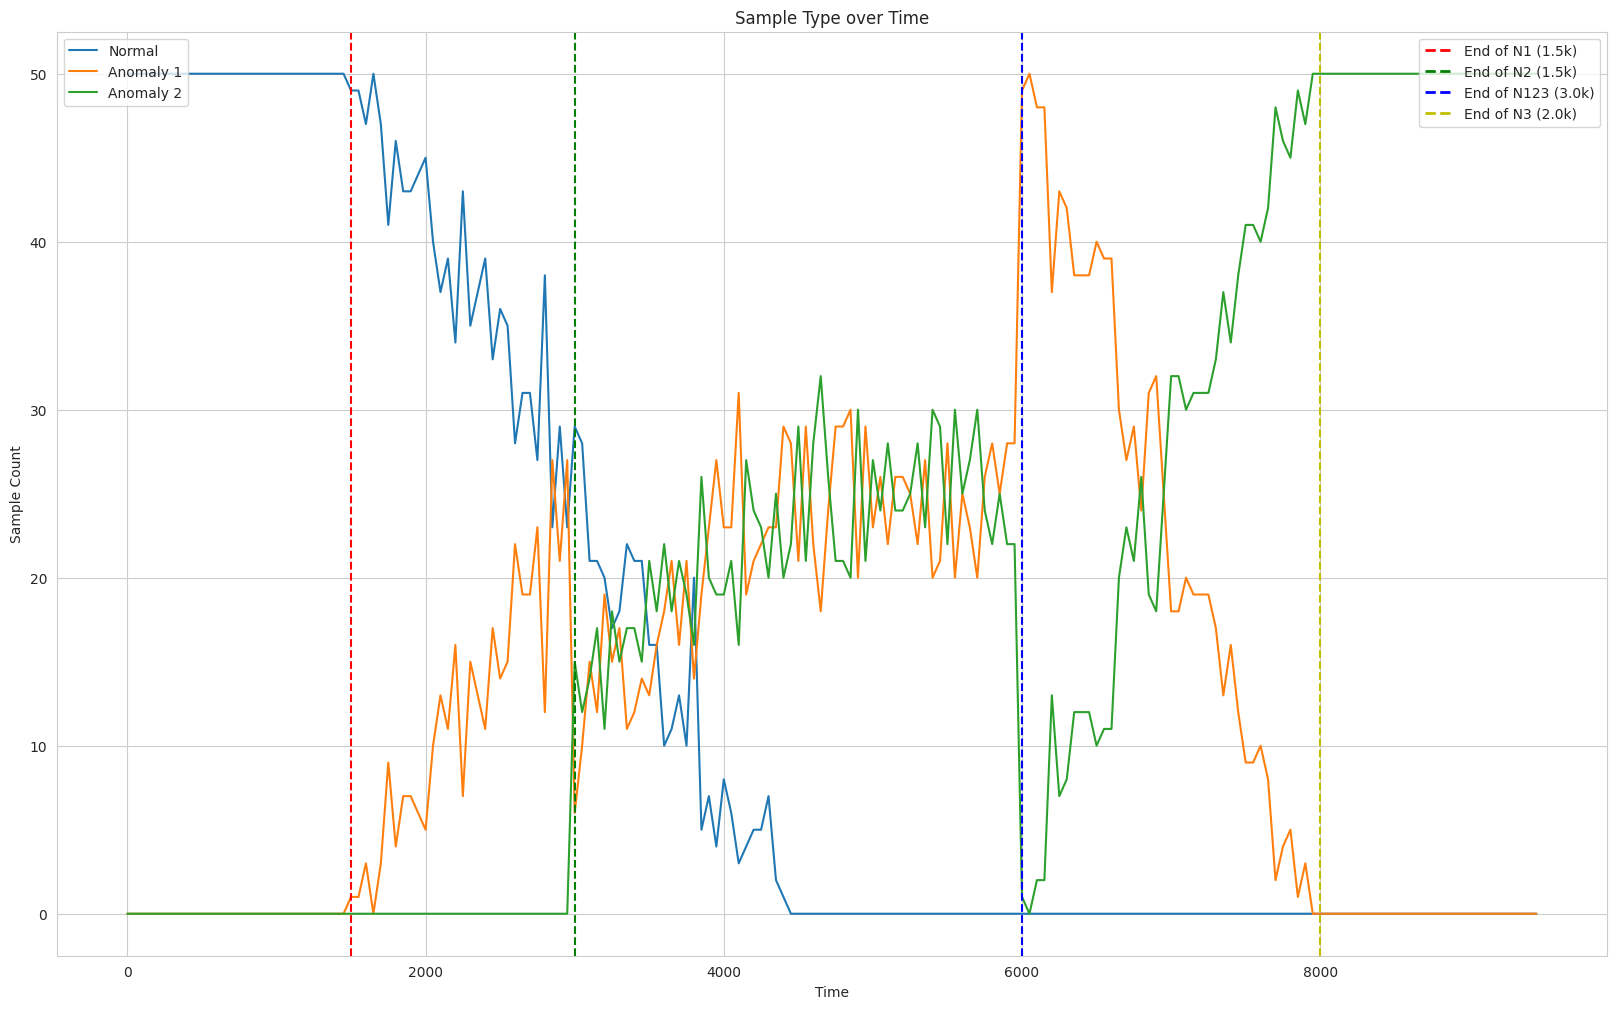

In [40]:
plt.figure(figsize=(20, 12))  # Increasing the size of the plot

# Plot data lines
line1, = plt.plot(timestamps, [count['N'] for count in sample_counts], label='Normal')
line2, = plt.plot(timestamps, [count['A1'] for count in sample_counts], label='Anomaly 1')
line3, = plt.plot(timestamps, [count['A2'] for count in sample_counts], label='Anomaly 2')

# Add vertical lines
# vline1 = plt.axvline(x=N1, color='r', linestyle='--')
N1_effective = (N1 + N2) / 2
print(f"N1_effective= {N1_effective}")
vline1 = plt.axvline(x=N1_effective, color='r', linestyle='--')
vline2 = plt.axvline(x=N1 + N2, color='g', linestyle='--')
vline3 = plt.axvline(x=N1 + N2 + N123, color='b', linestyle='--')
vline4 = plt.axvline(x=N1 + N2 + N123 + N3, color='y', linestyle='--')  # Line for N3
# vline5 = plt.axvline(x=N1+N2+N123+N3+N4, color='m', linestyle='--')  # Line for N4

# Create custom lines for the legend
custom_lines = [
    Line2D([0], [0], color='r', lw=2, linestyle='--'),
    Line2D([0], [0], color='g', lw=2, linestyle='--'),
    Line2D([0], [0], color='b', lw=2, linestyle='--'),
    Line2D([0], [0], color='y', lw=2, linestyle='--'),
    # Line2D([0], [0], color='m', lw=2, linestyle='--'),
]

# Create legends
legend1 = plt.legend([line1, line2, line3], ['Normal', 'Anomaly 1', 'Anomaly 2'], loc="upper left")
legend2 = plt.legend(custom_lines, [
    'End of N1 (1.5k)',
    'End of N2 (1.5k)', 'End of N123 (3.0k)', 'End of N3 (2.0k)',
    # 'End of N4 (1.5k)'
], loc="upper right")  # Legend for N3

# Add the first legend manually to the current Axes.
plt.gca().add_artist(legend1)

plt.xlabel('Time')
plt.ylabel('Sample Count')
plt.title('Sample Type over Time')

plt.show()

In [41]:
# time_series = list(simulate_time_series(N1, N2, N3, N123, p, X_normal, X_anomaly_1, X_anomaly_2, seed=20235))
time_series_y = [x[1] for x in time_series]
time_series_X = [x[0] for x in time_series]
# time_series_y
time_series_df = pd.DataFrame(time_series_X,
                              columns=['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm'])
# time_series_df = structured_list_to_dataframe(time_series)  ## the same 
# time_series_df = unscale_data(time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']], scaler)

time_series_df.columns = _feature_names

time_series_df['true_target'] = time_series_y

time_series_df[['true_target']].value_counts()

true_target
A2             3859
N              3013
A1             2628
dtype: int64

In [42]:
predictions_xai_classifier = classifier.predict(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']])
time_series_df['xai_classifier'] = predictions_xai_classifier

print(time_series_df[['xai_classifier']].value_counts())

# compare with deep model prediction
time_series_scaled = scaler.transform(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']])
time_series_scaled_pt = torch.tensor(time_series_scaled, dtype=torch.float32)

time_series_losses, _ = get_losses(time_series_scaled_pt, model_iris, "")

print(f"Threshold used= {LOSS_THRESHOLD}")
time_series_pred = [0.0 if l < LOSS_THRESHOLD else 1.0 for l in time_series_losses]
time_series_pred_names = ['normal (versicolor)' if l < LOSS_THRESHOLD else 'anomaly' for l in time_series_losses]

time_series_df['contrastive_autoencoder'] = time_series_pred_names
print(time_series_df[['contrastive_autoencoder']].value_counts())

xai_classifier     
anomaly                6450
normal (versicolor)    3050
dtype: int64
Cutoff Loss: 7.764892669726751
Threshold used= 2.028551530838014
contrastive_autoencoder
anomaly                    6308
normal (versicolor)        3192
dtype: int64


In [43]:
confusion = confusion_matrix(time_series_df[['xai_classifier']], time_series_df[['contrastive_autoencoder']])
print('Confusion Matrix for XAI DecisionTreeClassifier vs Iris contrastive model on versicolor \n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(
    accuracy_score(time_series_df[['xai_classifier']], time_series_df[['contrastive_autoencoder']]),
    len(time_series_df[['xai_classifier']])))

# Zdefiniowanie mapowania dla przekodowania
target_mapping = {'N': 'normal (versicolor)', 'A1': 'anomaly', 'A2': 'anomaly'}
# Przekodowanie kolumny 'true_target'
time_series_df['true_target_recoded'] = time_series_df['true_target'].replace(target_mapping)

confusion = confusion_matrix(time_series_df[['true_target_recoded']], time_series_df[['xai_classifier']])
print('Confusion Matrix for ground true vs XAI DecisionTreeClassifier \n')
print(confusion)

print('\nAccuracy: {:.2f}, samples={}\n'.format(
    accuracy_score(time_series_df[['true_target_recoded']], time_series_df[['xai_classifier']]),
    len(time_series_df[['xai_classifier']])))

Confusion Matrix for XAI DecisionTreeClassifier vs Iris contrastive model on versicolor 

[[6203  247]
 [ 105 2945]]

Accuracy: 0.96, samples=9500

Confusion Matrix for ground true vs XAI DecisionTreeClassifier 

[[6147  340]
 [ 303 2710]]

Accuracy: 0.93, samples=9500


### no negative values for features

In [44]:
## Fixed error with features < 0.0 
negative_or_zero_values = time_series_df.loc[
    (time_series_df['sepal_length_cm'] <= 0) |
    (time_series_df['sepal_width_cm'] <= 0) |
    (time_series_df['petal_length_cm'] <= 0) |
    (time_series_df['petal_width_cm'] <= 0)
    ]

# print(negative_or_zero_values['true_target'].value_counts())
# print(negative_or_zero_values.groupby('true_target').agg(['count', 'mean', 'std', 'min', 'max']))
# negative_or_zero_values.describe()
assert len(negative_or_zero_values.index) == 0, "There are observations with features < 0.0"

# explainer for TS

In [45]:
assert LOSS_THRESHOLD == BEST_TRESHOLD_90

Cutoff Loss: 1.0361863668914884
losses min= 0.01170929055660963, max= 4.399313926696777, threshold= 2.028551530838014
KS Test Result: Statistic = 0.10281468953410444, P-Value = 4.693641970215193e-05
Data does NOT seem to fit a skew-normal distribution (KS Test P-value = 0.00005).


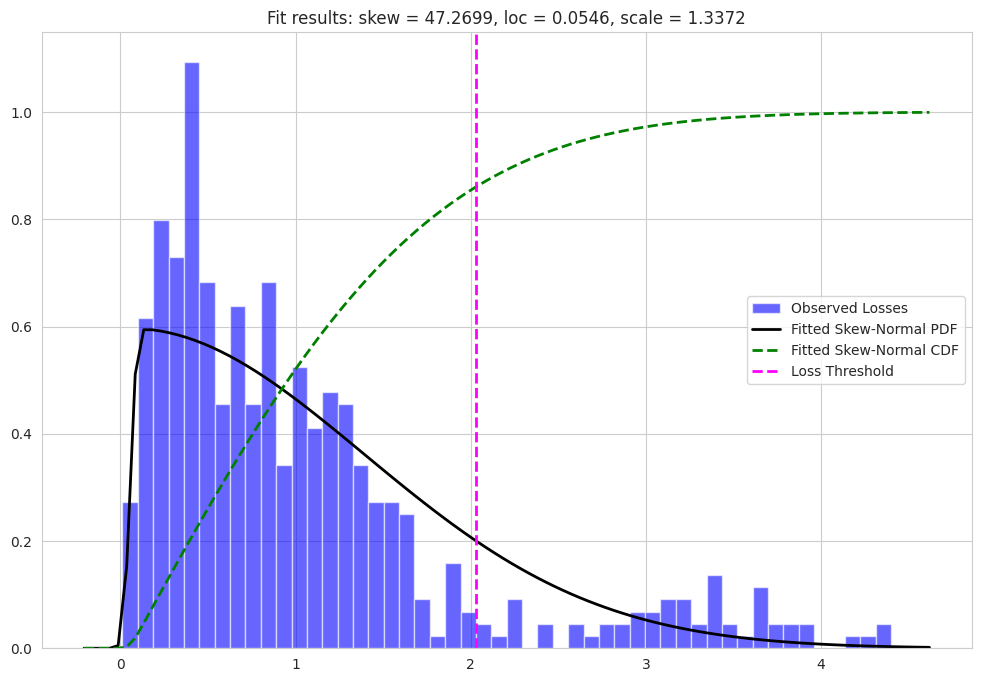

Cutoff Loss: 7.764892669726751
Cutoff Loss: 7.764892669726751
#time_series_prediction_probas_df = 9500


losses                                                       \
            count       min        max     median       mean       std   
prediction                                                               
0.0          3192  0.032932   2.022527   0.769260   0.871287  0.550868   
1.0          6308  2.036820  25.936558  11.300409  11.253223  6.387317   

           prob_norm                                                        \
               count       min       max        median      mean       std   
prediction                                                                   
0.0             3192  0.500705  0.998752  7.634350e-01  0.753240  0.145529   
1.0             6308  0.000000  0.494096  4.440892e-16  0.030166  0.082539   

           prob_anomal                                                    
                 count       min       max    median      mean       std  
prediction                                                                
0.0               3192  0.001248  0.499295  0.236565  0.246760  0.145529  
1.0               6308  0.505904  1.000000  1.000000  0.969834  0.082539

In [46]:
# Inicjalizacja modelu
model_classifier = AnomalyClassifier(autoencoder_model=model_iris,
                                     get_losses=get_losses,
                                     loss_threshold=LOSS_THRESHOLD,  # == BEST_TRESHOLD_90
                                     a_scaler=scaler)

# Dopasowanie modelu
# model.initialise_predict_proba(X_test_scaled_pt)
model_classifier.initialise_predict_proba(
    normal_train_scaled_pt)  # TODO use probability calibration from scikit https://scikit-learn.org/stable/modules/calibration.html

# Przewidywanie klas
predictions = model_classifier.predict(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']])

# Przewidywanie prawdopodobieństw klas
probas = model_classifier.predict_proba(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']])

time_series_prediction_probas_df = pd.DataFrame({
    'losses': time_series_losses,
    'prediction': predictions,
    'prob_norm': probas[:, 0],
    'prob_anomal': probas[:, 1]
})
print(f"#time_series_prediction_probas_df = {len(time_series_prediction_probas_df.index)}")

# Filtruj wiersze, w których dla klasy 0.0 proba_anomal > prob_norm lub dla klasy 1.0 proba_normal > prob_anomal
filtered_df = time_series_prediction_probas_df[
    ((time_series_prediction_probas_df['prediction'] == 0.0) & (
            time_series_prediction_probas_df['prob_anomal'] > time_series_prediction_probas_df['prob_norm'])) |
    ((time_series_prediction_probas_df['prediction'] == 1.0) & (
            time_series_prediction_probas_df['prob_norm'] > time_series_prediction_probas_df['prob_anomal']))
    ]
# Sortuj najpierw po 'prediction', a następnie po 'losses'
filtered_df = filtered_df.sort_values(by=['losses', 'prediction'])
assert len(filtered_df.index) == 0, f"#filtered_df = {len(filtered_df.index)}"

aggregated_stats = time_series_prediction_probas_df.groupby('prediction').agg({
    'losses': ['count', 'min', 'max', 'median', 'mean', 'std'],
    'prob_norm': ['count', 'min', 'max', 'median', 'mean', 'std'],
    'prob_anomal': ['count', 'min', 'max', 'median', 'mean', 'std']
})
# print(tabulate(aggregated_stats, headers='keys', tablefmt='psql'))
aggregated_stats

# SHAP / LIME

In [ ]:
# TODO:
# 1)
# - calculate SHAP / LIME / importancje z decision tree
# - check with k-means if we can see different clusters of explanations for N, A1, A2
# 
# 2) change point detection - rapoture detection 
# 
# 3) - niestablinosc

In [ ]:
# Many researchers use SHAP to interpret probabilities derived from classification models, as probabilities provide more balanced information about the model's prediction certainty than direct class predictions. However, whether to interpret probabilities or binary predictions depends on your specific use case and what you want to achieve.
# Here are some advantages and disadvantages of each approach:
# Interpreting Probabilities:
# Advantages:
# 
# Reveals the influence of features on prediction certainty.
# Can provide more detailed information about how features affect the model, as it considers the gradation of prediction certainty.
# Allows understanding not only the direction of a feature's influence (positive or negative) but also the strength of its influence on the probability of the predicted class.
# 
# Disadvantages:
# 
# It may be harder for those unfamiliar with the model to understand, as SHAP values will refer to changes in probability, not directly to the predicted class.
# 
# Interpreting Binary Predictions:
# Advantages:
# 
# Direct and easy to understand, as SHAP values will refer to the predicted class.
#     May be more useful in cases where you are only interested in the final classification outcome.
# 
# Disadvantages:
# 
# Does not provide information about the model's prediction certainty.
# May not reveal all the nuances of how features impact the model since the analysis is limited to binary predictions.
# 
# If your goal is to understand how features affect the model's prediction certainty, probabilities are a better choice. However, if your main goal is to understand which features lead to a specific classification, binary predictions may be more appropriate.

In [ ]:
# background_data = time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']].iloc[:100].values
background_data_tmp = time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']].sample(
    n=100, replace=False)  # more representative

# SANITY CHECK:
# model_classifier.predict_proba(background_data)
# model_classifier.predict(background_data)

explainer_tmp = shap.KernelExplainer(model_classifier.predict_proba, background_data_tmp)
with contextlib.redirect_stdout(io.StringIO()):
    shap_values_tmp = explainer_tmp.shap_values(background_data_tmp, silent=True)

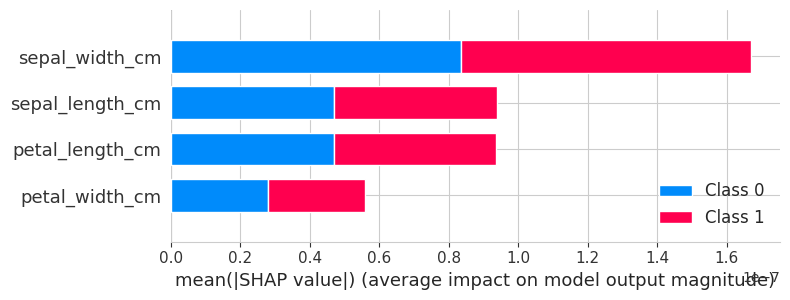

In [75]:
shap.summary_plot(shap_values_tmp, background_data_tmp)

In [76]:
shap_values_class0_tmp = pd.DataFrame(shap_values_tmp[0])
shap_values_class1_tmp = pd.DataFrame(shap_values_tmp[1])
shap_values_class1_tmp

0             1             2             3
0   6.719830e-09  3.732063e-09  6.719830e-09  6.492712e-09
1   6.734688e-09  4.570914e-09  6.734688e-09  5.624145e-09
2   2.156332e-08 -3.395790e-08  2.156332e-08  1.449570e-08
3   1.499635e-08 -2.045442e-08  1.499635e-08  1.412615e-08
4   8.230353e-09  3.561071e-10  8.230357e-09  6.847618e-09
..           ...           ...           ...           ...
95  5.971871e-09  5.775876e-09  5.971871e-09  5.944816e-09
96  5.926663e-09  5.907520e-09  5.926663e-09  5.903588e-09
97  6.574512e-09  4.027708e-09  6.574512e-09  6.487703e-09
98  1.376947e-08 -1.585944e-08  1.376947e-08  1.198494e-08
99  9.104598e-09  1.431070e-08  1.864630e-09 -1.804673e-09

[100 rows x 4 columns]

In [77]:
combined_shap_values_tmp = pd.concat([shap_values_class0_tmp, shap_values_class1_tmp], axis=1)
combined_shap_values_tmp.columns = [f"class0_{col}" for col in shap_values_class0_tmp.columns] + [f"class1_{col}" for
                                                                                                  col in
                                                                                                  shap_values_class1_tmp.columns]
combined_shap_values_tmp

class0_0      class0_1      class0_2      class0_3      class1_0  \
0  -6.719830e-09 -3.732063e-09 -6.719830e-09 -6.492712e-09  6.719830e-09   
1  -6.734688e-09 -4.570915e-09 -6.734688e-09 -5.624145e-09  6.734688e-09   
2  -2.156332e-08  3.395790e-08 -2.156332e-08 -1.449570e-08  2.156332e-08   
3  -1.499635e-08  2.045442e-08 -1.499635e-08 -1.412615e-08  1.499635e-08   
4  -8.230353e-09 -3.561073e-10 -8.230357e-09 -6.847618e-09  8.230353e-09   
..           ...           ...           ...           ...           ...   
95 -5.971872e-09 -5.775876e-09 -5.971872e-09 -5.944816e-09  5.971871e-09   
96 -5.926663e-09 -5.907521e-09 -5.926663e-09 -5.903588e-09  5.926663e-09   
97 -6.574512e-09 -4.027708e-09 -6.574512e-09 -6.487703e-09  6.574512e-09   
98 -1.376947e-08  1.585944e-08 -1.376947e-08 -1.198494e-08  1.376947e-08   
99 -9.104598e-09 -1.431070e-08 -1.864630e-09  1.804673e-09  9.104598e-09   

        class1_1      class1_2      class1_3  
0   3.732063e-09  6.719830e-09  6.492712e-09  
1   4.570914e-09  6.734688e-09  5.624145e-09  
2  -3.395790e-08  2.156332e-08  1.449570e-08  
3  -2.045442e-08  1.499635e-08  1.412615e-08  
4   3.561071e-10  8.230357e-09  6.847618e-09  
..           ...           ...           ...  
95  5.775876e-09  5.971871e-09  5.944816e-09  
96  5.907520e-09  5.926663e-09  5.903588e-09  
97  4.027708e-09  6.574512e-09  6.487703e-09  
98 -1.585944e-08  1.376947e-08  1.198494e-08  
99  1.431070e-08  1.864630e-09 -1.804673e-09  

[100 rows x 8 columns]

In [78]:
# Przygotowanie danych dla LIME
background_data_tmp = time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']].sample(
    n=100, replace=False)  # more representative

background_data_tmp = background_data_tmp.to_numpy()  # Needed, or got TypeError: '(slice(None, None, None), 0)' is an invalid key

# Tworzenie objaśniacza
explainer_tmp = LimeTabularExplainer(background_data_tmp,
                                     training_labels=None,
                                     # nie mamy dostępu do etykiet treningowych, więc zostawiamy None
                                     feature_names=['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm',
                                                    'petal_width_cm'],
                                     categorical_features=None,
                                     categorical_names=None,
                                     kernel_width=0.5,
                                     verbose=False,
                                     class_names=['normal', 'anomaly'],  # Nazwy klas  ['normal', 'anomaly']
                                     feature_selection='auto',
                                     mode='classification')

# Uzyskaj objaśnienie dla przykładu (w tym przypadku używamy pierwszego przykładu w tle)
explanation = explainer_tmp.explain_instance(background_data_tmp[0], model_classifier.predict_proba, num_features=4)
# jeżeli model_classifier jest klasyfikatorem, użyj `predict_proba` zamiast `predict`

# Wyciągnij ważności dla konkretnych cech
lime_importances_tmp = explanation.as_list()
lime_importances_tmp

Cutoff Loss: 16.547102507400513


[('5.50 < sepal_length_cm <= 6.13', 1.4282920209203825e-10),
 ('3.50 < petal_length_cm <= 4.67', 1.3947502991890397e-10),
 ('2.82 < sepal_width_cm <= 2.97', 7.340412122286414e-11),
 ('1.07 < petal_width_cm <= 1.52', 5.846724253606919e-11)]

In [79]:
# Example usage
with contextlib.redirect_stdout(io.StringIO()):
    df_importance_lime_100_25_tmp = compute_feature_importance_v2_start(time_series_df[:200], model_classifier, scaler,
                                                                        explainer_type="LIME", window=100, slide=25)
df_importance_lime_100_25_tmp

start  end  sepal_length_cm_importance  sepal_width_cm_importance  \
0      0  100                    0.113306                   0.086754   
1     25  125                    0.112039                   0.086138   
2     50  150                    0.111229                   0.085338   
3     75  175                    0.113425                   0.085730   
4    100  200                    0.112325                   0.085191   

   petal_length_cm_importance  petal_width_cm_importance  
0                    0.067625                   0.043210  
1                    0.066287                   0.041830  
2                    0.065563                   0.040117  
3                    0.065340                   0.039131  
4                    0.064524                   0.038398

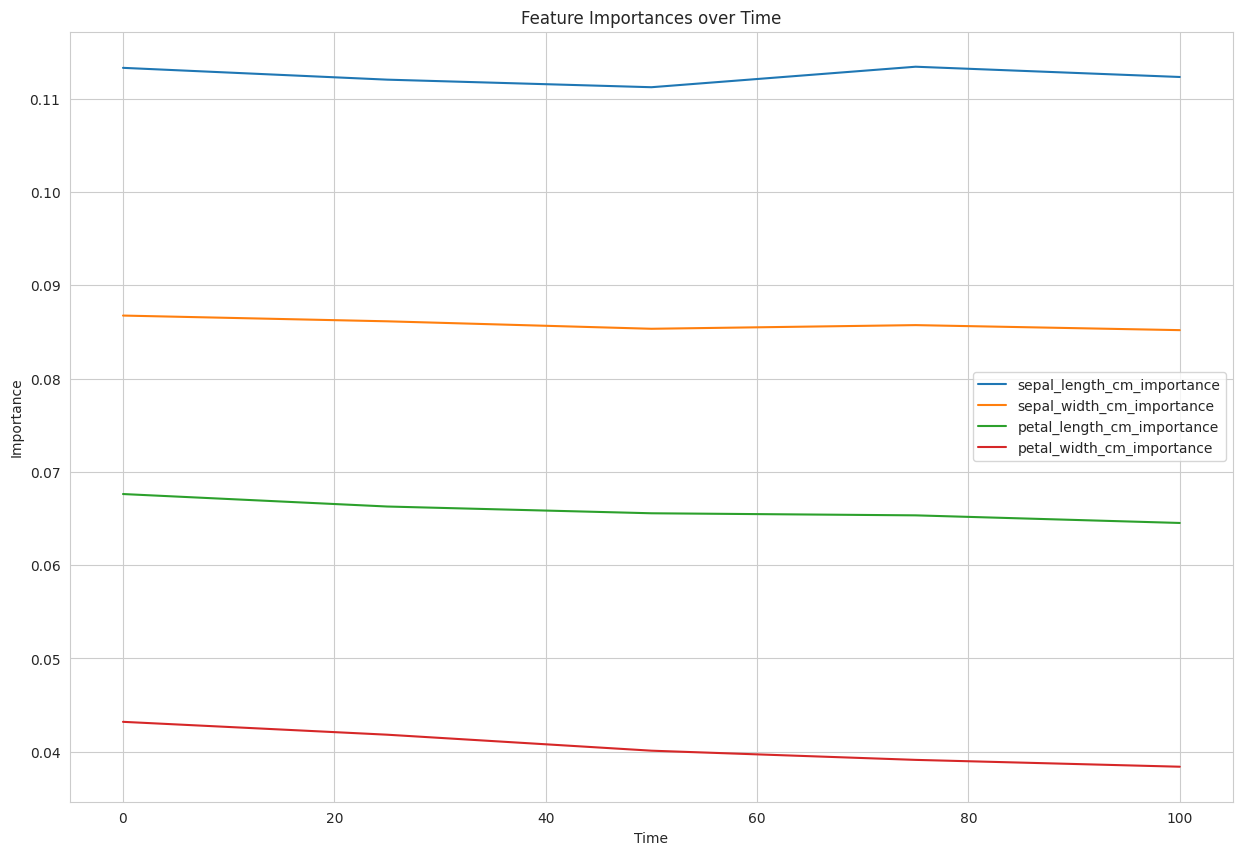

In [81]:
plot_importance(df_importance_lime_100_25_tmp)

In [80]:
with contextlib.redirect_stdout(io.StringIO()):
    df_importance_shap_100_25_tmp = compute_feature_importance_v2_start(time_series_df[:200], model_classifier, scaler,
                                                                        explainer_type="SHAP", window=100, slide=25)
df_importance_shap_100_25_tmp

start  end  sepal_length_cm_importance  sepal_width_cm_importance  \
0      0  100                    0.053433                   0.028733   
1     25  125                    0.054692                   0.030092   
2     50  150                    0.057525                   0.039375   
3     75  175                    0.051392                   0.039575   
4    100  200                    0.053817                   0.039117   

   petal_length_cm_importance  petal_width_cm_importance  
0                    0.074200                   0.039883  
1                    0.069458                   0.036942  
2                    0.063008                   0.054225  
3                    0.068742                   0.052808  
4                    0.078033                   0.050433

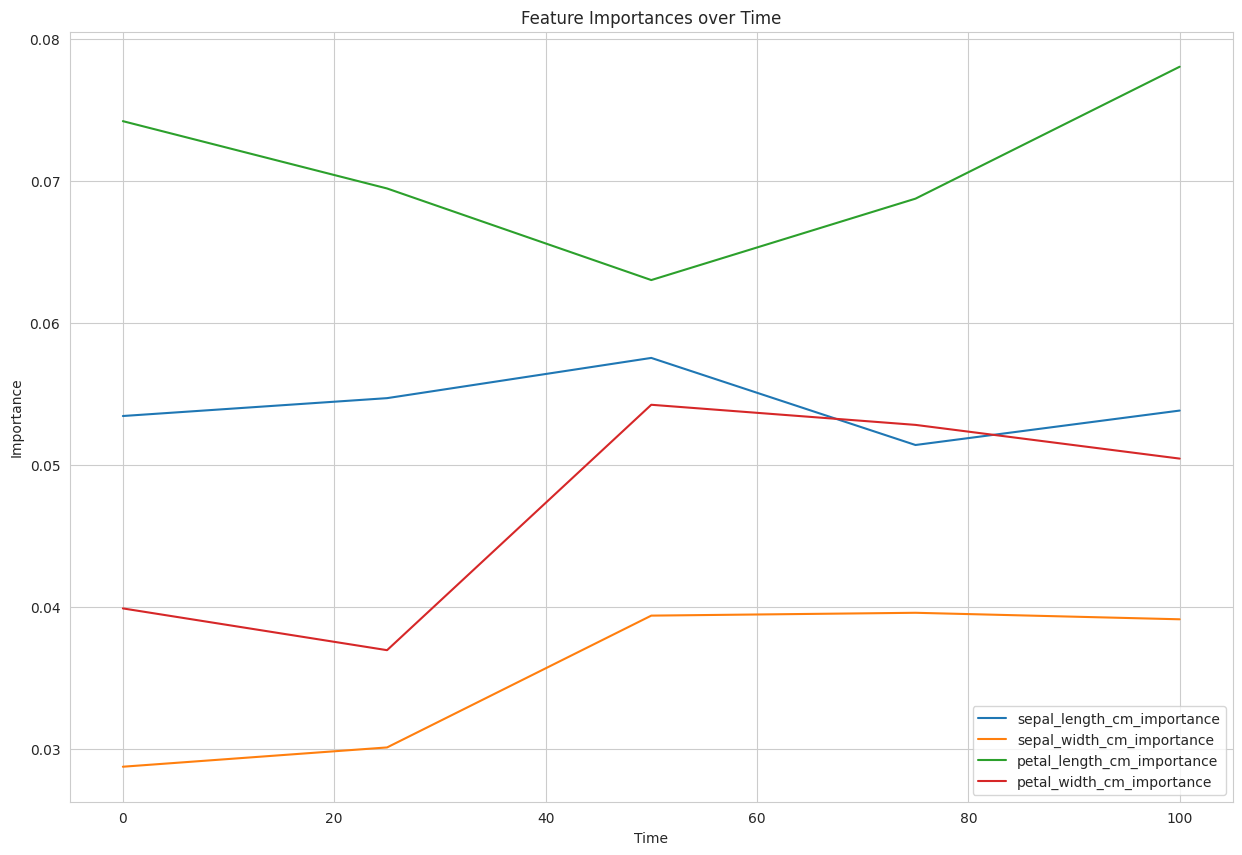

In [82]:
plot_importance(df_importance_shap_100_25_tmp)

In [101]:
with contextlib.redirect_stdout(io.StringIO()):
    df_importance_shap_100_25_start = compute_feature_importance_v2_start(time_series_df, model_classifier, scaler,
                                                                          explainer_type="SHAP", window=100, slide=25)
save_to_pickle(df_importance_shap_100_25_start, 'df_importance_shap_100_25_start.pkl')
df_importance_shap_100_25_start

Saved to fast/inxai/examples/jgama/serialised/df_importance_shap_100_25_start.pkl


start   end  sepal_length_cm_importance  sepal_width_cm_importance  \
0        0   100                    0.053433                   0.028733   
1       25   125                    0.054692                   0.030092   
2       50   150                    0.057525                   0.039375   
3       75   175                    0.051392                   0.039575   
4      100   200                    0.053817                   0.039117   
..     ...   ...                         ...                        ...   
372   9300  9400                    0.099383                   0.056633   
373   9325  9425                    0.082892                   0.053025   
374   9350  9450                    0.100175                   0.054608   
375   9375  9475                    0.098250                   0.055200   
376   9400  9500                    0.098150                   0.049350   

     petal_length_cm_importance  petal_width_cm_importance  
0                      0.074200                   0.039883  
1                      0.069458                   0.036942  
2                      0.063008                   0.054225  
3                      0.068742                   0.052808  
4                      0.078033                   0.050433  
..                          ...                        ...  
372                    0.322983                   0.398583  
373                    0.333325                   0.426392  
374                    0.304308                   0.413958  
375                    0.303433                   0.388550  
376                    0.307983                   0.388333  

[377 rows x 6 columns]

In [48]:
# Read back:
df_importance_shap_100_25_start = load_from_pickle('df_importance_shap_100_25_start.pkl')

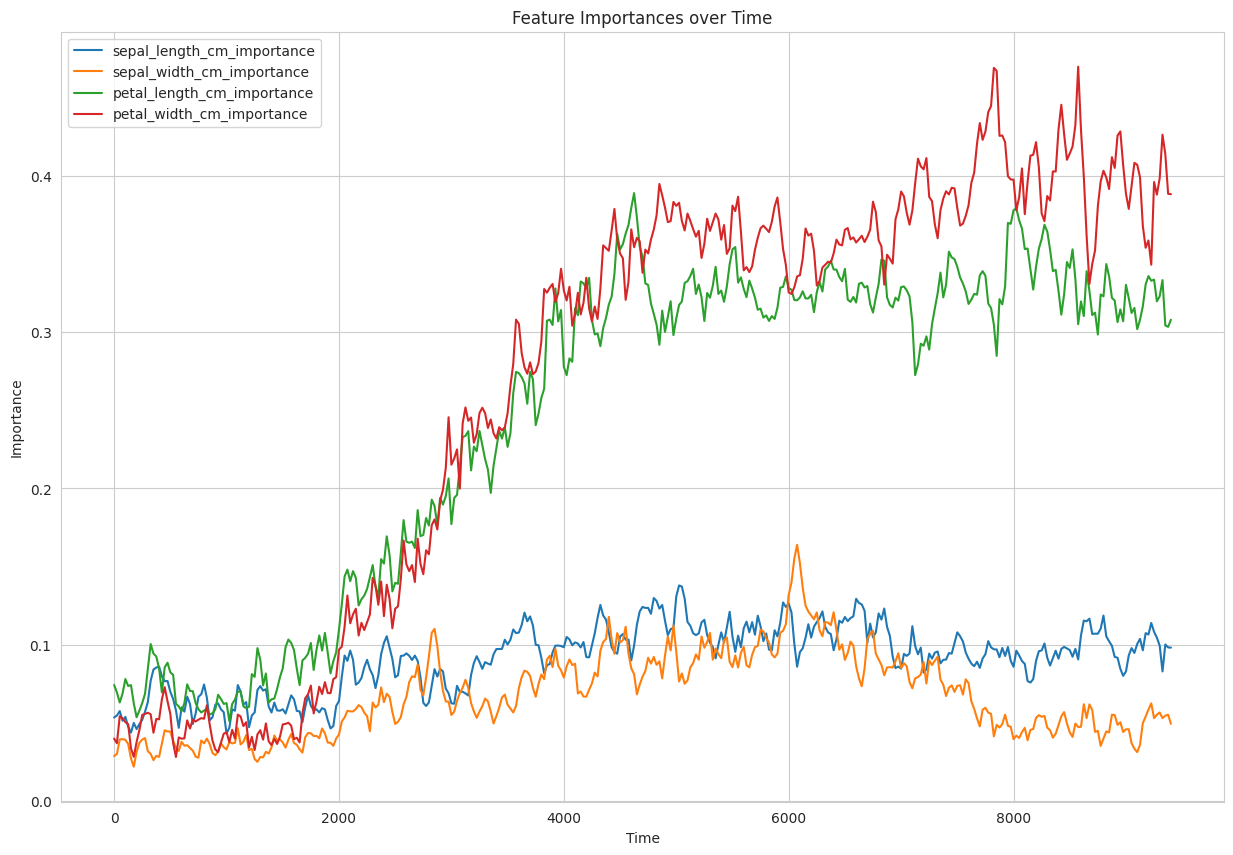

In [53]:
plot_importance(df_importance_shap_100_25_start)

In [54]:
# Statistical test:
p_val_SHAP, result_message_SHAP = test_feature_importance_difference(df_importance_shap_100_25_start, 1000, 0.05)
print(result_message_SHAP)


There are statistically significant differences in the feature importance values across the segments.


### Isolation Forest

Detected change points at: [  0   1   2   3   6   7   8  13  14  15  16  18 112 113 114 115 243 314
 373]


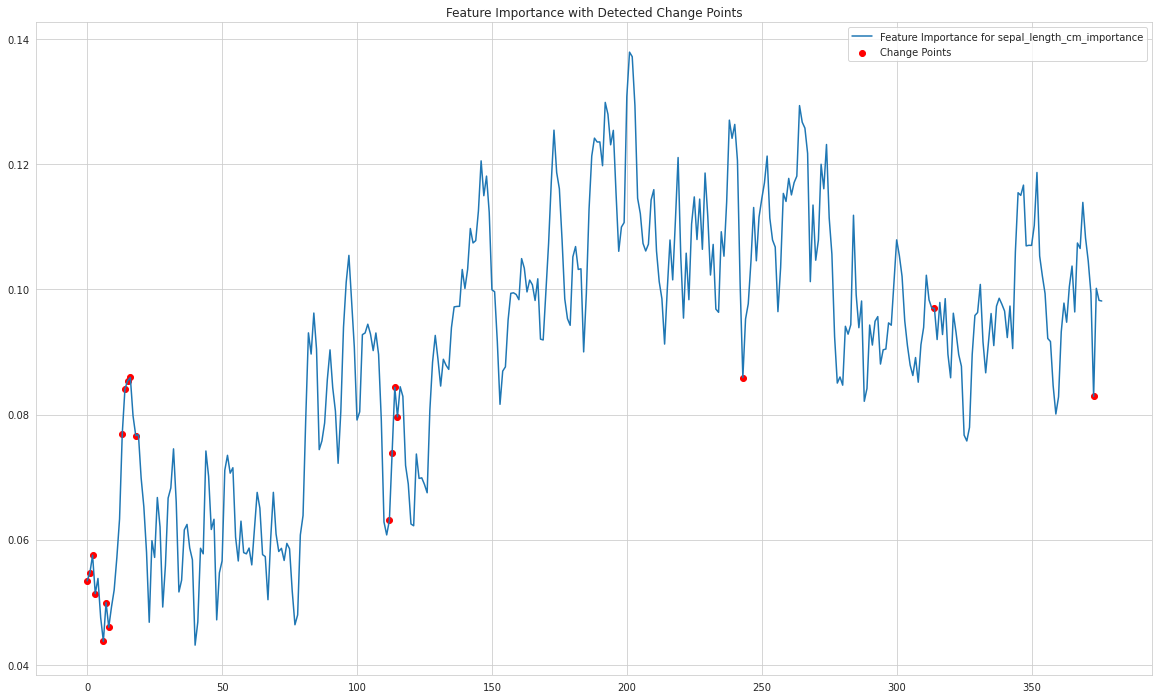

In [196]:
# Przygotuj dane (załóżmy, że df_importance jest DataFrame z ważnością cech dla każdego okna)
X = df_importance_shap_100_25_start.values

# Wytrenuj model izolacji lasu
iso_forest = IsolationForest(contamination=0.05)  # contamination to parametr określający procent obserwacji odstających
anomaly_scores = iso_forest.fit_predict(X)

# Punkty zmian są tam, gdzie anomaly_scores jest -1 (obserwacje odstające)
change_points_iso_forest = np.where(anomaly_scores == -1)[0]

print("Detected change points at:", change_points_iso_forest)

# Wizualizacja
plt.figure(figsize=(20, 12))

# Rysuj ważność cechy 'sepal_length_cm' (jako przykład)
plt.plot(df_importance_shap_100_25_start['sepal_length_cm_importance'],
         label='Feature Importance for sepal_length_cm_importance')
plt.scatter(change_points_iso_forest,
            df_importance_shap_100_25_start['sepal_length_cm_importance'].iloc[change_points_iso_forest], color='red',
            marker='o', label='Change Points')

plt.legend()
plt.title('Feature Importance with Detected Change Points')
plt.show()


Detected change points at: [  0   1   5   6   7   8   9  13  14  15  16  17  18  77  78 113 114 243
 373]


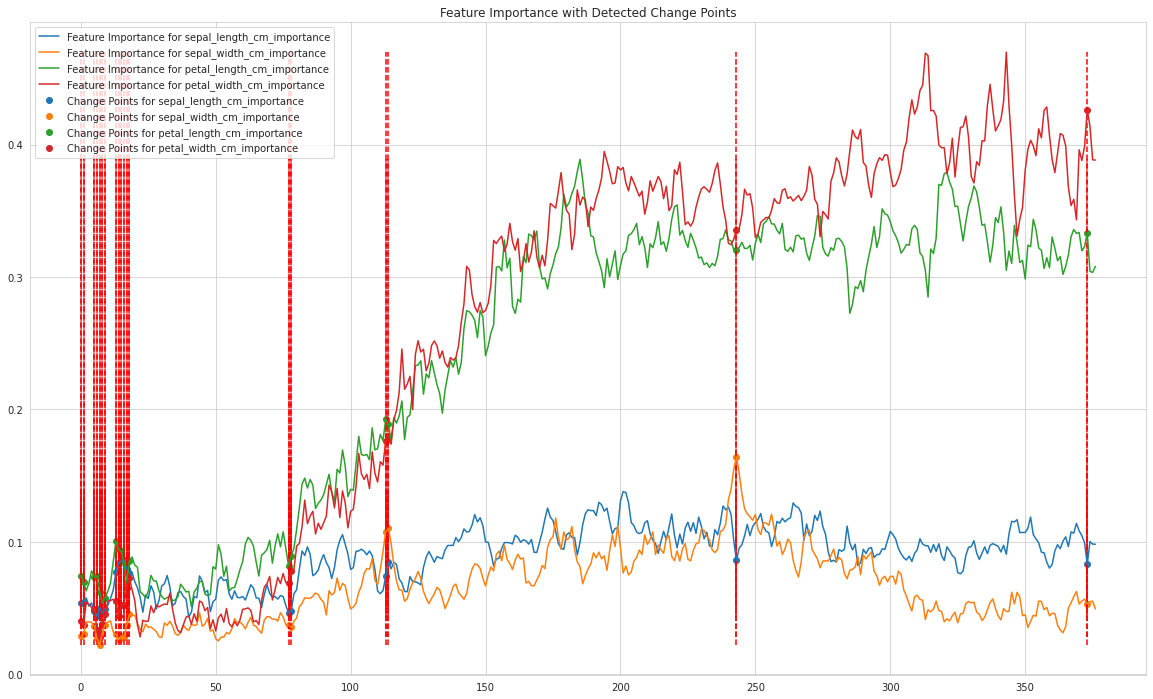

In [230]:
# detect_change_points(df_importance_shap_100_25, 0.05, features_to_plot=['sepal_length_cm_importance', 'sepal_width_cm_importance'])
detect_change_points_isolation_forest(df_importance_shap_100_25_start, 0.05, features_to_plot=[
    'sepal_length_cm_importance', 'sepal_width_cm_importance',
    'petal_length_cm_importance', 'petal_width_cm_importance'
])

location of change = 50.0
location of change = 75.0
location of change = 100.0
location of change = 125.0
location of change = 200.0
location of change = 225.0
location of change = 250.0
location of change = 375.0
location of change = 400.0
location of change = 425.0
location of change = 450.0
location of change = 500.0
location of change = 2850.0
location of change = 2875.0
location of change = 2900.0
location of change = 2925.0
location of change = 6125.0
location of change = 7900.0
location of change = 9375.0


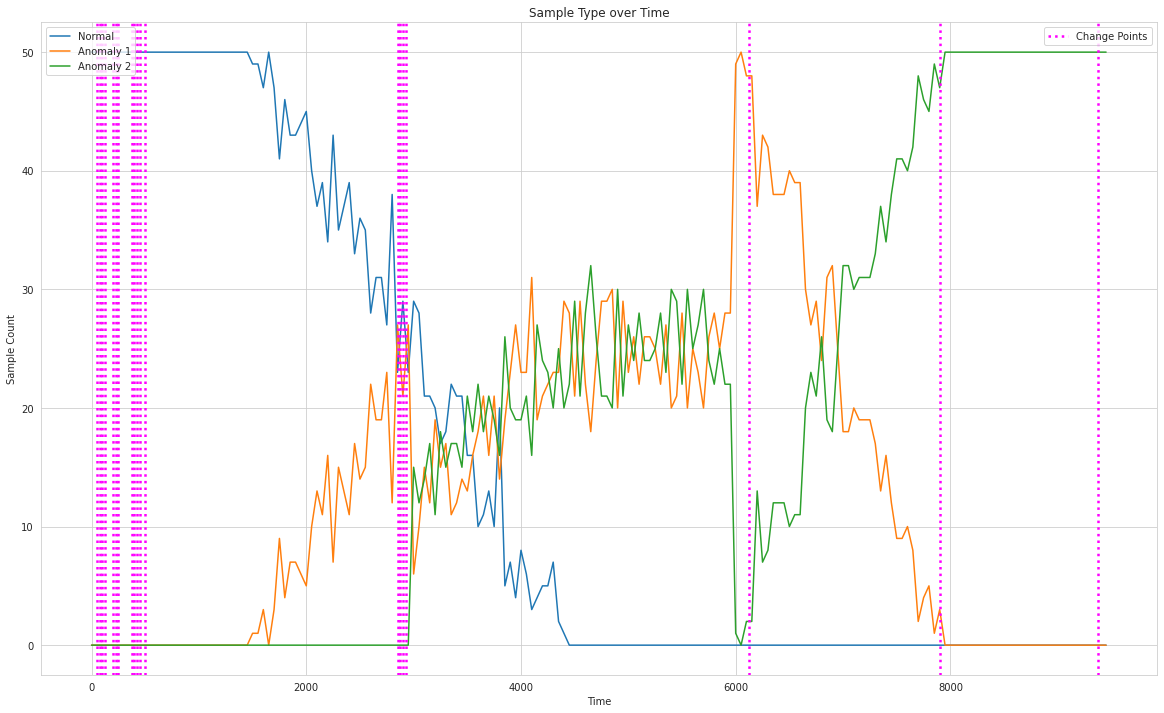

In [197]:
a_window = 100
a_slide = 25
a_df_importance = df_importance_shap_100_25_start

plt.figure(figsize=(20, 12))  # Zwiększenie rozmiaru wykresu

# Rysowanie linii danych
line1, = plt.plot(timestamps, [count['N'] for count in sample_counts], label='Normal')
line2, = plt.plot(timestamps, [count['A1'] for count in sample_counts], label='Anomaly 1')
line3, = plt.plot(timestamps, [count['A2'] for count in sample_counts], label='Anomaly 2')

# Rysowanie grubych, kropkowanych linii pionowych w miejscach wykrytych punktów zmian
for cp in change_points_iso_forest:
    a_cp = (a_df_importance['end'].iloc[cp] + a_df_importance['start'].iloc[cp]) / 2
    print(f"location of change = {a_cp}")
    plt.axvline(x=a_cp, color='magenta', linestyle=':', linewidth=2.5)

# Tworzenie legendy
legend1 = plt.legend([line1, line2, line3], ['Normal', 'Anomaly 1', 'Anomaly 2'], loc="upper left")
custom_lines = [
    Line2D([0], [0], color='magenta', lw=2.5, linestyle=':')  # Linia dla punktów zmian
]
legend2 = plt.legend(custom_lines, [
    'Change Points'
], loc="upper right")  # Dodajemy punkty zmian do legendy

# Add the first legend manually to the current Axes.
plt.gca().add_artist(legend1)

plt.xlabel('Time')
plt.ylabel('Sample Count')
plt.title('Sample Type over Time')

plt.show()

### CUSUM

In [198]:
# For a specific feature importance, say 'sepal_length_cm_importance'
change_points_cusum_sepal_length_cm = detect_change_points_cumsum(
    df_importance_shap_100_25_start['sepal_length_cm_importance'].values)

print("Detected change points at:", change_points_cusum_sepal_length_cm)

Detected change points at: [ 34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213
 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231
 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249
 250 251]


In [ ]:
# TO-DO
# Stability

# Wnioski:
# - cos nie tak z anomaliami
# - xai pozwala odroznic anomalie 

# Spisac wnioski - poczekac na Jao co dalej - dopytac tez czy i gdzie wyslac, ew. sami to opakujemy 

In [ ]:
# https://chat.openai.com/share/a95ff1ce-1dbf-483f-a3e2-189065845497 - code for TS
# https://chat.openai.com/share/dd9e9035-4e24-4d97-99f7-48cbd7f25e34 - email

In [55]:
df_importance_shap_100_25_start[:2]

start  end  sepal_length_cm_importance  sepal_width_cm_importance  \
0      0  100                    0.053433                   0.028733   
1     25  125                    0.054692                   0.030092   

   petal_length_cm_importance  petal_width_cm_importance  
0                    0.074200                   0.039883  
1                    0.069458                   0.036942

## Stability in windows plotted against TS

In [58]:
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_shap_100_25_start_v5, df_individual_shap_100_25_start_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_shap_100_25_start, model_classifier, scaler, n_comparisons=100,
        explainer_type="SHAP", background_data_source='start')
save_to_pickle(df_individual_shap_100_25_start_v5, 'df_individual_shap_100_25_start_v5.pkl')
save_to_pickle(df_stability_shap_100_25_start_v5, 'df_stability_shap_100_25_start_v5.pkl')
df_individual_shap_100_25_start_v5

Saved to fast/inxai/examples/jgama/serialised/df_individual_shap_100_25_start_v5.pkl
Saved to fast/inxai/examples/jgama/serialised/df_stability_shap_100_25_start_v5.pkl


start   end  observation_number  sepal_length_cm_importance  \
0          0   100                   0                   -0.023333   
1          0   100                   1                    0.047500   
2          0   100                   2                   -0.025833   
3          0   100                   3                   -0.013333   
4          0   100                   4                   -0.039167   
...      ...   ...                 ...                         ...   
37695   9400  9500                9495                    0.070000   
37696   9400  9500                9496                   -0.029167   
37697   9400  9500                9497                    0.111667   
37698   9400  9500                9498                    0.580833   
37699   9400  9500                9499                    0.043333   

       sepal_width_cm_importance  petal_length_cm_importance  \
0                      -0.011667                   -0.041667   
1                       0.042500                   -0.089167   
2                      -0.004167                   -0.042500   
3                      -0.011667                   -0.046667   
4                      -0.009167                   -0.022500   
...                          ...                         ...   
37695                  -0.003333                    0.490000   
37696                  -0.017500                    0.875833   
37697                   0.060000                    0.211667   
37698                  -0.035833                    0.004167   
37699                   0.018333                    0.486667   

       petal_width_cm_importance  
0                      -0.013333  
1                      -0.090833  
2                      -0.017500  
3                      -0.018333  
4                      -0.019167  
...                          ...  
37695                   0.353333  
37696                   0.080833  
37697                   0.526667  
37698                   0.360833  
37699                   0.361667  

[37700 rows x 7 columns]

In [49]:
df_individual_shap_100_25_start_v5 = load_from_pickle('df_individual_shap_100_25_start_v5.pkl')
df_stability_shap_100_25_start_v5 = load_from_pickle('df_stability_shap_100_25_start_v5.pkl')

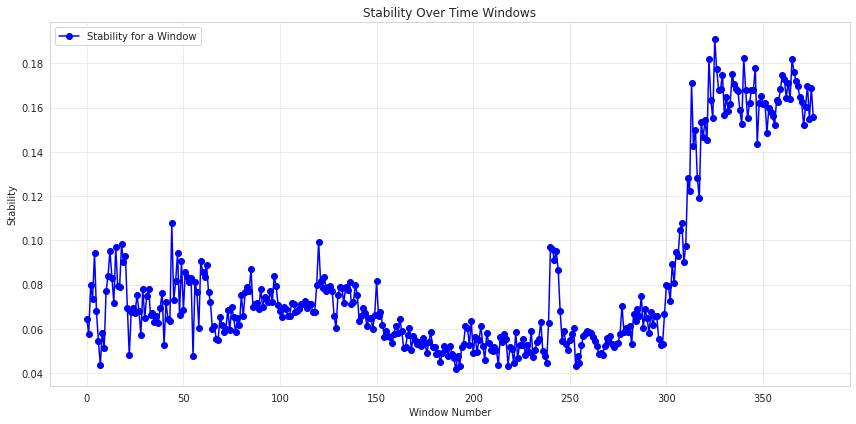

In [54]:
plot_stability(df_stability_shap_100_25_start_v5)

N1_effective= 1500.0


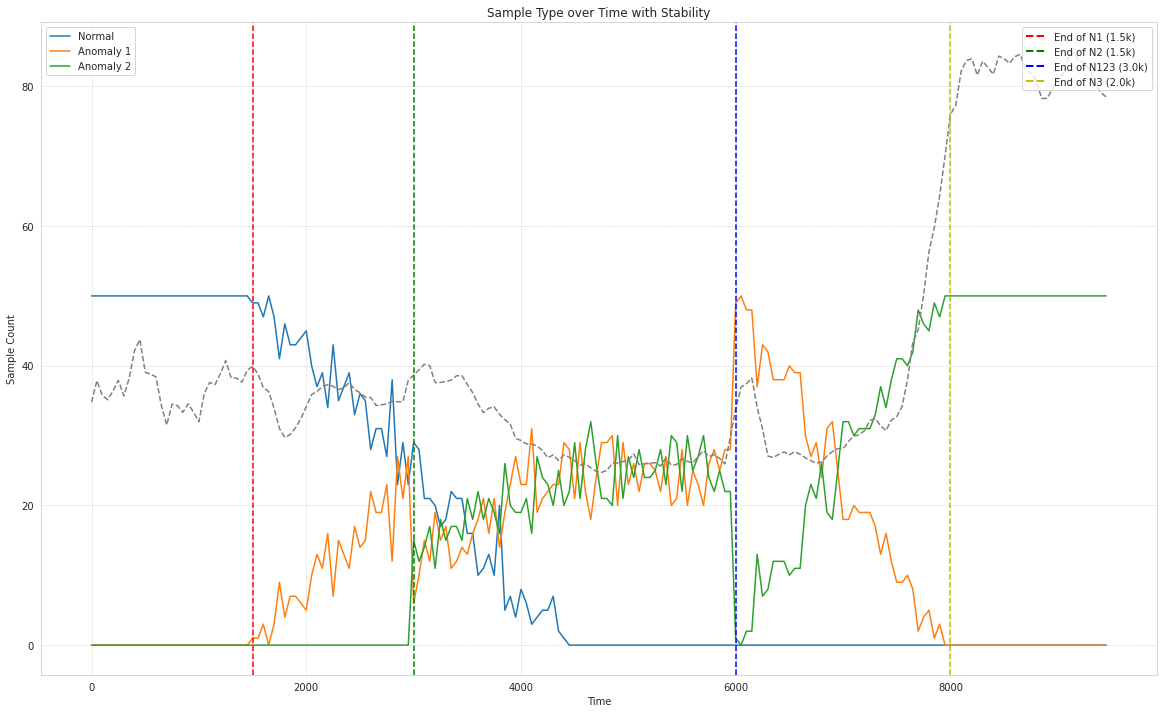

In [83]:
plot_time_series_with_stability(time_series, k, df_stability_shap_100_25_start_v5, smoothing_window=5)

In [ ]:
# TS dłużasza z 1 klasą na końcu
# okno 25

# TODO: 
# - losowac 3 lub wiecej probek i wariancja 
# - change detection for raw features !!

## SHAP comparison for the same observations in different widows

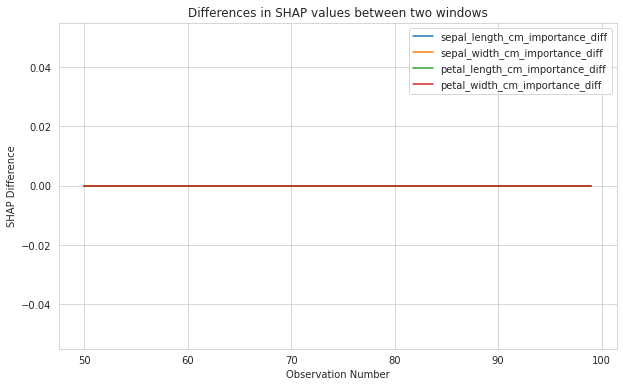

In [84]:
window1 = (0, 100)
window2 = (50, 150)
difference_shap_df = compare_explainer_between_windows(df_individual_shap_100_25_start_v5, window1, window2)

# Plotting SHAP differences
plt.figure(figsize=(10, 6))
for column in ['sepal_length_cm_importance_diff', 'sepal_width_cm_importance_diff', 'petal_length_cm_importance_diff',
               'petal_width_cm_importance_diff']:
    plt.plot(difference_shap_df['observation_number'], difference_shap_df[column], label=column)
plt.legend()
plt.title('Differences in SHAP values between two windows')
plt.xlabel('Observation Number')
plt.ylabel('SHAP Difference')
plt.show()


In [85]:
save_to_pickle(difference_shap_df, 'difference_shap_df_v5.pkl')

Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/difference_shap_df_v5.pkl


In [50]:
difference_shap_df_v5 = load_from_pickle('difference_shap_df_v5.pkl')

In [57]:
# Create the aggregated differences dataframe
df_aggregated_diffs_shap_100_25_start_v5 = aggregate_explainer_differences(df_individual_shap_100_25_start_v5)
save_to_pickle(df_aggregated_diffs_shap_100_25_start_v5, 'df_aggregated_diffs_shap_100_25_start_v5.pkl')
df_aggregated_diffs_shap_100_25_start_v5

Saved to fast/inxai/examples/jgama/serialised/df_aggregated_diffs_shap_100_25_start_v5.pkl


start_w1  end_w1  start_w2  end_w2  sepal_length_cm_mean_diff  \
0             0     100        25     125                        0.0   
1             0     100        50     150                        0.0   
2             0     100        75     175                        0.0   
3             0     100       100     200                        NaN   
4             0     100       125     225                        NaN   
...         ...     ...       ...     ...                        ...   
70871      9325    9425      9375    9475                        0.0   
70872      9325    9425      9400    9500                        0.0   
70873      9350    9450      9375    9475                        0.0   
70874      9350    9450      9400    9500                        0.0   
70875      9375    9475      9400    9500                        0.0   

       sepal_width_cm_mean_diff  petal_length_cm_mean_diff  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
70871                       0.0                        0.0   
70872                       0.0                        0.0   
70873                       0.0                        0.0   
70874                       0.0                        0.0   
70875                       0.0                        0.0   

       petal_width_cm_mean_diff  overall_mean_diff  
0                           0.0                0.0  
1                           0.0                0.0  
2                           0.0                0.0  
3                           NaN                NaN  
4                           NaN                NaN  
...                         ...                ...  
70871                       0.0                0.0  
70872                       0.0                0.0  
70873                       0.0                0.0  
70874                       0.0                0.0  
70875                       0.0                0.0  

[70876 rows x 9 columns]

In [51]:
df_aggregated_diffs_shap_100_25_start_v5 = load_from_pickle('df_aggregated_diffs_shap_100_25_start_v5.pkl')
df_aggregated_diffs_shap_100_25_start_v5

start_w1  end_w1  start_w2  end_w2  sepal_length_cm_mean_diff  \
0             0     100        25     125                        0.0   
1             0     100        50     150                        0.0   
2             0     100        75     175                        0.0   
3             0     100       100     200                        NaN   
4             0     100       125     225                        NaN   
...         ...     ...       ...     ...                        ...   
70871      9325    9425      9375    9475                        0.0   
70872      9325    9425      9400    9500                        0.0   
70873      9350    9450      9375    9475                        0.0   
70874      9350    9450      9400    9500                        0.0   
70875      9375    9475      9400    9500                        0.0   

       sepal_width_cm_mean_diff  petal_length_cm_mean_diff  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
70871                       0.0                        0.0   
70872                       0.0                        0.0   
70873                       0.0                        0.0   
70874                       0.0                        0.0   
70875                       0.0                        0.0   

       petal_width_cm_mean_diff  overall_mean_diff  
0                           0.0                0.0  
1                           0.0                0.0  
2                           0.0                0.0  
3                           NaN                NaN  
4                           NaN                NaN  
...                         ...                ...  
70871                       0.0                0.0  
70872                       0.0                0.0  
70873                       0.0                0.0  
70874                       0.0                0.0  
70875                       0.0                0.0  

[70876 rows x 9 columns]

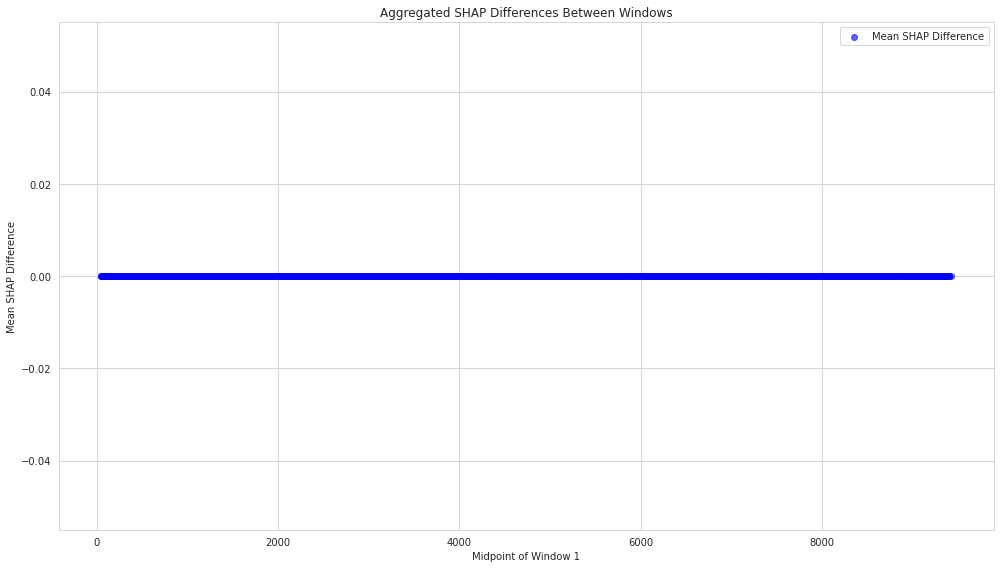

In [88]:
# Plotting aggregated SHAP differences for all windows
# Plotting the aggregated differences
plot_explainer_differences(df_aggregated_diffs_shap_100_25_start_v5)

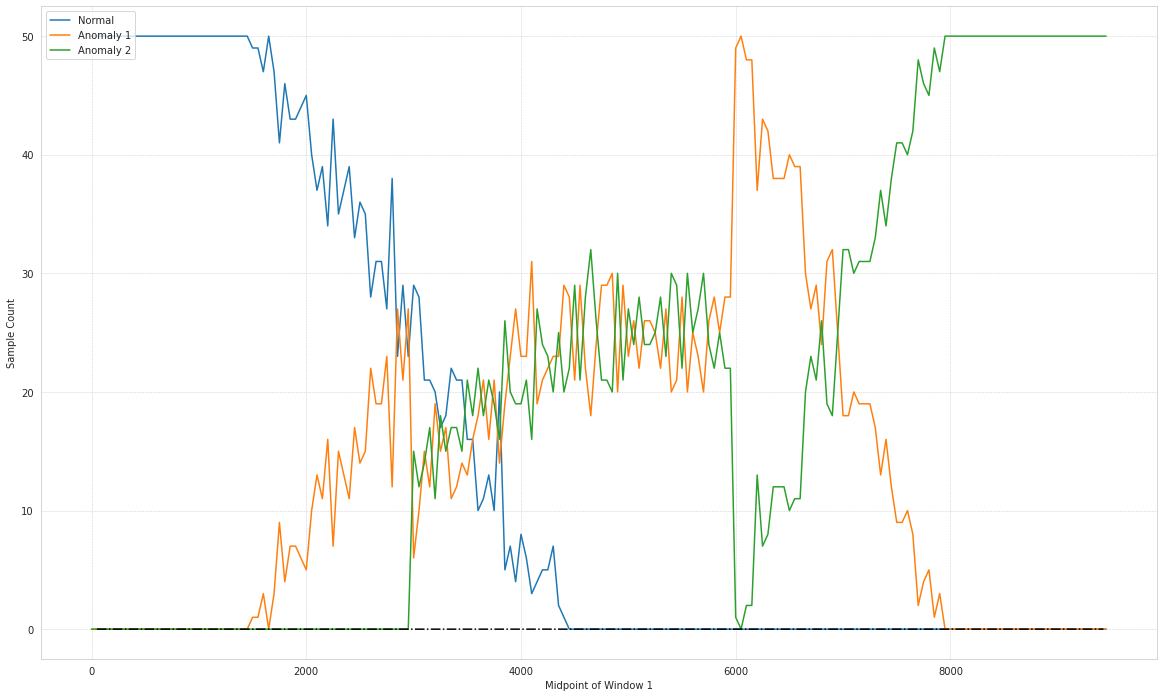

In [89]:
# Plots the time series with the interpolated and optionally smoothed aggregated SHAP differences:
plot_time_series_with_difference(time_series, k, df_aggregated_diffs_shap_100_25_start_v5, smoothing_window=1000)

In [0]:
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_shap_100_25_current_window_v5, df_individual_shap_100_25_current_window_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_shap_100_25_start, model_classifier, scaler, n_comparisons=100,
        explainer_type="SHAP", background_data_source='current_window')

save_to_pickle(df_individual_shap_100_25_current_window_v5, 'df_individual_shap_100_25_current_window_v5.pkl')
save_to_pickle(df_stability_shap_100_25_current_window_v5, 'df_stability_shap_100_25_current_window_v5.pkl')

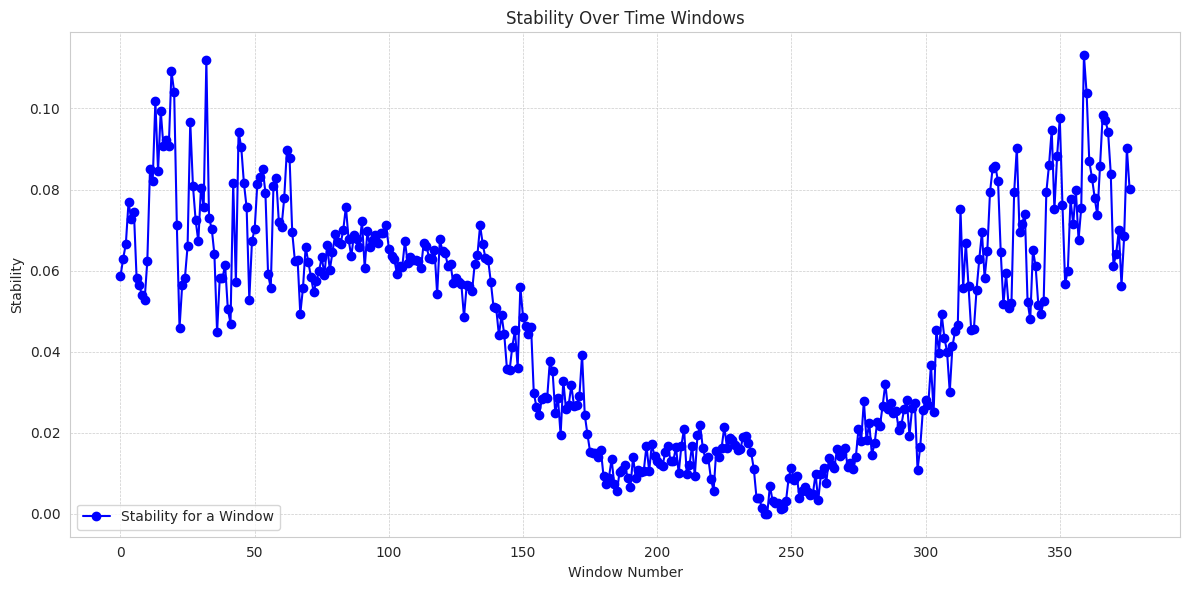

In [52]:
df_individual_shap_100_25_current_window_v5 = load_from_pickle('df_individual_shap_100_25_current_window_v5.pkl')
df_stability_shap_100_25_current_window_v5 = load_from_pickle('df_stability_shap_100_25_current_window_v5.pkl')
plot_stability(df_stability_shap_100_25_current_window_v5)

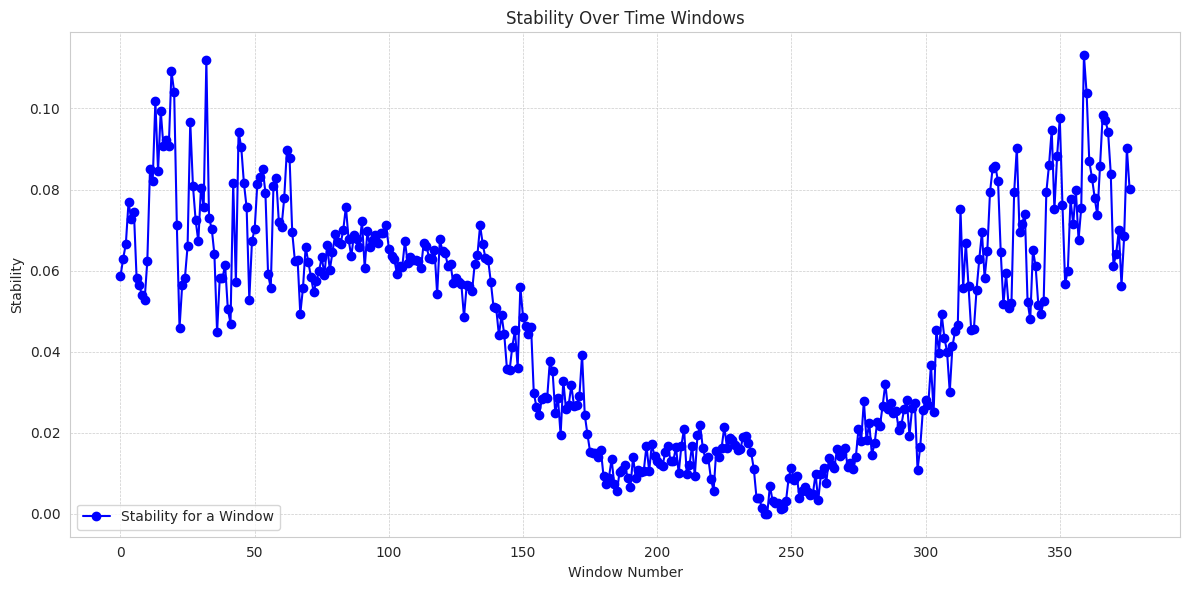

In [51]:
plot_stability(df_stability_shap_100_25_current_window_v5)

N1_effective= 1500.0


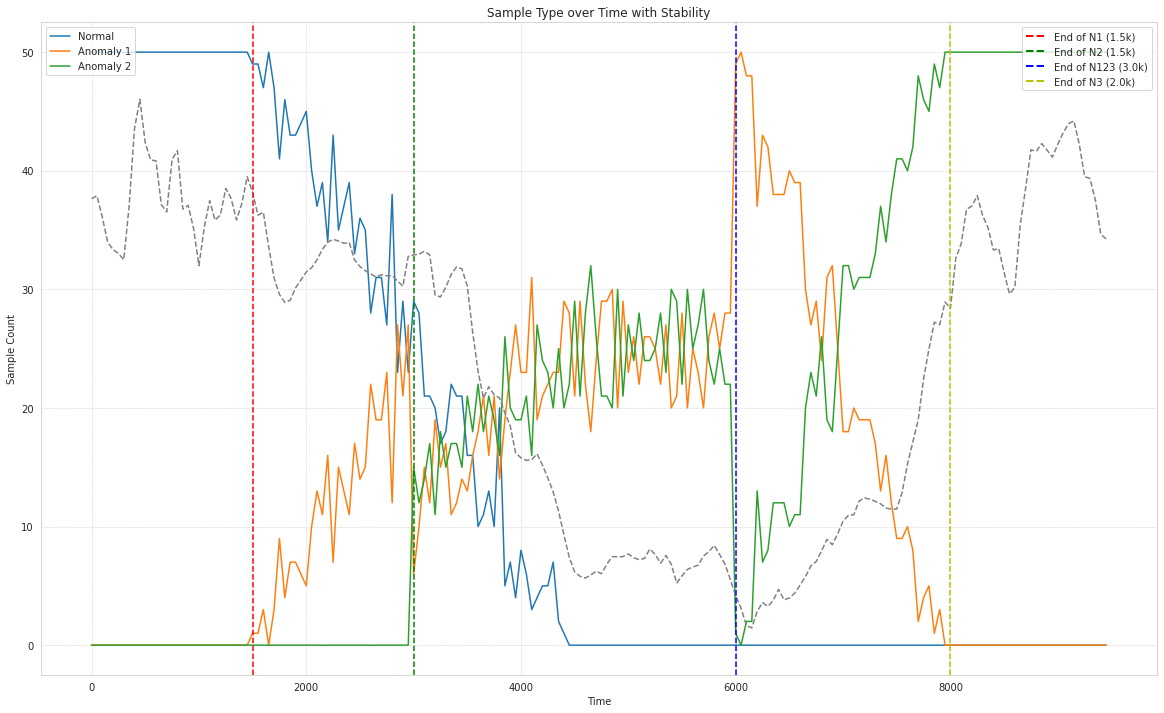

In [65]:
plot_time_series_with_stability(time_series, k, df_stability_shap_100_25_current_window_v5, smoothing_window=5)

In [117]:
# TODO
# 1)
# - SHAP == gracz jest cecha
# - LIME - liniowo - doliczyc żeby porównać 

# 2) Reguły
# NP:
# |--- petal_length_cm <= 3.47
# |   |--- petal_length_cm <= 3.29
# |   |   |--- class: anomaly
# ...
# |--- petal_length_cm >  3.47
# ...
# |   |--- petal_width_cm >  1.72
# |   |   |--- petal_length_cm <= 5.03
# |   |   |   |--- class: anomaly
# ...
# Porownanie: 
# Instancje = euklides
# Wyjasnienia dla pary - podobienstwo w uzytych parametrach = przeciecie zbiorow np 1 - ten sam branch 
# Wyjasnie jako uzycie tej samej cechy:
# Z -> X -> Y
# Z -> Y -> X
# *** edit distance miedzy objasnieniem

# inne podejcie, ktre stosowal SZB: dla kazdej obserwacji nowe drzewo 

# 3) Big picture 
# !!!! Gama jak zmieniaja sie wyjasnienia dla tej samej obserwacji wraz z nowymi danymi i czy roznicuje N i A
# - spada sabilnosc - anomalia
# - jakos wyjasnien - na podstawie stablity????

## LIME

In [215]:
with contextlib.redirect_stdout(io.StringIO()):
    df_importance_lime_100_25_start_tmp = compute_feature_importance_v2_start(time_series_df[:200], model_classifier,
                                                                              scaler, explainer_type="LIME", window=100,
                                                                              slide=25)
df_importance_lime_100_25_start_tmp

start  end  sepal_length_cm_importance  sepal_width_cm_importance  \
0      0  100                    0.114167                   0.087379   
1     25  125                    0.111863                   0.086605   
2     50  150                    0.111496                   0.085110   
3     75  175                    0.113516                   0.085789   
4    100  200                    0.111633                   0.085212   

   petal_length_cm_importance  petal_width_cm_importance  
0                    0.067372                   0.043236  
1                    0.066348                   0.042314  
2                    0.064910                   0.040331  
3                    0.066069                   0.040062  
4                    0.063923                   0.037241

In [100]:
with contextlib.redirect_stdout(io.StringIO()):
    df_importance_lime_100_25_start = compute_feature_importance_v2_start(time_series_df, model_classifier, scaler,
                                                                          explainer_type="LIME", window=100, slide=25)
save_to_pickle(df_importance_lime_100_25_start, 'df_importance_lime_100_25_start.pkl')
df_importance_lime_100_25_start

Saved to fast/inxai/examples/jgama/serialised/df_importance_lime_100_25_start.pkl


start   end  sepal_length_cm_importance  sepal_width_cm_importance  \
0        0   100                    0.113850                   0.087918   
1       25   125                    0.111755                   0.086728   
2       50   150                    0.111190                   0.085735   
3       75   175                    0.114239                   0.086938   
4      100   200                    0.112713                   0.084886   
..     ...   ...                         ...                        ...   
372   9300  9400                    0.104631                   0.075022   
373   9325  9425                    0.104572                   0.075178   
374   9350  9450                    0.104962                   0.076309   
375   9375  9475                    0.104921                   0.076602   
376   9400  9500                    0.105525                   0.077001   

     petal_length_cm_importance  petal_width_cm_importance  
0                      0.068155                   0.042797  
1                      0.066532                   0.041184  
2                      0.065281                   0.040514  
3                      0.064778                   0.040311  
4                      0.063713                   0.037850  
..                          ...                        ...  
372                    0.055721                   0.020183  
373                    0.056224                   0.020118  
374                    0.058490                   0.022448  
375                    0.057857                   0.023403  
376                    0.059059                   0.024887  

[377 rows x 6 columns]

In [53]:
# results differ between runs
df_importance_lime_100_25_start = load_from_pickle('df_importance_lime_100_25_start.pkl')
# df_importance_lime_100_25_start

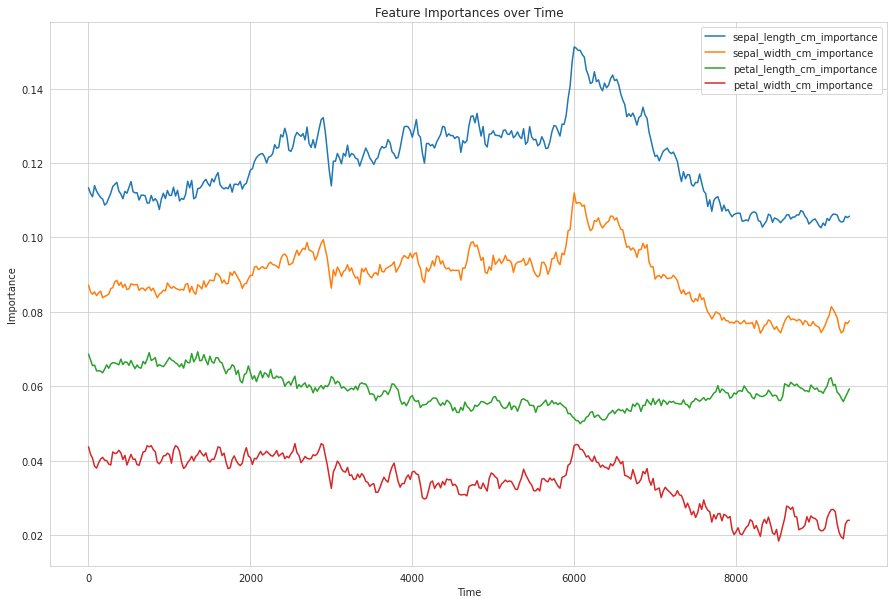

In [219]:
plot_importance(df_importance_lime_100_25_start)

In [222]:
p_val, result_message = test_feature_importance_difference(df_importance_lime_100_25_start, 1000, 0.05)
print(result_message)

There are statistically significant differences in the feature importance values across the segments.


Detected change points at: [  0   4   7   8 115 116 120 239 240 241 242 243 244 245 362 366 367 372
 373]


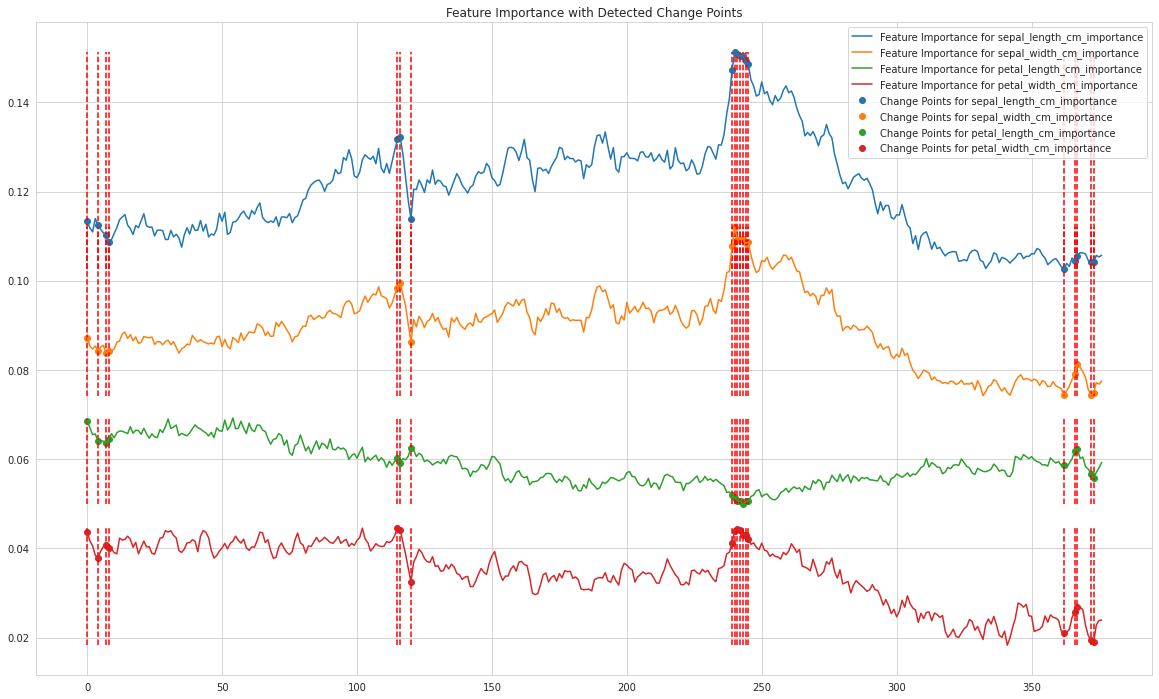

In [229]:
### Isolation Forest
detect_change_points_isolation_forest(df_importance_lime_100_25_start, 0.05, features_to_plot=[
    'sepal_length_cm_importance', 'sepal_width_cm_importance',
    'petal_length_cm_importance', 'petal_width_cm_importance'
])

In [ ]:
## Stability in windows plotted against TS
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_lime_100_25_current_window_v5, df_individual_lime_100_25_current_window_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_lime_100_25_start, model_classifier, scaler, n_comparisons=100,
        explainer_type="LIME", background_data_source='current_window')
save_to_pickle(df_stability_lime_100_25_current_window_v5, 'df_stability_lime_100_25_current_window_v5.pkl')
save_to_pickle(df_individual_lime_100_25_current_window_v5, 'df_individual_lime_100_25_current_window_v5.pkl')

In [54]:
# when rerunning, the result is different
df_stability_lime_100_25_current_window_v5 = load_from_pickle('df_stability_lime_100_25_current_window_v5.pkl')
df_individual_lime_100_25_current_window_v5 = load_from_pickle('df_individual_lime_100_25_current_window_v5.pkl')
df_individual_lime_100_25_current_window_v5

start   end  observation_number  sepal_length_cm_importance  \
0          0   100                   0                   -0.105880   
1          0   100                   1                   -0.075453   
2          0   100                   2                   -0.087583   
3          0   100                   3                    0.153393   
4          0   100                   4                    0.096106   
...      ...   ...                 ...                         ...   
37695   9400  9500                9495                    0.084362   
37696   9400  9500                9496                   -0.171124   
37697   9400  9500                9497                    0.082765   
37698   9400  9500                9498                   -0.207143   
37699   9400  9500                9499                    0.054783   

       sepal_width_cm_importance  petal_length_cm_importance  \
0                      -0.097784                   -0.068448   
1                      -0.070395                    0.038088   
2                       0.053549                    0.050500   
3                      -0.081422                   -0.072334   
4                       0.089051                    0.078528   
...                          ...                         ...   
37695                   0.080283                    0.058551   
37696                   0.069852                   -0.041563   
37697                  -0.010036                   -0.007033   
37698                  -0.149809                   -0.047385   
37699                   0.053945                    0.043400   

       petal_width_cm_importance  
0                       0.045142  
1                      -0.007554  
2                      -0.006535  
3                      -0.054452  
4                      -0.005282  
...                          ...  
37695                  -0.012072  
37696                  -0.034582  
37697                   0.001497  
37698                  -0.014210  
37699                   0.008439  

[37700 rows x 7 columns]

In [91]:
# previous run
df_individual_lime_100_25_current_window_v5

start   end  observation_number  sepal_length_cm_importance  \
0          0   100                   0                   -0.107874   
1          0   100                   1                   -0.078894   
2          0   100                   2                   -0.078361   
3          0   100                   3                    0.151279   
4          0   100                   4                    0.099314   
...      ...   ...                 ...                         ...   
37695   9400  9500                9495                    0.104193   
37696   9400  9500                9496                    0.108507   
37697   9400  9500                9497                    0.111161   
37698   9400  9500                9498                    0.159586   
37699   9400  9500                9499                    0.102077   

       sepal_width_cm_importance  petal_length_cm_importance  \
0                      -0.100510                   -0.074302   
1                      -0.059906                    0.050962   
2                       0.045324                    0.042878   
3                      -0.082197                   -0.069361   
4                       0.086400                    0.063294   
...                          ...                         ...   
37695                   0.071606                    0.043650   
37696                  -0.088658                    0.070672   
37697                   0.067493                    0.047494   
37698                  -0.107267                    0.102860   
37699                   0.073722                    0.042112   

       petal_width_cm_importance  
0                       0.050828  
1                      -0.014033  
2                      -0.005484  
3                      -0.060377  
4                      -0.005402  
...                          ...  
37695                  -0.005402  
37696                  -0.058270  
37697                  -0.019367  
37698                  -0.071430  
37699                  -0.013970  

[37700 rows x 7 columns]

In [61]:
# this version use backround == first window; previous used current window
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_lime_100_25_start_v5, df_individual_lime_100_25_start_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_lime_100_25_start, model_classifier, scaler, n_comparisons=100,
        explainer_type="LIME", background_data_source='start')
save_to_pickle(df_stability_lime_100_25_start_v5, 'df_stability_lime_100_25_start_v5.pkl')
save_to_pickle(df_individual_lime_100_25_start_v5, 'df_individual_lime_100_25_start_v5.pkl')
df_individual_lime_100_25_start_v5

Saved to fast/inxai/examples/jgama/serialised/df_stability_lime_100_25_start_v5
Saved to fast/inxai/examples/jgama/serialised/df_individual_lime_100_25_start_v5


start   end  observation_number  sepal_length_cm_importance  \
0          0   100                   0                   -0.108566   
1          0   100                   1                   -0.084145   
2          0   100                   2                   -0.075262   
3          0   100                   3                    0.151817   
4          0   100                   4                    0.103574   
...      ...   ...                 ...                         ...   
37695   9400  9500                9495                    0.101428   
37696   9400  9500                9496                    0.106299   
37697   9400  9500                9497                    0.114677   
37698   9400  9500                9498                    0.149644   
37699   9400  9500                9499                    0.103096   

       sepal_width_cm_importance  petal_length_cm_importance  \
0                      -0.102057                   -0.072122   
1                      -0.074742                    0.051776   
2                       0.051306                    0.046369   
3                      -0.083647                   -0.065447   
4                       0.092515                    0.066636   
...                          ...                         ...   
37695                   0.065294                    0.047568   
37696                  -0.087585                    0.074516   
37697                   0.067397                    0.044280   
37698                  -0.107286                    0.101317   
37699                   0.069746                    0.049085   

       petal_width_cm_importance  
0                       0.043728  
1                      -0.014134  
2                      -0.020356  
3                      -0.056284  
4                      -0.009067  
...                          ...  
37695                  -0.014347  
37696                  -0.054047  
37697                  -0.003829  
37698                  -0.071053  
37699                  -0.011655  

[37700 rows x 7 columns]

In [60]:
! cd fast/inxai/examples/jgama/serialised && wget https://github.com/sbobek/inxai/blob/time-series/examples/jgama/serialised/df_stability_lime_100_25_start_v5.pkl
! cd fast/inxai/examples/jgama/serialised && wget https://github.com/sbobek/inxai/blob/time-series/examples/jgama/serialised/df_individual_lime_100_25_start_v5.pkl

--2023-12-11 12:47:28--  https://github.com/sbobek/inxai/blob/time-series/examples/jgama/serialised/df_stability_lime_100_25_start_v5
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15258 (15K) [text/plain]
Saving to: ‘df_stability_lime_100_25_start_v5.1’

df_stability_lime_1 100%[===================>]  14.90K  --.-KB/s    in 0.02s   

2023-12-11 12:47:29 (660 KB/s) - ‘df_stability_lime_100_25_start_v5.1’ saved [15258/15258]

--2023-12-11 12:47:29--  https://github.com/sbobek/inxai/blob/time-series/examples/jgama/serialised/df_individual_lime_100_25_start_v5
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15376 (15K) [text/plain]
Saving to: ‘df_individual_lime_100_25_start_v5.1’

df_individual_lime_ 100%[===================>]  15.02K  -

In [55]:
df_stability_lime_100_25_start_v5 = load_from_pickle('df_stability_lime_100_25_start_v5.pkl') 
df_individual_lime_100_25_start_v5 = load_from_pickle('df_individual_lime_100_25_start_v5.pkl')
df_individual_lime_100_25_start_v5

start   end  observation_number  sepal_length_cm_importance  \
0          0   100                   0                   -0.108566   
1          0   100                   1                   -0.084145   
2          0   100                   2                   -0.075262   
3          0   100                   3                    0.151817   
4          0   100                   4                    0.103574   
...      ...   ...                 ...                         ...   
37695   9400  9500                9495                    0.101428   
37696   9400  9500                9496                    0.106299   
37697   9400  9500                9497                    0.114677   
37698   9400  9500                9498                    0.149644   
37699   9400  9500                9499                    0.103096   

       sepal_width_cm_importance  petal_length_cm_importance  \
0                      -0.102057                   -0.072122   
1                      -0.074742                    0.051776   
2                       0.051306                    0.046369   
3                      -0.083647                   -0.065447   
4                       0.092515                    0.066636   
...                          ...                         ...   
37695                   0.065294                    0.047568   
37696                  -0.087585                    0.074516   
37697                   0.067397                    0.044280   
37698                  -0.107286                    0.101317   
37699                   0.069746                    0.049085   

       petal_width_cm_importance  
0                       0.043728  
1                      -0.014134  
2                      -0.020356  
3                      -0.056284  
4                      -0.009067  
...                          ...  
37695                  -0.014347  
37696                  -0.054047  
37697                  -0.003829  
37698                  -0.071053  
37699                  -0.011655  

[37700 rows x 7 columns]

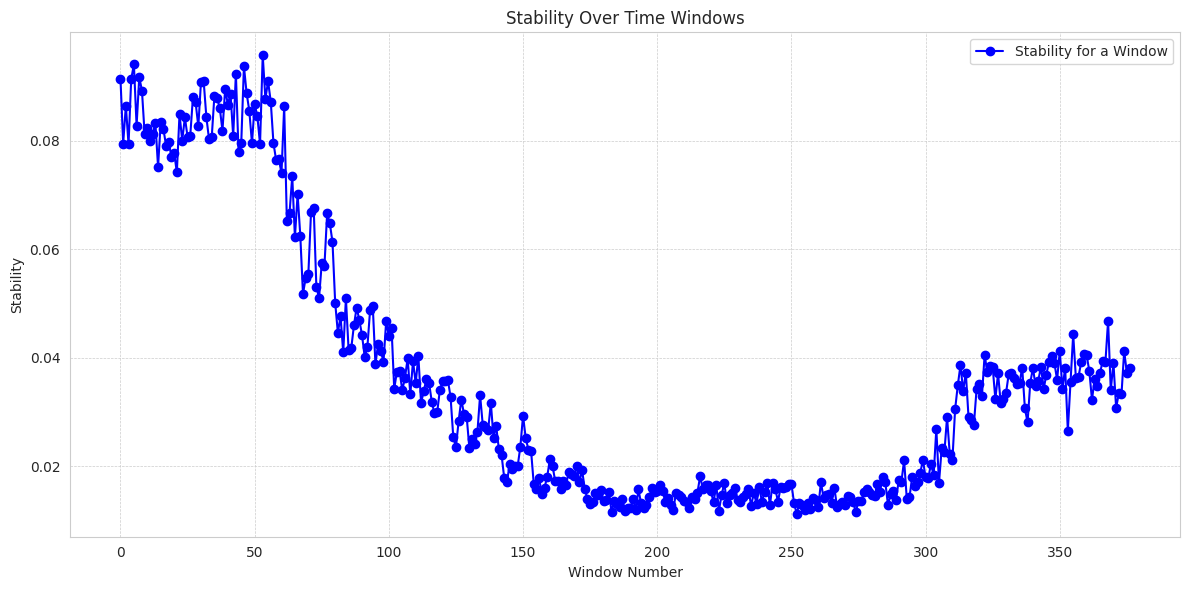

In [63]:
plot_stability(df_stability_lime_100_25_start_v5)

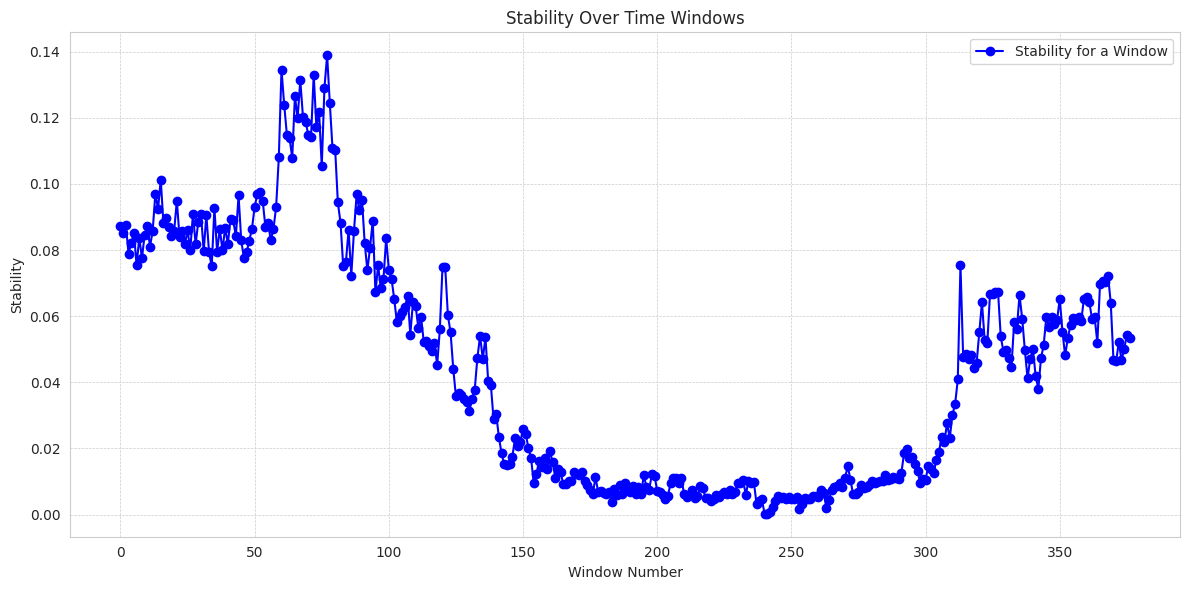

In [64]:
plot_stability(df_stability_lime_100_25_current_window_v5)

N1_effective= 1500.0


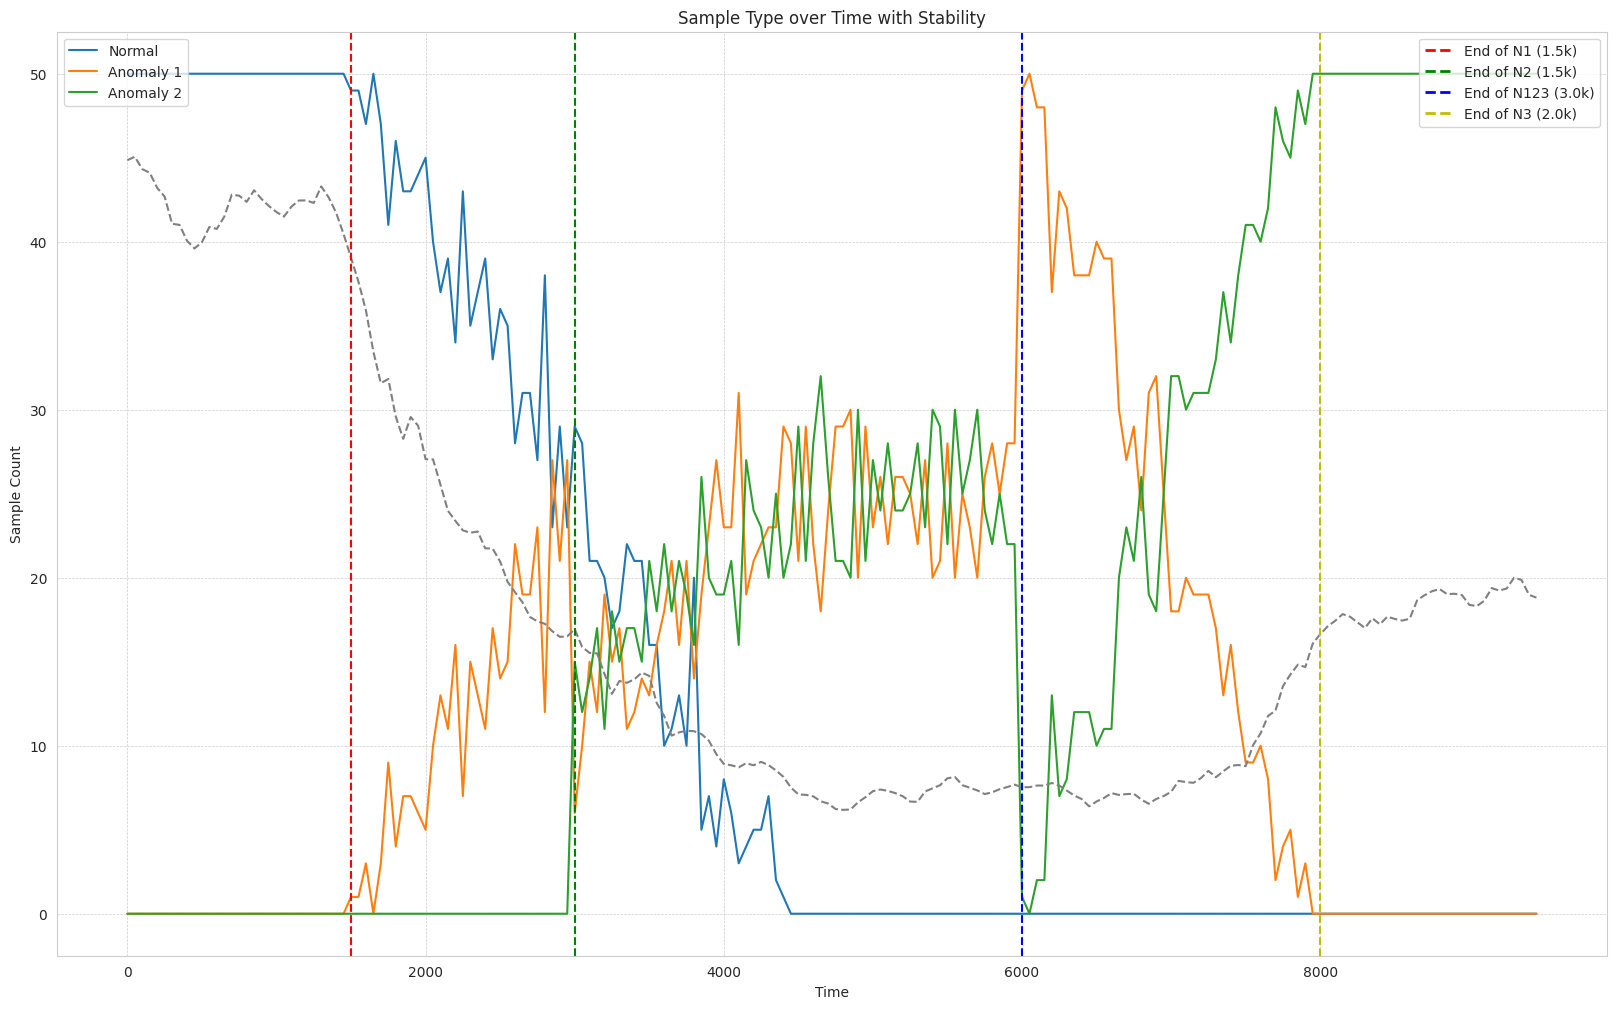

In [65]:
plot_time_series_with_stability(time_series, k, df_stability_lime_100_25_start_v5, smoothing_window=5)

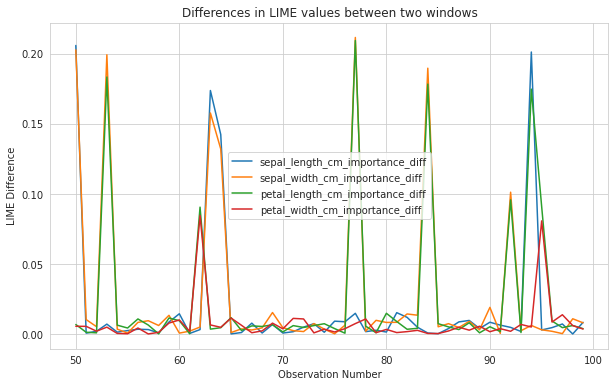

In [260]:
## LIME comparison for the same observations in different widows
window1 = (0, 100)
window2 = (50, 150)
difference_lime_df = compare_explainer_between_windows(df_individual_lime_100_25_current_window_v5, window1, window2)

# Plotting SHAP differences
plt.figure(figsize=(10, 6))
for column in ['sepal_length_cm_importance_diff', 'sepal_width_cm_importance_diff', 'petal_length_cm_importance_diff',
               'petal_width_cm_importance_diff']:
    plt.plot(difference_lime_df['observation_number'], difference_lime_df[column], label=column)
plt.legend()
plt.title('Differences in LIME values between two windows')
plt.xlabel('Observation Number')
plt.ylabel('LIME Difference')
plt.show()

In [261]:
save_to_pickle(difference_lime_df, 'difference_lime_df.pkl')

Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/difference_lime_df.pkl


In [262]:
# Create the aggregated differences dataframe
df_aggregated_diffs_lime_100_25 = aggregate_explainer_differences(df_individual_lime_100_25_current_window_v5)

In [0]:
save_to_pickle(df_aggregated_diffs_lime_100_25, 'df_aggregated_diffs_lime_100_25.pkl')

In [56]:
df_aggregated_diffs_lime_100_25 = load_from_pickle('df_aggregated_diffs_lime_100_25.pkl')
df_aggregated_diffs_lime_100_25

start_w1  end_w1  start_w2  end_w2  sepal_length_cm_mean_diff  \
0             0     100        25     125                   0.014659   
1             0     100        50     150                   0.018925   
2             0     100        75     175                   0.017216   
3             0     100       100     200                        NaN   
4             0     100       125     225                        NaN   
...         ...     ...       ...     ...                        ...   
70871      9325    9425      9375    9475                   0.010058   
70872      9325    9425      9400    9500                   0.014739   
70873      9350    9450      9375    9475                   0.009309   
70874      9350    9450      9400    9500                   0.008871   
70875      9375    9475      9400    9500                   0.009620   

       sepal_width_cm_mean_diff  petal_length_cm_mean_diff  \
0                      0.019871                   0.024659   
1                      0.029028                   0.024931   
2                      0.030522                   0.011012   
3                           NaN                        NaN   
4                           NaN                        NaN   
...                         ...                        ...   
70871                  0.015013                   0.017355   
70872                  0.011981                   0.013020   
70873                  0.016211                   0.014099   
70874                  0.021211                   0.018889   
70875                  0.019092                   0.018294   

       petal_width_cm_mean_diff  overall_mean_diff  
0                      0.012914           0.018026  
1                      0.007607           0.020123  
2                      0.008035           0.016696  
3                           NaN                NaN  
4                           NaN                NaN  
...                         ...                ...  
70871                  0.010537           0.013241  
70872                  0.011525           0.012816  
70873                  0.004916           0.011134  
70874                  0.007101           0.014018  
70875                  0.007162           0.013542  

[70876 rows x 9 columns]

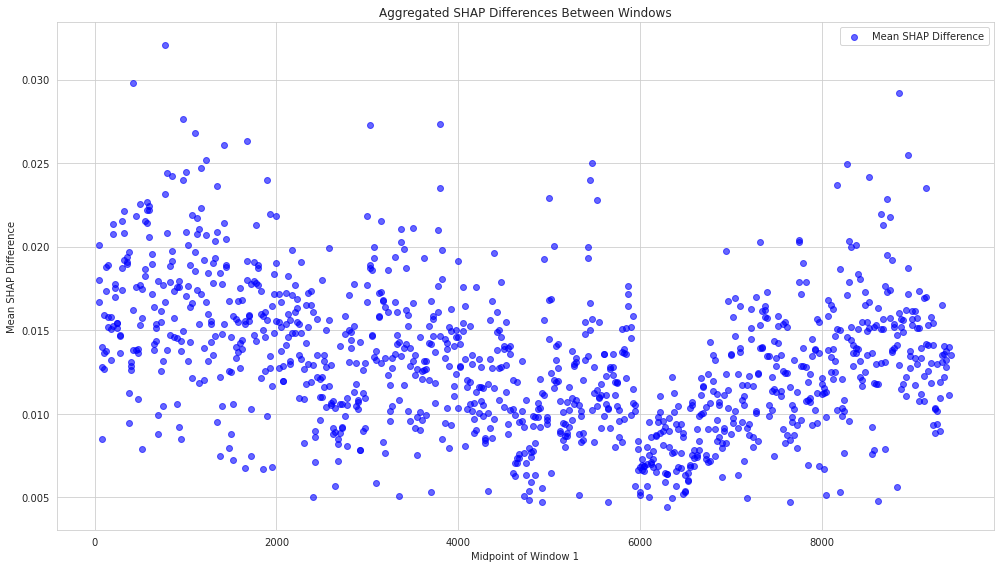

In [264]:
# Plotting the aggregated differences
plot_explainer_differences(df_aggregated_diffs_lime_100_25)

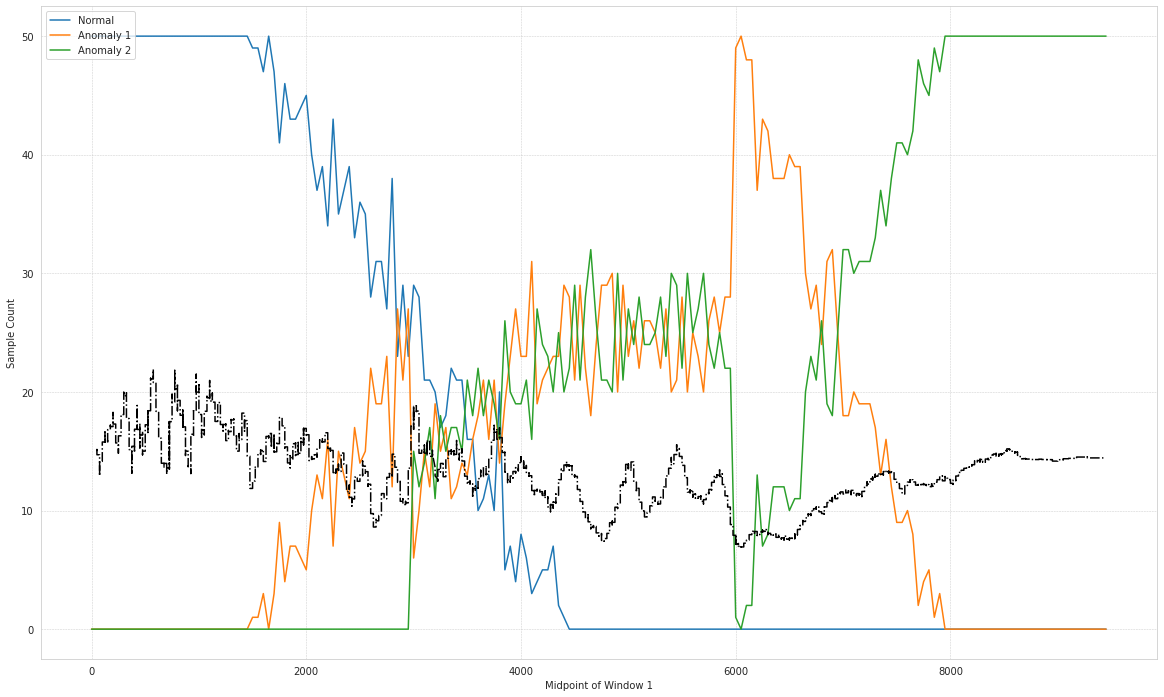

In [265]:
plot_time_series_with_difference(time_series, k, df_aggregated_diffs_lime_100_25, smoothing_window=1000)

In [57]:
# with contextlib.redirect_stdout(io.StringIO()):
#     df_stability_lime_100_25_current_window, df_individual_lime_100_25_current_window = compute_stability_in_windows_v5_start_or_current_window(time_series_df, df_importance_shap_100_25_start, model_classifier, scaler, n_comparisons=100, explainer_type ="LIME", background_data_source='current_window')
# 
# save_to_pickle(df_individual_lime_100_25_current_window, 'df_individual_lime_100_25_current_window.pkl')
# save_to_pickle(df_stability_lime_100_25_current_window, 'df_stability_lime_100_25_current_window.pkl')

Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/df_individual_lime_100_25_current_window.pkl
Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/df_stability_lime_100_25_current_window.pkl


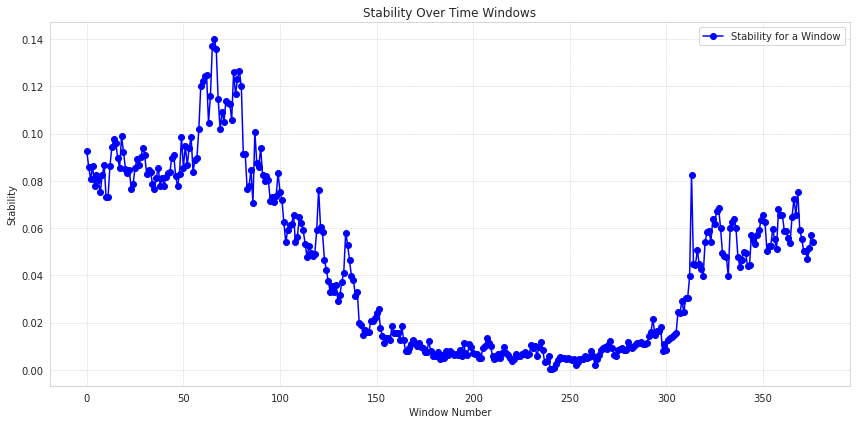

In [62]:
plot_stability(df_stability_lime_100_25_current_window_v5)

N1_effective= 1500.0


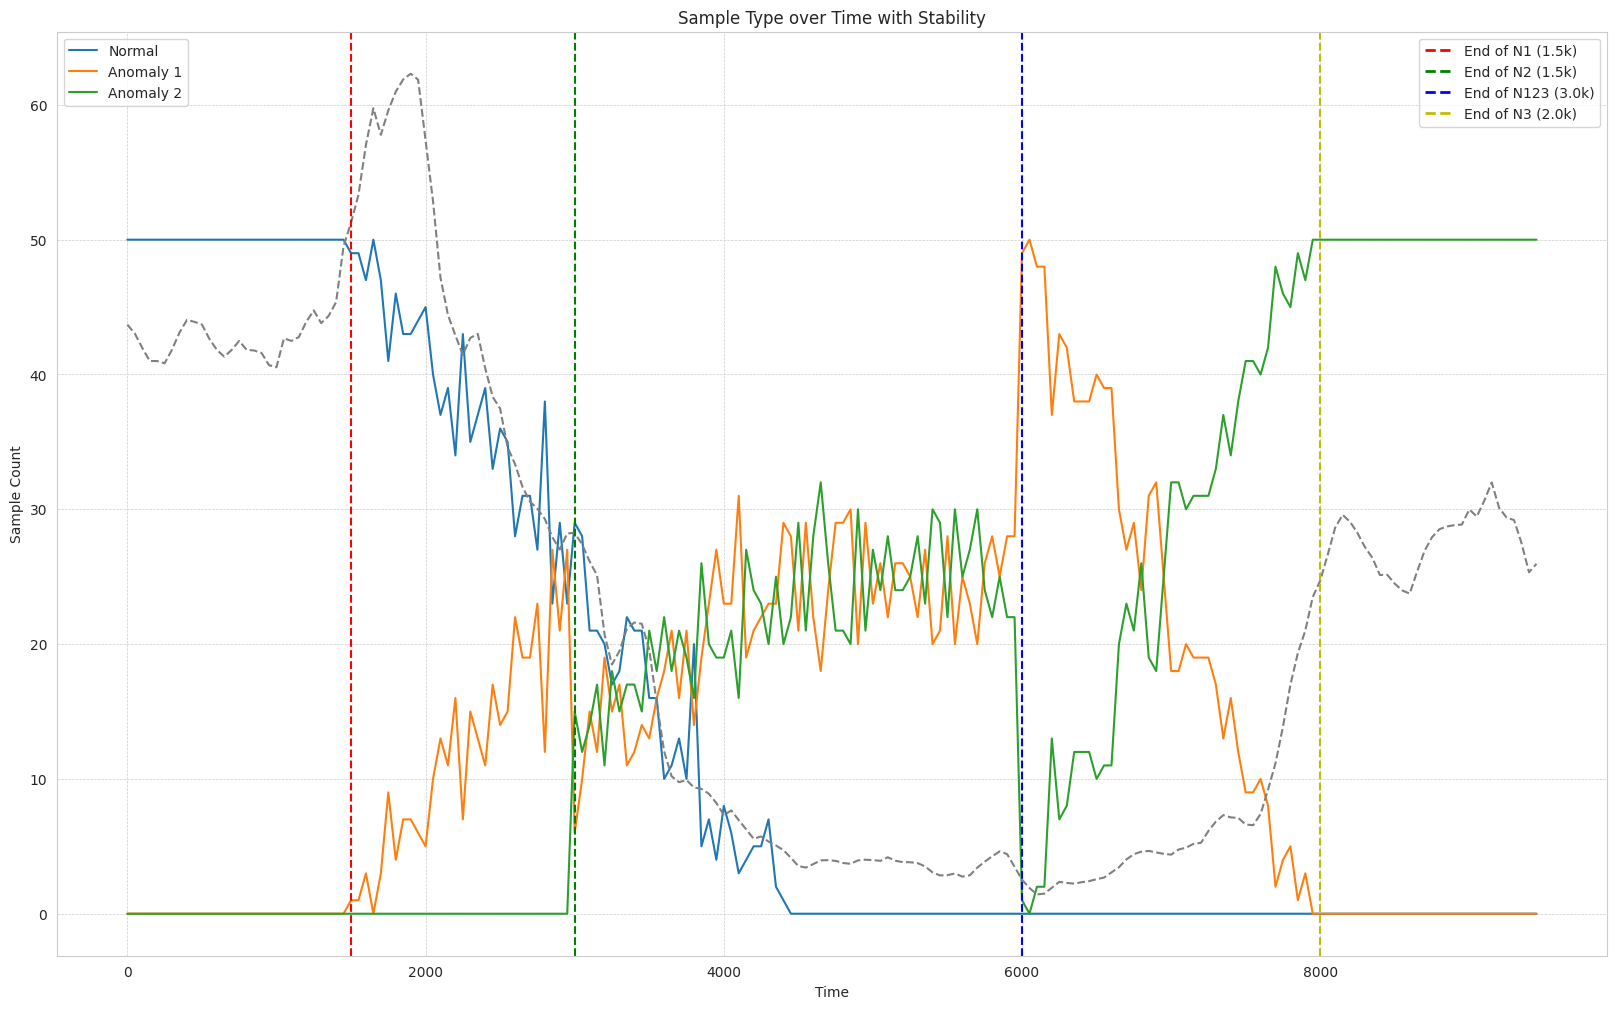

In [66]:
plot_time_series_with_stability(time_series, k, df_stability_lime_100_25_current_window_v5, smoothing_window=5)

In [206]:
# detektor zmian w szeregu
# analizator stabilnosci
# Jao decyduje co dalej

In [ ]:
# LIME vs SHAP - change detection / stability
# TODO stability objasnien tych samych obserwcji - background musi być == window
# change detection dla raw features
# reguly

In [68]:
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_shap_100_25_previous_window_v5, df_individual_shap_100_25_previous_window_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_shap_100_25_start, model_classifier, scaler, n_comparisons=100, # df_importance_shap_100_25_start - computed importance values; only indexes are used
        explainer_type="SHAP", background_data_source='previous_window')
save_to_pickle(df_stability_shap_100_25_previous_window_v5, 'df_stability_shap_100_25_previous_window_v5.pkl')
save_to_pickle(df_individual_shap_100_25_previous_window_v5, 'df_individual_shap_100_25_previous_window_v5.pkl')

Saved to fast/inxai/examples/jgama/serialised/df_stability_shap_100_25_previous_window_v5.pkl
Saved to fast/inxai/examples/jgama/serialised/df_individual_shap_100_25_previous_window_v5.pkl


N1_effective= 1500.0


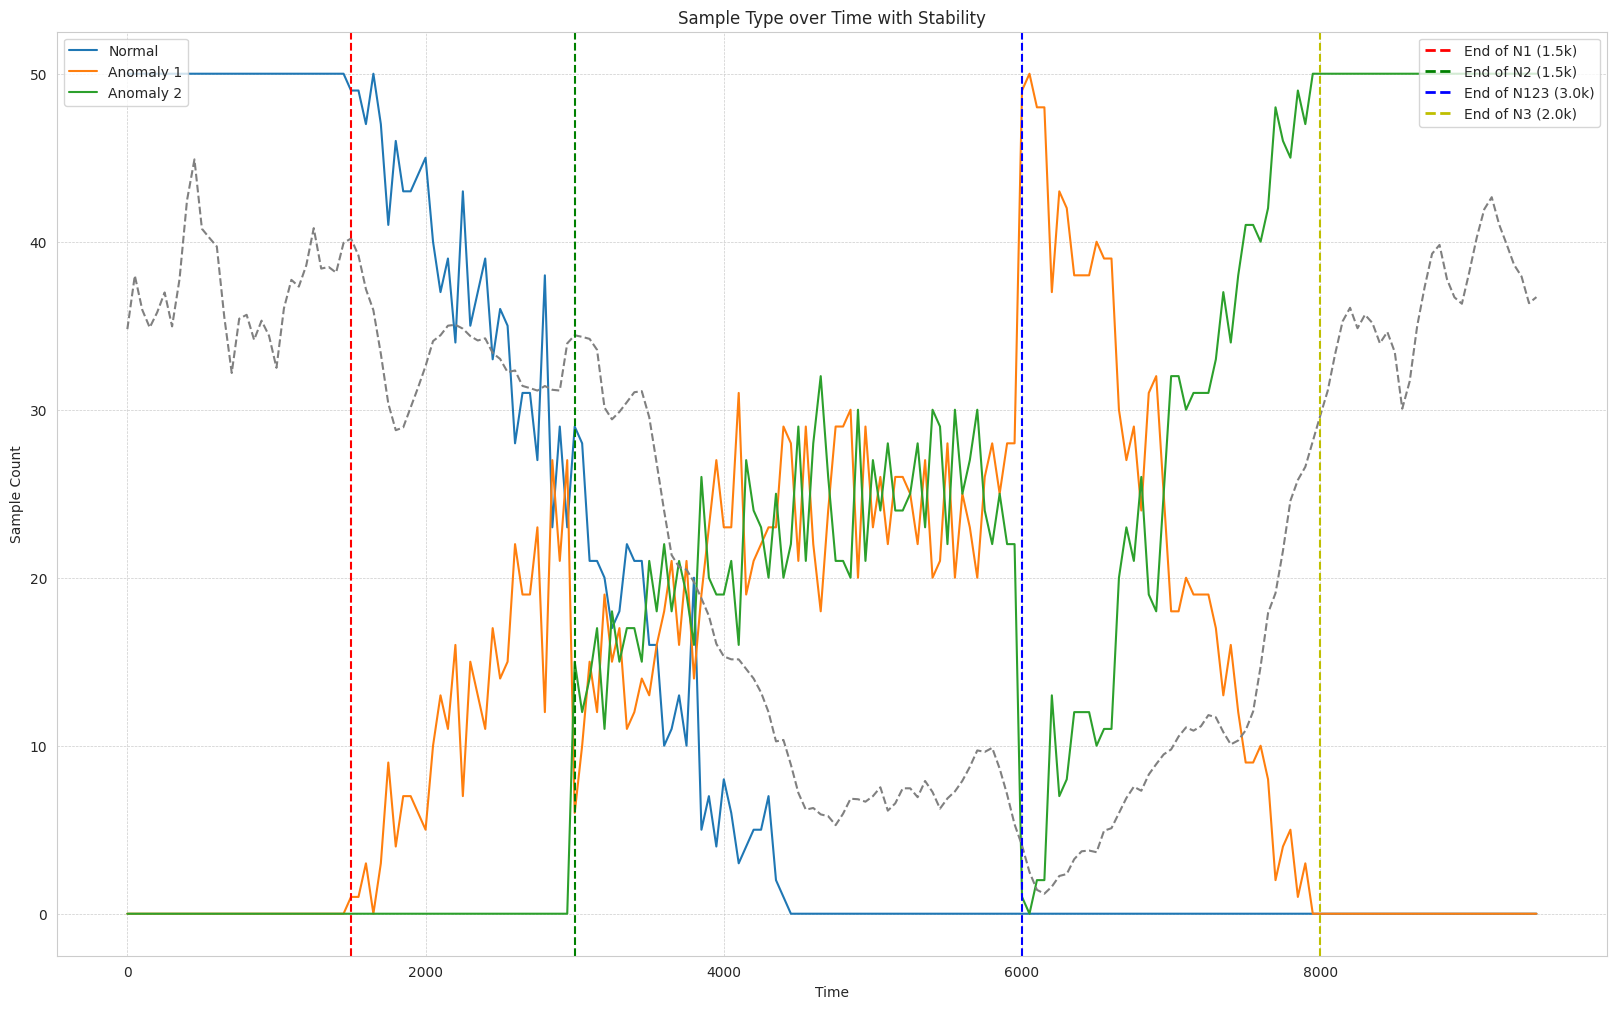

In [57]:
df_individual_shap_100_25_previous_window_v5 = load_from_pickle('df_individual_shap_100_25_previous_window_v5.pkl') 
df_stability_shap_100_25_previous_window_v5 = load_from_pickle('df_stability_shap_100_25_previous_window_v5.pkl')
plot_time_series_with_stability(time_series, k, df_stability_shap_100_25_previous_window_v5, smoothing_window=5)

In [ ]:
# TODO run later
with contextlib.redirect_stdout(io.StringIO()):
    df_stability_lime_100_25_previous_window_v5, df_individual_lime_100_25_previous_window_v5 = compute_stability_in_windows_v5_choose_background(
        time_series_df, df_importance_lime_100_25_start, model_classifier, scaler, n_comparisons=100,
        explainer_type="LIME", background_data_source='previous_window')
save_to_pickle(df_stability_lime_100_25_previous_window_v5, 'df_stability_lime_100_25_previous_window_v5_bis.pkl')
save_to_pickle(df_individual_lime_100_25_previous_window_v5, 'df_individual_lime_100_25_previous_window_v5_bis.pkl')

In [ ]:
1+1

# Change detection based on features itself

In [76]:
time_series_df  # = structured_list_to_dataframe(time_series)

sepal_length_cm  sepal_width_cm  petal_length_cm  petal_width_cm  \
0            6.095280        2.672847         4.091989        1.201099   
1            7.092402        3.254848         4.609519        1.453468   
2            6.453958        3.053285         4.451034        1.208603   
3            5.552380        2.958226         4.410573        1.429763   
4            6.420484        2.563534         4.946961        1.491867   
...               ...             ...              ...             ...   
9495         6.945585        3.005962         6.015763        2.154827   
9496         6.213917        2.952834         5.659013        1.794457   
9497         6.904510        3.138869         5.306933        2.103187   
9498         4.844547        2.687306         4.269774        1.687478   
9499         6.805951        3.225471         5.662945        2.269153   

     true_target       xai_classifier contrastive_autoencoder  \
0              N  normal (versicolor)     normal (versicolor)   
1              N  normal (versicolor)     normal (versicolor)   
2              N  normal (versicolor)     normal (versicolor)   
3              N  normal (versicolor)     normal (versicolor)   
4              N  normal (versicolor)     normal (versicolor)   
...          ...                  ...                     ...   
9495          A2              anomaly                 anomaly   
9496          A2              anomaly                 anomaly   
9497          A2              anomaly                 anomaly   
9498          A2  normal (versicolor)                 anomaly   
9499          A2              anomaly                 anomaly   

      true_target_recoded  
0     normal (versicolor)  
1     normal (versicolor)  
2     normal (versicolor)  
3     normal (versicolor)  
4     normal (versicolor)  
...                   ...  
9495              anomaly  
9496              anomaly  
9497              anomaly  
9498              anomaly  
9499              anomaly  

[9500 rows x 8 columns]

In [111]:
change_points_iso_forest_from_ts = detect_change_points_isolation_forest(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']], 0.001,
    features_to_plot=[
        # 'sepal_length_cm', #'sepal_width_cm', 'petal_length_cm', 'petal_width_cm'
    ])
# change_points_iso_forest_from_ts

Detected change points at: [3571 4387 4469 6678]


In [145]:
detect_change_points_isolation_forest(
    time_series_df[['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']], 0.001,
    features_to_plot=[
        # 'sepal_length_cm', #'sepal_width_cm', 'petal_length_cm', 'petal_width_cm'
    ])

Detected change points at: [3571 4387 4469 5237 6118 6325 6678 7358 7675]


[3571, 4387, 4469, 5237, 6118, 6325, 6678, 7358, 7675]

N1_effective= 1500.0


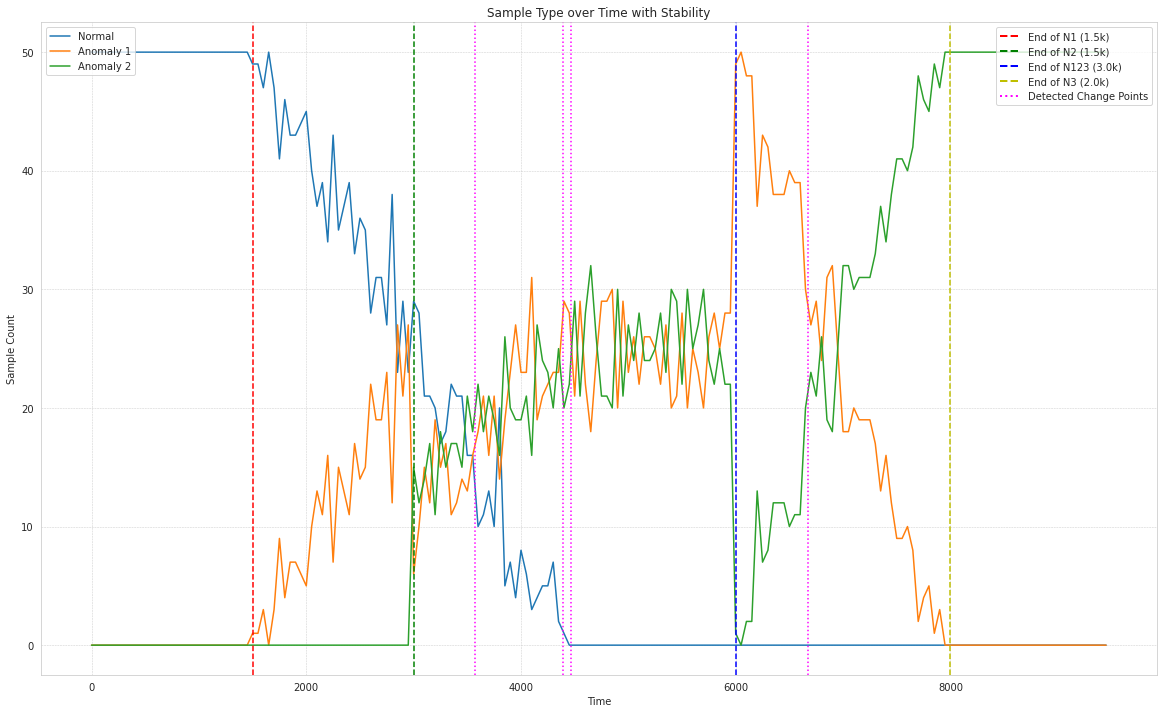

In [112]:
plot_time_series_with_stability(time_series, k, None, detected_change_points=change_points_iso_forest_from_ts)

In [ ]:
# kiedy to daje gorsze wyniki
# dac na duzym zbiorze datasetow
# isoforest ma malo stabilne reguly -> do frameorka

# Stability of decision trees explainer

In [121]:
time_series_df.columns

Index(['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm',
       'petal_width_cm', 'true_target', 'xai_classifier',
       'contrastive_autoencoder', 'true_target_recoded'],
      dtype='object')

In [183]:
def fit_decision_trees(
        df: pd.DataFrame,
        y_col: str,
        window: int = 100,
        slide: int = 25,
        indices: Optional[List[int]] = None,
        use_full_background: bool = False
) -> List[Tuple[int, int, str]]:
    # List of feature columns
    feature_cols = ['sepal_length_cm', 'sepal_width_cm', 'petal_length_cm', 'petal_width_cm']

    # Extract data and labels from the DataFrame
    data = df[feature_cols].values
    labels = df[y_col].values

    # If no specific indices are provided, calculate for the entire series
    if indices is None:
        indices = list(range(0, len(data) - window + 1, slide))

    classifiers_results = []

    for idx in indices:
        start, end = idx, idx + window

        if use_full_background:
            X = data[:end]
            y = labels[:end]
        else:
            X = data[start:end]
            y = labels[start:end]

        classifier = DecisionTreeClassifier(max_depth=3)
        classifier = classifier.fit(X, y)

        rules = export_text(classifier, feature_names=feature_cols)
        classifiers_results.append((start, end, rules, classifier))

    return classifiers_results


decision_trees_tmp = fit_decision_trees(time_series_df, y_col="contrastive_autoencoder", window=100, slide=25,
                                        indices=[0, 3000], use_full_background=False)
decision_trees_tmp

[(0,
  100,
  '|--- sepal_length_cm <= 5.10\n|   |--- class: anomaly\n|--- sepal_length_cm >  5.10\n|   |--- petal_width_cm <= 1.75\n|   |   |--- class: normal (versicolor)\n|   |--- petal_width_cm >  1.75\n|   |   |--- class: anomaly\n',
  DecisionTreeClassifier(max_depth=3)),
 (3000,
  3100,
  '|--- petal_width_cm <= 1.68\n|   |--- petal_length_cm <= 3.43\n|   |   |--- class: anomaly\n|   |--- petal_length_cm >  3.43\n|   |   |--- class: normal (versicolor)\n|--- petal_width_cm >  1.68\n|   |--- petal_length_cm <= 4.95\n|   |   |--- petal_width_cm <= 1.82\n|   |   |   |--- class: anomaly\n|   |   |--- petal_width_cm >  1.82\n|   |   |   |--- class: normal (versicolor)\n|   |--- petal_length_cm >  4.95\n|   |   |--- class: anomaly\n',
  DecisionTreeClassifier(max_depth=3))]

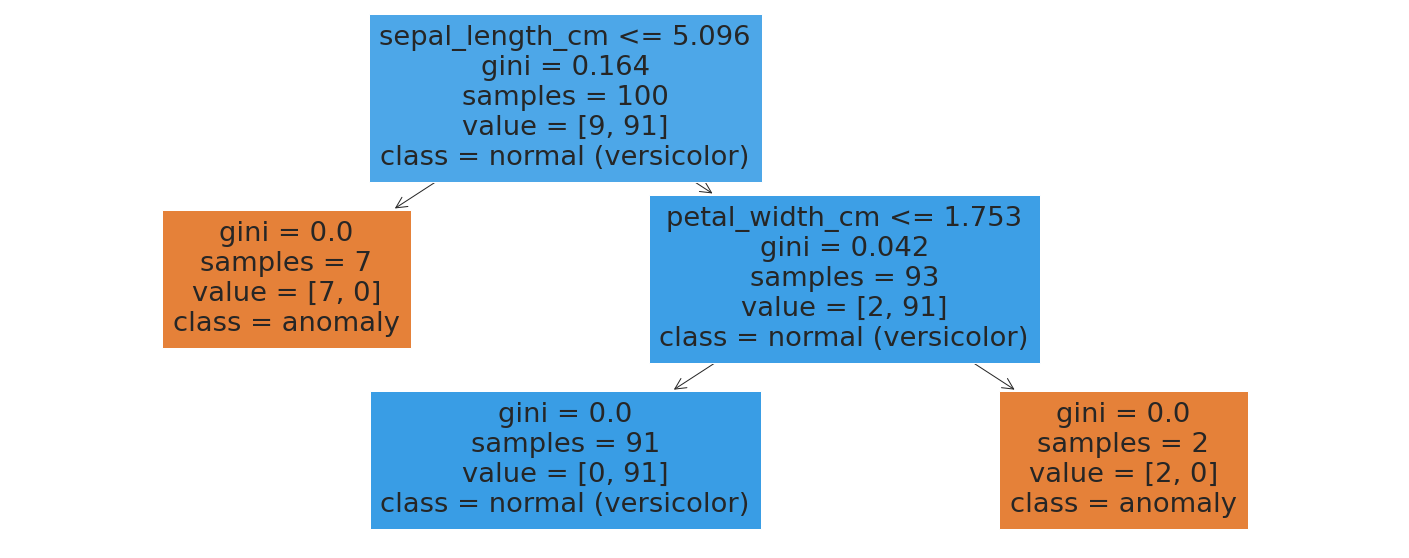

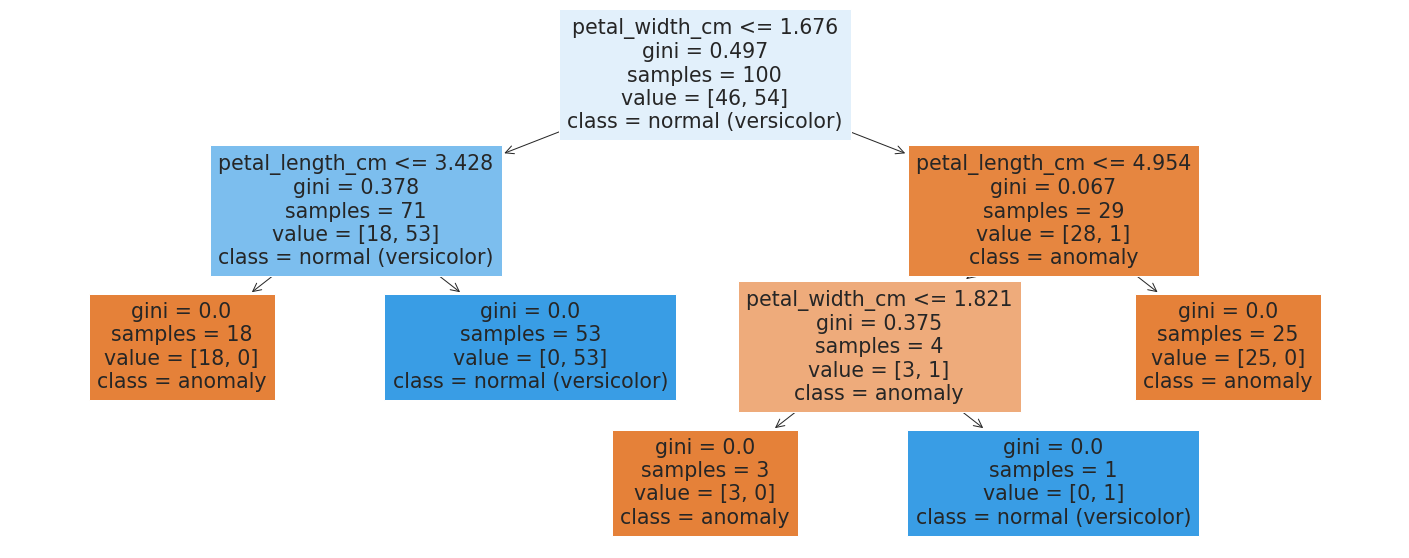

In [184]:
tree1_tmp = decision_trees_tmp[0][3]
plt.figure(figsize=(25, 10))  # Set the figure size
plot_tree(tree1_tmp, feature_names=_feature_names, class_names=classifier.classes_, filled=True)
plt.show()

tree2_tmp = decision_trees_tmp[1][3]
plt.figure(figsize=(25, 10))  # Set the figure size
plot_tree(tree2_tmp, feature_names=_feature_names, class_names=classifier.classes_, filled=True)
plt.show()

In [ ]:
# dodac coverege - ten sam obszar danych 

In [192]:
# 'predictions', 'structure', or 'feature_importance'
decision_tree_similarity(tree1_tmp, tree2_tmp, X_background=None, feature_names=_feature_names,
                         method='feature_importance')

0.1898711316100608

In [193]:
decision_tree_similarity(tree1_tmp, tree2_tmp, X_background=X_test_3_unscaled_df[_feature_names],
                         feature_names=_feature_names,
                         method='predictions')  # y_background=pd.DataFrame(y_test_3_pred_names)

0.8146666666666667

In [194]:
decision_tree_similarity(tree1_tmp, tree2_tmp, X_background=None, feature_names=_feature_names, method='structure')

0.0

In [158]:
decision_trees_full_background = fit_decision_trees(time_series_df, y_col="contrastive_autoencoder", window=100,
                                                    slide=25, indices=None, use_full_background=True)
decision_trees_window_background = fit_decision_trees(time_series_df, y_col="contrastive_autoencoder", window=100,
                                                      slide=25, indices=None, use_full_background=False)

save_to_pickle(decision_trees_full_background, 'decision_trees_full_background.pkl')
save_to_pickle(decision_trees_window_background, 'decision_trees_window_background.pkl')

Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/decision_trees_full_background.pkl
Saved to /media/mmozolewski/m.mozolewski@gma2/Documents/Doktorat/inxai/examples/jgama/serialised/decision_trees_window_background.pkl


In [195]:
# [structure] -> 1. Tree Structure Similarity: Examine the similarity of the structure of the two trees. This means checking if nodes are split using the same features and similar thresholds. This is the most direct form of comparison but can be cumbersome and sensitive to slight changes.
# Traverse both trees node by node and compare if the same features are used for splitting and if the thresholds are approximately similar. This will give a similarity ratio based on matched nodes.
# 
# [predictions] -> 3. Similarity via Predictions on a Test Set: Use a test set or background data to generate predictions from both trees. The similarity of their predictions can be measured using metrics such as accuracy, F1 score, etc. This method doesn't directly compare the trees but their outcomes.
# 
# [feature_importance] -> 4. Feature Importance Similarity: Measure the importance of features in both trees. If both trees deem the same features as highly important, they may be considered similar.
# Compute the cosine similarity between the feature importance vectors of the two trees. Cosine similarity returns a value between 0 (completely dissimilar) and 1 (completely similar), which will represent our similarity measure.

tree1_tmp_2 = decision_trees_full_background[-1][3]
tree2_tmp_2 = decision_trees_full_background[-1][3]

get_decision_tree_similarities(tree1_tmp_2, tree2_tmp_2, X_test_3_unscaled_df[_feature_names])

feature_importance= 1.0, predictions= 1.0, structure= 1.0


(1.0, 1.0, 1.0)

In [224]:
df_stability_lime_100_25_current_window_v5

start   end  observations_distance_sum  explanations_distance_sum  \
0        0   100                 239.939502                  22.253561   
1       25   125                 248.762187                  21.339698   
2       50   150                 247.208499                  19.966167   
3       75   175                 235.952169                  20.311132   
4      100   200                 261.600740                  20.369165   
..     ...   ...                        ...                        ...   
372   9300  9400                 286.891625                  14.460199   
373   9325  9425                 298.145374                  14.009945   
374   9350  9450                 319.753085                  16.430721   
375   9375  9475                 294.455500                  16.843218   
376   9400  9500                 315.175067                  17.001526   

     stability_for_a_window  
0                  0.092747  
1                  0.085784  
2                  0.080767  
3                  0.086082  
4                  0.077864  
..                      ...  
372                0.050403  
373                0.046990  
374                0.051386  
375                0.057201  
376                0.053943  

[377 rows x 5 columns]

In [234]:
# TODO calculate stability in every window and visualize
pd.DataFrame({
    'start': [x[0] for x in decision_trees_full_background],
    'end': [x[1] for x in decision_trees_full_background],
    'd_tree': [x[3] for x in decision_trees_full_background],
})

start   end                               d_tree
0        0   100  DecisionTreeClassifier(max_depth=3)
1       25   125  DecisionTreeClassifier(max_depth=3)
2       50   150  DecisionTreeClassifier(max_depth=3)
3       75   175  DecisionTreeClassifier(max_depth=3)
4      100   200  DecisionTreeClassifier(max_depth=3)
..     ...   ...                                  ...
372   9300  9400  DecisionTreeClassifier(max_depth=3)
373   9325  9425  DecisionTreeClassifier(max_depth=3)
374   9350  9450  DecisionTreeClassifier(max_depth=3)
375   9375  9475  DecisionTreeClassifier(max_depth=3)
376   9400  9500  DecisionTreeClassifier(max_depth=3)

[377 rows x 3 columns]

In [ ]:
plot_stability(df_stability_lime_100_25_current_window_v5)

N1_effective= 1500.0
feature_importance= 0.07855195912694414, predictions= 0.8553333333333333, structure= 0.0
feature_importance= 0.9670645101287113, predictions= 0.976, structure= 0.6666666666666666
feature_importance= 0.35748219448634977, predictions= 0.8653333333333333, structure= 0.4
feature_importance= 0.9977276108388703, predictions= 0.9926666666666667, structure= 0.3333333333333333
feature_importance= 0.9999766181924785, predictions= 1.0, structure= 0.3333333333333333
feature_importance= 0.9993482442177237, predictions= 1.0, structure= 0.6
feature_importance= 0.9984239902196823, predictions= 1.0, structure= 1.0
feature_importance= 0.9971450213778575, predictions= 0.9946666666666667, structure= 0.6
feature_importance= 0.9995441593473741, predictions= 1.0, structure= 1.0
feature_importance= 0.9986567423238141, predictions= 1.0, structure= 1.0
feature_importance= 0.9981712464692752, predictions= 1.0, structure= 1.0
feature_importance= 0.9980392333603989, predictions= 1.0, structure

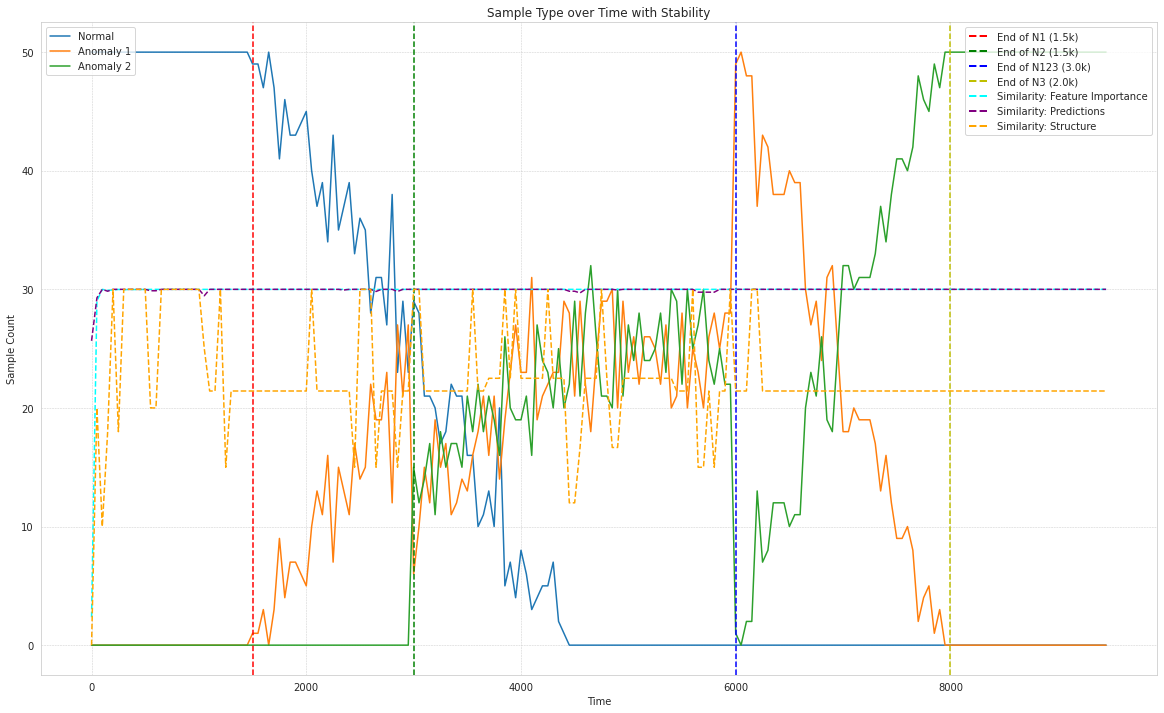

In [236]:
plot_time_series_with_stability(time_series, k, a_stability_df=None, decision_trees=decision_trees_full_background,
                                X_background=X_test_3_unscaled_df[_feature_names], detected_change_points=None)

N1_effective= 1500.0
feature_importance= 0.04596375782122113, predictions= 0.8466666666666667, structure= 0.0
feature_importance= 0.9208156182335439, predictions= 0.9406666666666667, structure= 0.0
feature_importance= 0.5384447001780212, predictions= 0.8746666666666667, structure= 0.16666666666666666
feature_importance= 0.9958618164004817, predictions= 0.9666666666666667, structure= 0.3333333333333333
feature_importance= 0.9902795503452932, predictions= 0.962, structure= 0.0
feature_importance= 0.8947823437506602, predictions= 0.9953333333333333, structure= 0.25
feature_importance= 0.0, predictions= 0.6426666666666667, structure= 0.0
feature_importance= 0.0, predictions= 0.6406666666666667, structure= 0.0
feature_importance= 0.14563601985618027, predictions= 0.8953333333333333, structure= 0.2
feature_importance= 0.25867444365165304, predictions= 0.898, structure= 0.2
feature_importance= 0.99772073336271, predictions= 0.9986666666666667, structure= 0.5
feature_importance= 0.191731367547

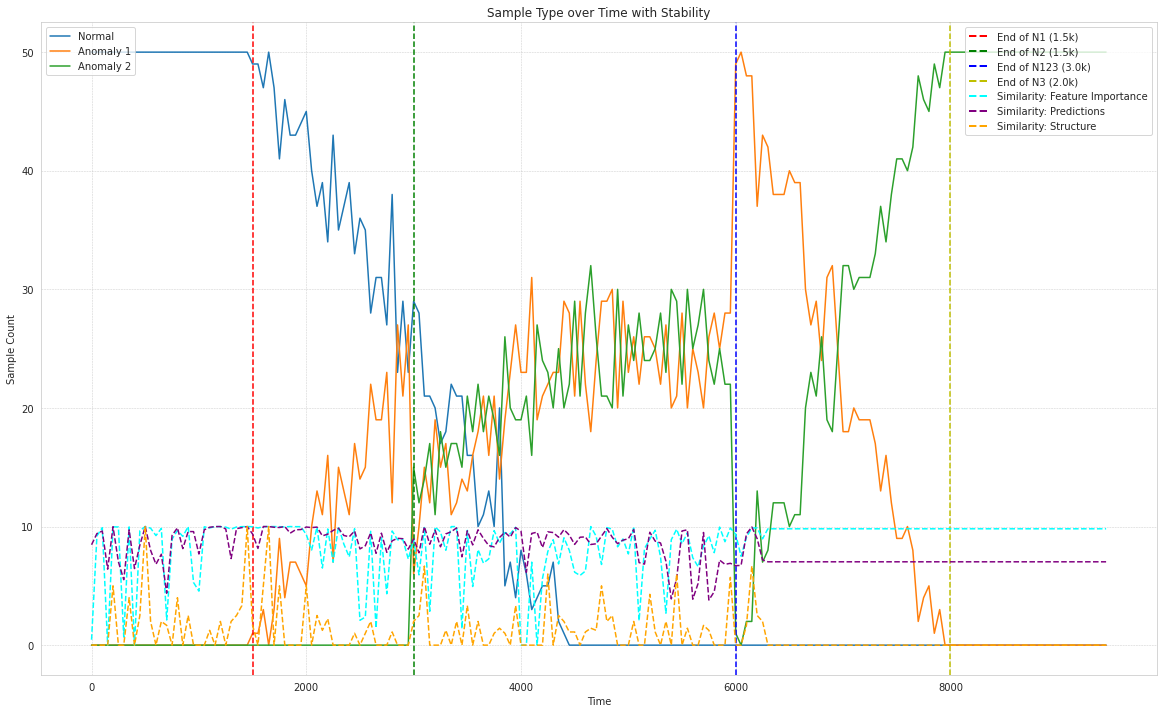

In [243]:
plot_time_series_with_stability(time_series, k, a_stability_df=None, decision_trees=decision_trees_window_background,
                                X_background=X_test_3_unscaled_df[_feature_names], detected_change_points=None)

In [ ]:
# TODO
# Special issue Information Fusion -  metryki i ich ewaluacji - wieksza skala
# case: Metro z Gama
# Jurnalowy 
# - z poprzedniego wizualizacje, perturbacje 

In [ ]:
# stability - to za malo - jak on radzi sobie w innych metrykach np. fidelity 
# mozna zwizualizowac na 1 wykresie (warstowy) 

In [ ]:
# ??? podobienstw o objasnien roznych modeli vs podobienstwo modeli per se

In [ ]:
# Skupic sie na wnioskach
# Rzeczywisty strumowieniowy dataset - metro de porto  https://www.kaggle.com/datasets/pattinson9999/uci-metropt-3-dataset - to tez Jao interesuje

In [37]:
# Fidelity: 
# LIME - ok
# SHAP - jak zdefniowac??

# LUX -> stability over time with Jackard index

In [55]:
! GIT_SSH_COMMAND="ssh -o StrictHostKeyChecking=no" git clone https://github.com/sbobek/lux.git
! cd lux && git checkout lux-benchmark

Cloning into 'lux'...
remote: Enumerating objects: 733, done.
remote: Counting objects: 100% (435/435), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 733 (delta 154), reused 367 (delta 111), pack-reused 298
Receiving objects: 100% (733/733), 219.75 MiB | 13.93 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Updating files: 100% (239/239), done.
Branch 'lux-benchmark' set up to track remote branch 'lux-benchmark' from 'origin'.
Switched to a new branch 'lux-benchmark'


In [ ]:
! cd lux && mv lux/lux.py lux/LUX.py

In [70]:
! cd lux && wget -O UncertainSMOTE.py https://raw.githubusercontent.com/sbobek/lux/main/lux/UncertainSMOTE.py

--2023-12-12 13:16:49--  https://raw.githubusercontent.com/sbobek/lux/main/lux/UncertainSMOTE.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7217 (7.0K) [text/plain]
Saving to: ‘UncertainSMOTE.py’

UncertainSMOTE.py   100%[===================>]   7.05K  --.-KB/s    in 0s      

2023-12-12 13:16:49 (63.4 MB/s) - ‘UncertainSMOTE.py’ saved [7217/7217]



In [72]:
# not working
! cd lux && cp UncertainSMOTE.py UncertainEntropyEvaluator.py

In [59]:
! cd lux && git clone https://github.com/sbobek/pyuid3.git

Cloning into 'pyuid3'...
remote: Enumerating objects: 1398, done.
remote: Counting objects: 100% (229/229), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 1398 (delta 165), reused 109 (delta 70), pack-reused 1169
Receiving objects: 100% (1398/1398), 5.22 MiB | 2.38 MiB/s, done.
Resolving deltas: 100% (1081/1081), done.


In [ ]:
# Uruchomić tylko 1 raz
# Dodaje tekst "from pyuid3.uncertain_entropy_evaluator import UncertainEntropyEvaluator" jako nową linię na pozycji 25 w pliku lux/lux/LUX.py 
! cd lux && sed -i '25ifrom pyuid3.uncertain_entropy_evaluator import UncertainEntropyEvaluator' lux/LUX.py

In [65]:
module_path = "/home/jovyan/lux/pyuid3"  # quick-fix
if module_path not in sys.path:
    print(f"Ścieżka '{module_path}' dodana do sys.path.")
    sys.path.append(module_path)

from pyuid3.uncertain_entropy_evaluator import UncertainEntropyEvaluator # just for test

Ścieżka '/home/jovyan/lux/pyuid3' dodana do sys.path.


In [ ]:
from lux.lux import LUX